# From file "functions.R"

It contains functions that are used in calculations for all files, so better load it immediately

In [1]:
### let's use a look up table to clean special characters
cleanSpecialChars = function(text) {
  specialChars = c('\x92')
  substitution = c('\'')
  for (i in 1:length(specialChars)) {
    text = gsub(specialChars[i],substitution[i],text)
  }
  return(text)
}

### assign a code with an existing list of words (indices used)
assignCodes = function(cleanTurn,wordCode) {
  series = c()
  for (word in unlist(strsplit(cleanTurn,' '))) {
    series = c(series, which(word==wordCode))
  }
  return(series)
}

### assign a code with an existing list of characters (indices used)
assignCharCodes = function(cleanTurn,charCode) {
  series = c()
  for (charct in unlist(strsplit(cleanTurn,''))) {
    series = c(series, which(charct==charCode))
  }
  return(series)
}

cleanText = function(rawText) {
  rawText = Corpus(VectorSource(rawText))    
  # eliminate extra whitespace; requires tm
  rawText = tm_map(rawText, stripWhitespace)
  rawText = tm_map(rawText, tolower)
  # eliminate punctuation
  removepunct = function(x) { return(gsub("[[:punct:]]","",x)) }
  rawText = tm_map(rawText, removepunct)[[1]]  
  return(rawText)
}

# uses crqa
plotRP = function(RP,xlab,ylab) {
  ij = which(RP==1,arr.ind=T)
  plot(ij[,1],ij[,2],cex=.25,xlab=xlab,ylab=ylab,pch=14)
}

# splits by null character to get characters ("letters")
makeCharacterSequence = function(fl,numbersToFile=NULL) {
  rawText = readChar(fl,file.info(fl)$size)
  chars = unlist(strsplit(rawText, ""))
  uniqChars = unique(chars)
  charSeries = as.vector(sapply(chars,function(x) {
    which(x == uniqChars)
  }))
  if (!is.null(numbersToFile)) {
    write.table(charSeries,file=numbersToFile,row.names=F,col.names=F)
  }
  return(charSeries)
} 

# this function tokenizes with the space character; 
# you could also improve it by utilizing any white space,
# or tokenizer like MC_tokenizer, etc.
makeWordSequence = function(fl,trimPunctuation=FALSE,stemWords=FALSE,numbersToFile=NULL,isUrl=FALSE) {
  if (!isUrl) { # it's a file name
    rawText = readChar(fl,file.info(fl)$size)
  } else { # it's a url, get the file
    rawText = getURL(fl, ssl.verifypeer = FALSE)
  }
    
  if (trimPunctuation) {
    rawText = Corpus(VectorSource(rawText))    
    # eliminate extra whitespace; requires tm
    rawText = tm_map(rawText, stripWhitespace)
    # eliminate punctuation
    removepunct = function(x) { return(gsub("[[:punct:]]","",x)) }
    rawText = tm_map(rawText, removepunct)[[1]]
  }  
  if (stemWords) {
    words = wordStem(unlist(strsplit(tolower(stri_unescape_unicode(rawText)), ' ')))       
  } else {
    words = unlist(strsplit(tolower(stri_unescape_unicode(rawText)), ' '))                   
  }
                   
  uniqWords = unique(words)
  
  wordSeries = as.vector(sapply(words,function(x) {
    which(x == uniqWords)
  }))
  
  if (!is.null(numbersToFile)) {
    write.table(wordSeries,file=numbersToFile,row.names=F,col.names=F)
  }    
  return(wordSeries)
}

print_stats = function(lmo) {
  coefs = data.frame(summary(lmo)$coefficient)
  coefs$p = 2*(1-pnorm(abs(coefs$t.value)))
  return(coefs)
}

# From file "Affordances_SpatialExpressions.R"

In [2]:
library(gdata)
#library(XLConnect)
library(pander)
library(dplyr)
library(lme4)
library(afex)
library(lmerTest)
library(MuMIn)
library(broom)
library(ggplot2)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.


Attaching package: ‘gdata’


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith



Attaching package: ‘dplyr’


The following objects are masked from ‘package:gdata’:

    combine, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('em

In [121]:
fls = list.files("/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/", pattern='xls') # get list of xls files
rt = "/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/" # root folder location

In [122]:
allData = c() #initiate empty variable for masterfile
allDialogues = c() #initiate empty variable for aggregate dialogue data 

In [123]:
for (fl in fls) {
    print(fl)
    fileName = paste(rt,fl,sep='')
    Dialogue = read.xls(fileName, stringsAsFactors=F, header=T) 
    colnames(Dialogue) = c("Pair","Session","Route","Affordance","Turn","Speaker", "SpeechContent","SpatialExpression","SE_Route","SE_Allocentric","SE_Neutral","Ambiguous","Landmark","Demonstrative","WordCount")  
    Dialogue$centered_Turn =scale(Dialogue$Turn) #create standardized Turn variable
    
    #get aggregate measures about each dialogue
    finalTurn = length(Dialogue$Turn) #grab max turn to get the range across dialogues
    TotalDialogueWords = sum(Dialogue$WordCount) #grab total word count for dialogue
    TotalDialogueWords_DG = sum(Dialogue$WordCount[Dialogue$Speaker %in% c('DG')]) #get DG's words per dialogue
    TotalDialogueWords_DF = sum(Dialogue$WordCount[Dialogue$Speaker %in% c('DF')]) #get DF's words per dialogue
    SE_Route_freq = (sum(Dialogue$SE_Route)/TotalDialogueWords) * 100 
    SE_Route_freq_DG = (sum(Dialogue$SE_Route[Dialogue$Speaker %in% c('DG')])/TotalDialogueWords_DG) * 100
    SE_Route_freq_DF = (sum(Dialogue$SE_Route[Dialogue$Speaker %in% c('DF')])/TotalDialogueWords_DF) * 100 
    SE_Survey_freq = (sum(Dialogue$SE_Allocentric)/TotalDialogueWords) * 100
    SE_Survey_freq_DG = (sum(Dialogue$SE_Allocentric[Dialogue$Speaker %in% c('DG')])/ TotalDialogueWords_DG) * 100 
    SE_Survey_freq_DF = (sum(Dialogue$SE_Allocentric[Dialogue$Speaker %in% c('DF')])/TotalDialogueWords_DF) * 100
    
    allData = rbind(allData, Dialogue)
    
    allDialogues = rbind(allDialogues, data.frame(Dialogue$Pair[1], Dialogue$Session[1], Dialogue$Affordance[1], Dialogue$Route[1], 
                                                  finalTurn, TotalDialogueWords, TotalDialogueWords_DG, TotalDialogueWords_DF,
                                                  SE_Route_freq, SE_Route_freq_DG, SE_Route_freq_DF,
                                                  SE_Survey_freq, SE_Survey_freq_DG, SE_Survey_freq_DF))
}

[1] "Affordances_Pair1_Session2_Ledras1_Side_CodedTrascript.xlsx"
[1] "Affordances_Pair1_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair10_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair10_Session3_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair11_Session2_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair11_Session3_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair12_Session2_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair12_Session3_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair13_Session1_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair13_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair14_Session1_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair14_Session4_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair15_Session1_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair15_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair16

In [124]:
#Add column names to allDialogues file
colnames(allDialogues) = c("Pair","Session","Affordance","Route", "finalTurn", 
                           "TotalWords", "TotalWords_DG", "TotalWords_DF", 
                           "SE_Route_freq", "SE_Route_freq_DG", "SE_Route_freq_DF",
                           "SE_Survey_freq", "SE_Survey_freq_DG", "SE_Survey_freq_DF")  

dim(allData)
dim(allDialogues)

[1] 8428   16

[1] 64 14

In [125]:
############################################
### Add partners' gender & Familiarity #####
############################################

allDialogues$PairFamiliarity <- c("acquaintances", "acquaintances", #pair 1
                                  "acquaintances", "acquaintances", #pair 10
                                  "friends", "friends", #pair 11
                                  "strangers", "strangers", #pair 12
                                  "acquaintances", "acquaintances", #pair 13
                                  "friends", "friends", #pair 14
                                  "unknown", "unknown", #pair 15
                                  "friends", "friends", #pair 16
                                  "strangers", "strangers", #pair 17
                                  "couple", "couple", #pair 18
                                  "unknown", "unknown", #pair 19
                                  "friends", "friends", #pair 2
                                  "friends", "friends", #pair 20
                                  "friends", "friends", #pair 21
                                  "friends", "friends", #pair 22
                                  "unknown", "unknown", #pair 23
                                  "couple", "couple", #pair 24
                                  "acquaintances", "acquaintances", #pair 25
                                  "strangers", "strangers", #pair 26
                                  "friends", "friends", #pair 27
                                  "strangers", "strangers", #pair 28
                                  "friends", "friends", #pair 29
                                  "unknown", "unknown", #pair 3
                                  "acquaintances", "acquaintances", #pair 30
                                  "friends", "friends", #pair 31
                                  "friends", "friends", #pair 32
                                  "friends", "friends", #pair 4
                                  "strangers", "strangers", #pair 5
                                  "strangers", "strangers", #pair 6
                                  "strangers", "strangers", #pair 7
                                  "friends", "friends", #pair 8
                                  "strangers", "strangers" #pair 9
                                  )

table(allDialogues$PairFamiliarity)


acquaintances        couple       friends     strangers       unknown 
           10             4            26            16             8 

In [126]:
PairsGender <- matrix(c("male", "female", #pair 1
                                  "male", "female", #pair 10
                                  "male", "female", #pair 11
                                  "female", "female", #pair 12
                                  "female", "male", #pair 13
                                  "female", "female", #pair 14
                                  "female", "female", #pair 15
                                  "female", "female", #pair 16
                                  "female", "female", #pair 17
                                  "male", "female", #pair 18
                                  "female", "female", #pair 19
                                  "female", "female", #pair 2
                                  "female", "male", #pair 20
                                  "female", "female", #pair 21
                                  "female", "female", #pair 22
                                  "female", "female", #pair 23
                                  "male", "female", #pair 24
                                  "female", "female", #pair 25
                                  "female", "female", #pair 26
                                  "female", "female", #pair 27
                                  "female", "female", #pair 28
                                  "female", "female", #pair 29
                                  "female", "female", #pair 3
                                  "male", "female", #pair 30
                                  "male", "male", #pair 31
                                  "female", "female", #pair 32
                                  "female", "female", #pair 4
                                  "female", "male", #pair 5
                                  "female", "female", #pair 6
                                  "female", "male", #pair 7
                                  "male", "male", #pair 8
                                  "female", "female" #pair 9
), ncol = 2, byrow = TRUE)

In [127]:
colnames(PairsGender) <- c("DG_Gender", "DF_Gender")

In [128]:
PairsGender <- as.data.frame(PairsGender)
PairsGender$PairType <- paste(PairsGender$DG_Gender,PairsGender$DF_Gender)

In [129]:
PairsGender

DG_Gender,DF_Gender,PairType
<chr>,<chr>,<chr>
male,female,male female
male,female,male female
male,female,male female
female,female,female female
female,male,female male
female,female,female female
female,female,female female
female,female,female female
female,female,female female


In [130]:
table(PairsGender$PairType)
table(PairsGender$DG_Gender)
table(PairsGender$DF_Gender)


female female   female male   male female     male male 
           20             4             6             2 


female   male 
    24      8 


female   male 
    26      6 

In [131]:
# Repeat each row 2, 
# since each Pair for allDialogues--with which we want to merge this info-- has two rows (one for each route)
PairsGender <- PairsGender[rep(seq_len(nrow(PairsGender)), each=2),]
PairsGender

,DG_Gender,DF_Gender,PairType
,<chr>,<chr>,<chr>
1,male,female,male female
1.1,male,female,male female
2,male,female,male female
2.1,male,female,male female
3,male,female,male female
3.1,male,female,male female
4,female,female,female female
4.1,female,female,female female
5,female,male,female male


In [132]:
# Add Gender information to the allDialogues dataframe
allDialogues <- cbind(allDialogues, PairsGender)
allDialogues

,Pair,Session,Affordance,Route,finalTurn,TotalWords,TotalWords_DG,TotalWords_DF,SE_Route_freq,SE_Route_freq_DG,SE_Route_freq_DF,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,DG_Gender,DF_Gender,PairType
,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,2,Side,Ledras1,94,457,308,149,13.347921,10.714286,18.791946,0.6564551,0.9740260,0.0000000,acquaintances,male,female,male female
1.1,1,4,Opposite,Ledras2,71,279,190,89,17.921147,16.842105,20.224719,0.0000000,0.0000000,0.0000000,acquaintances,male,female,male female
2,10,2,Opposite,Ledras 2,142,747,448,299,15.930388,12.276786,21.404682,2.4096386,1.7857143,3.3444816,acquaintances,male,female,male female
2.1,10,3,Side,Ledras 1,135,859,543,316,11.408615,7.918969,17.405063,4.3073341,5.3406998,2.5316456,acquaintances,male,female,male female
3,11,2,Side,Ledras 2,105,722,513,209,20.360111,14.035088,35.885167,0.5540166,0.3898635,0.9569378,friends,male,female,male female
3.1,11,3,Opposite,Ledras 1,86,475,357,118,14.526316,11.204482,24.576271,1.6842105,1.4005602,2.5423729,friends,male,female,male female
4,12,2,Opposite,Ledras 1,227,1106,587,519,7.956600,8.517888,7.321773,1.4466546,1.8739353,0.9633911,strangers,female,female,female female
4.1,12,3,Side,Ledras 2,94,395,225,170,14.936709,13.333333,17.058824,0.5063291,0.0000000,1.1764706,strangers,female,female,female female
5,13,1,Side,Ledras 1,157,1104,877,227,9.873188,10.262258,8.370044,0.6340580,0.4561003,1.3215859,acquaintances,female,male,female male


In [133]:
### Code those pairs who switched body orientation spontaneously ###

# Pairs who switched their body orientation:  
# Pairs 8, 15, 24, 25 switched from counter-aligned to aligned block 2
# Pairs 28 and 32 switched from aligned to counter-aligned in block 2

# for allDialogues
BodySwitch <- matrix(c("nonswitch", #pair 1
                           "nonswitch", #pair 10
                           "nonswitch", #pair 11
                           "nonswitch", #pair 12
                           "nonswitch", #pair 13
                           "nonswitch", #pair 14
                           "switch", #pair 15
                           "nonswitch", #pair 16
                           "nonswitch", #pair 17
                           "nonswitch", #pair 18
                           "nonswitch", #pair 19
                           "nonswitch", #pair 2
                           "nonswitch", #pair 20
                           "nonswitch", #pair 21
                           "nonswitch", #pair 22
                           "nonswitch", #pair 23
                           "switch", #pair 24
                           "switch", #pair 25
                           "nonswitch", #pair 26
                           "nonswitch", #pair 27
                           "switch", #pair 28
                           "nonswitch", #pair 29
                           "nonswitch", #pair 3
                           "nonswitch", #pair 30
                           "nonswitch", #pair 31
                           "switch", #pair 32
                           "nonswitch", #pair 4
                           "nonswitch", #pair 5
                           "nonswitch", #pair 6
                           "nonswitch", #pair 7
                           "switch", #pair 8
                           "nonswitch" #pair 9
))

table(BodySwitch)

BodySwitch
nonswitch    switch 
       26         6 

In [134]:
# Repeat each row 2, 
# since each Pair for allDialogues--with which we want to merge this info-- has two rows (one for each route)
BodySwitch <- BodySwitch[rep(seq_len(nrow(BodySwitch)), each=2),]

In [135]:
# Add BodySwitch information to the allDialogues dataframe
allDialogues <- cbind(allDialogues, BodySwitch)

In [136]:
# for allData
allData$BodySwitch = "nonswitch"
# Pairs 8, 15, 24, 25 switched from counter-aligned to aligned block 2
# Pairs 28 and 32 switched from aligned to counter-aligned in block 2
allData$BodySwitch[allData$Pair %in% c(8,15,24,25,28,32)]='switch'

In [19]:
#######################
### PRELIMINARIES ####
######################

#Fixing some typos in the Excel files
allData$Route = gsub('Ledras 1','Ledras1',allData$Route)
allData$Route = gsub('Ledras1 ','Ledras1',allData$Route)
allData$Route = gsub('Ledras 2','Ledras2',allData$Route)

allDialogues$Route = gsub('Ledras 1','Ledras1',allDialogues$Route)
allDialogues$Route = gsub('Ledras1 ','Ledras1',allDialogues$Route)
allDialogues$Route = gsub('Ledras 2','Ledras2',allDialogues$Route)

In [20]:
#Create Block variable from Session
allData$Block = '1'
allData$Block[allData$Session %in% c('3','4')]='2'

allDialogues$Block = "1"
allDialogues$Block[allDialogues$Session %in% c('3','4')]='2'

In [21]:
#Look for any holes in the design
with(allData, table(Affordance, Route, Block))
with(allDialogues, table(Affordance, Route, Block))

, , Block = 1

          Route
Affordance Ledras1 Ledras2
  Opposite    1135    1418
  Side        1313     973

, , Block = 2

          Route
Affordance Ledras1 Ledras2
  Opposite     652    1023
  Side         962     952


, , Block = 1

          Route
Affordance Ledras1 Ledras2
  Opposite       7       9
  Side           9       7

, , Block = 2

          Route
Affordance Ledras1 Ledras2
  Opposite       7       9
  Side           9       7


In [22]:
#Create variables for frequencies of different spatial expressions per 100 words
allData$SE_Route_freq = (allData$SE_Route) / (allData$WordCount) * 100 
allData$SE_Allocentric_freq = (allData$SE_Allocentric) / (allData$WordCount) * 100 
allData$SE_RouteMinusSurvey_freq = (allData$SE_Route - allData$SE_Allocentric) / (allData$WordCount) * 100 
allData$SE_Neutral_freq = (allData$SE_Neutral) / (allData$WordCount) * 100  
allData$SE_Ambig_freq = (allData$Ambiguous) / (allData$WordCount) * 100  
allData$SE_Total_freq = (allData$SE_Route + allData$SE_Allocentric + allData$SE_Neutral) / (allData$WordCount) * 100  
allData$Landmark_freq = (allData$Landmark) / (allData$WordCount) * 100  
allData$Demonstr_freq = (allData$Demonstrative) / (allData$WordCount) * 100  

In [23]:
#Defining as factors the random effect: Pair
#as well the fixed effects--Affordance, Route, Block

allData$Pair = as.factor(as.matrix(allData$Pair))
allData$Affordance = as.factor(as.matrix(allData$Affordance))
allData$Route = as.factor(as.matrix(allData$Route))
allData$Block = as.factor(as.matrix(allData$Block))
allData$BodySwitch = as.factor(as.matrix(allData$BodySwitch))
allData$centered_Turn = as.numeric(as.matrix(allData$centered_Turn))

str(allData)

'data.frame':	8428 obs. of  26 variables:
 $ Pair                    : Factor w/ 32 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Session                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Route                   : Factor w/ 2 levels "Ledras1","Ledras2": 1 1 1 1 1 1 1 1 1 1 ...
 $ Affordance              : Factor w/ 2 levels "Opposite","Side": 2 2 2 2 2 2 2 2 2 2 ...
 $ Turn                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Speaker                 : chr  "DG" "DF" "DG" "DF" ...
 $ SpeechContent           : chr  "το λοιπόν / είσαι / στη Λήδρας / " "ΟΚ / " "εντάξει ? / τζιαι είναι το παλιό το Flo Café στ’ αριστερά σου / " " // κάτσε στην αρχή της Λήδρας ή στο τέλος της Λήδρας ?" ...
 $ SpatialExpression       : int  0 0 0 2 2 0 1 0 2 0 ...
 $ SE_Route                : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SE_Allocentric          : int  0 0 0 0 0 0 1 0 1 0 ...
 $ SE_Neutral              : int  0 0 0 2 2 0 0 0 1 0 ...
 $ Ambiguous               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Landma

In [24]:
allDialogues$Pair = as.factor(as.matrix(allDialogues$Pair))
allDialogues$Affordance = as.factor(as.matrix(allDialogues$Affordance))
allDialogues$Route = as.factor(as.matrix(allDialogues$Route))
allDialogues$Block = as.factor(as.matrix(allDialogues$Block))
allDialogues$PairFamiliarity = as.factor(as.matrix(allDialogues$PairFamiliarity))
allDialogues$DG_Gender = as.factor(as.matrix(allDialogues$DG_Gender))
allDialogues$DF_Gender = as.factor(as.matrix(allDialogues$DF_Gender))
allDialogues$BodySwitch = as.factor(as.matrix(allDialogues$BodySwitch))
allDialogues$finalTurn = as.numeric(as.matrix(allDialogues$finalTurn))
allDialogues$TotalWords = as.numeric(as.matrix(allDialogues$TotalWords))
allDialogues$TotalWords_DG = as.numeric(as.matrix(allDialogues$TotalWords_DG))
allDialogues$TotalWords_DF = as.numeric(as.matrix(allDialogues$TotalWords_DF))

str(allDialogues)

'data.frame':	64 obs. of  20 variables:
 $ Pair             : Factor w/ 32 levels "1","2","3","4",..: 1 1 10 10 11 11 12 12 13 13 ...
 $ Session          : int  2 4 2 3 2 3 2 3 1 4 ...
 $ Affordance       : Factor w/ 2 levels "Opposite","Side": 2 1 1 2 2 1 1 2 2 1 ...
 $ Route            : Factor w/ 2 levels "Ledras1","Ledras2": 1 2 2 1 2 1 1 2 1 2 ...
 $ finalTurn        : num  94 71 142 135 105 86 227 94 157 119 ...
 $ TotalWords       : num  457 279 747 859 722 ...
 $ TotalWords_DG    : num  308 190 448 543 513 357 587 225 877 582 ...
 $ TotalWords_DF    : num  149 89 299 316 209 118 519 170 227 161 ...
 $ SE_Route_freq    : num  13.3 17.9 15.9 11.4 20.4 ...
 $ SE_Route_freq_DG : num  10.71 16.84 12.28 7.92 14.04 ...
 $ SE_Route_freq_DF : num  18.8 20.2 21.4 17.4 35.9 ...
 $ SE_Survey_freq   : num  0.656 0 2.41 4.307 0.554 ...
 $ SE_Survey_freq_DG: num  0.974 0 1.786 5.341 0.39 ...
 $ SE_Survey_freq_DF: num  0 0 3.344 2.532 0.957 ...
 $ PairFamiliarity  : Factor w/ 5 levels "acquain

In [25]:
#Create separate dataframes for DG and DF contributions

allData_DG = subset(allData, allData$Speaker %in% c('DG'))
dim(allData_DG) #4223 rows
with(allData_DG, table(Affordance, Route, Block)) 

[1] 4223   26

, , Block = 1

          Route
Affordance Ledras1 Ledras2
  Opposite     570     709
  Side         657     488

, , Block = 2

          Route
Affordance Ledras1 Ledras2
  Opposite     326     514
  Side         482     477


In [26]:
allData_DF = subset(allData, allData$Speaker %in% c('DF'))
dim(allData_DF) #4205 rows, adds up to the 8428 total--checks out
with(allData_DF, table(Affordance, Route, Block)) 

[1] 4205   26

, , Block = 1

          Route
Affordance Ledras1 Ledras2
  Opposite     565     709
  Side         656     485

, , Block = 2

          Route
Affordance Ledras1 Ledras2
  Opposite     326     509
  Side         480     475


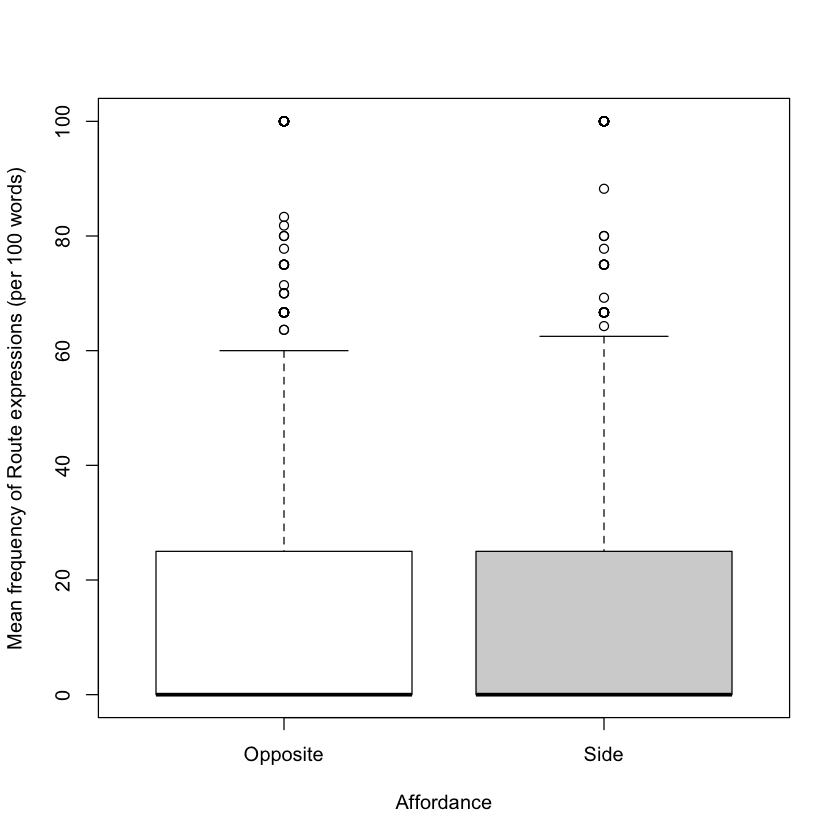

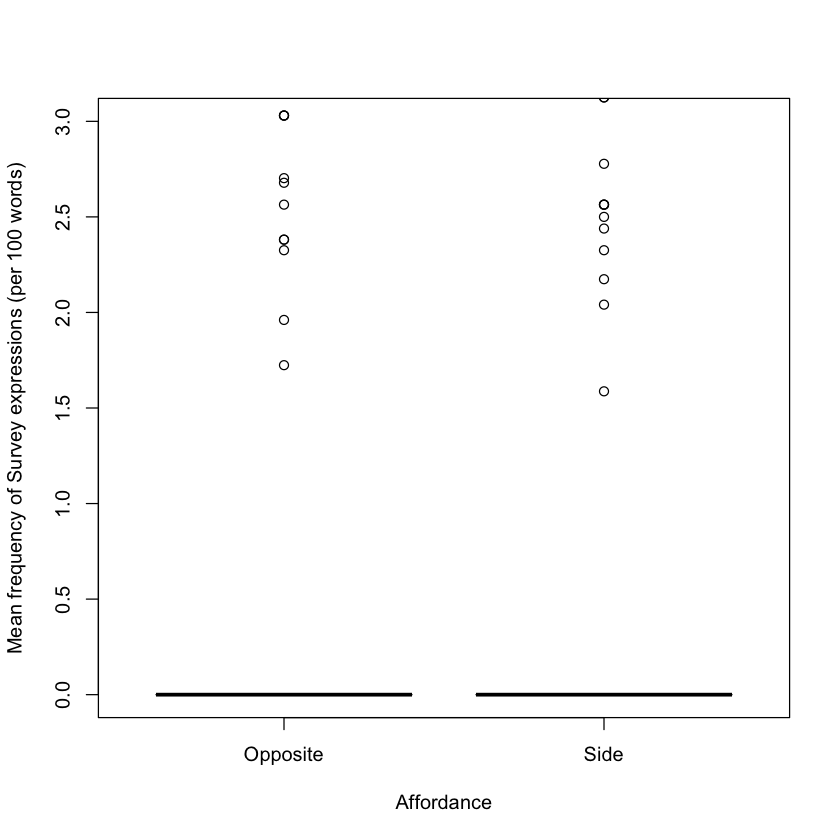

In [27]:
#Some for plotting

boxplot(SE_Route_freq ~ Affordance, 
        col=c("white", "lightgray"), 
        ylab='Mean frequency of Route expressions (per 100 words)', 
        allData) 

boxplot(SE_Allocentric_freq ~ Affordance, 
        col=c("white", "lightgray"), 
        ylab='Mean frequency of Survey expressions (per 100 words)', 
        ylim = c(0, 3),
        allData) 

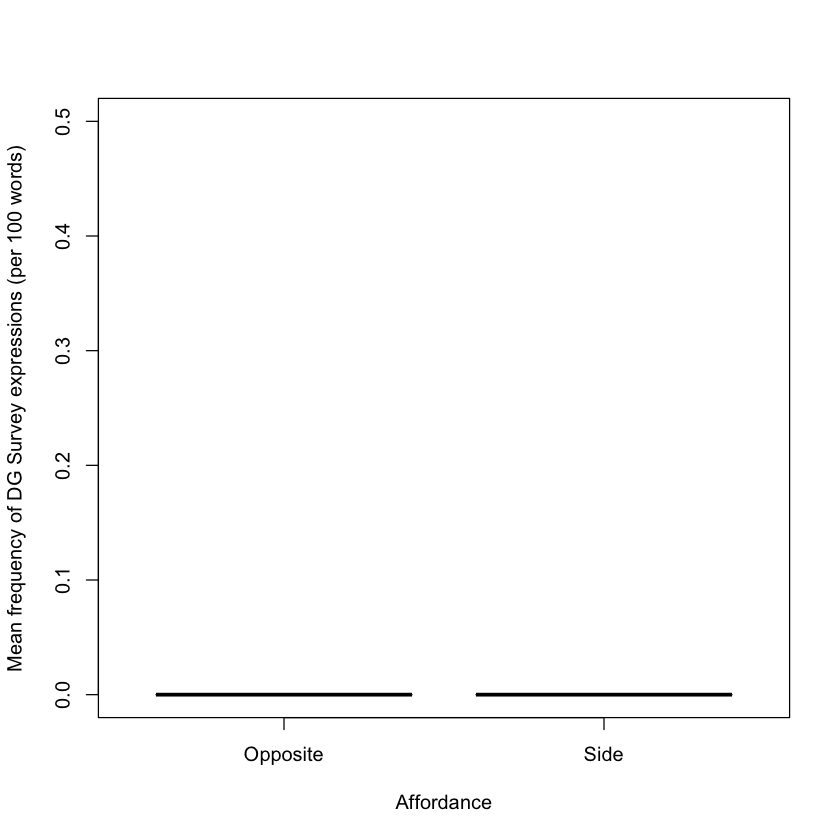

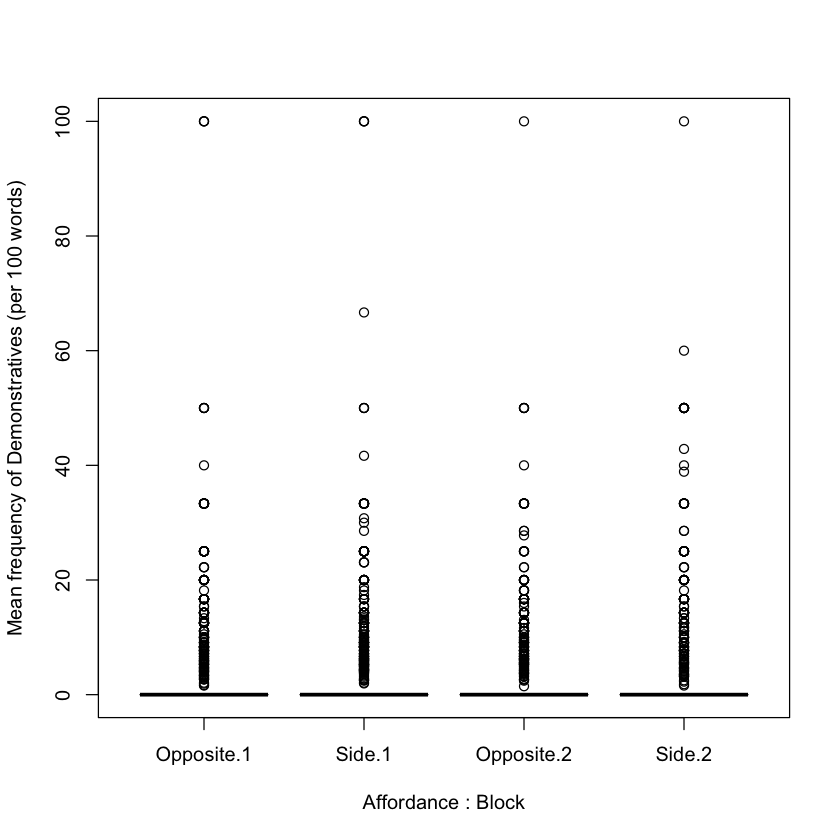

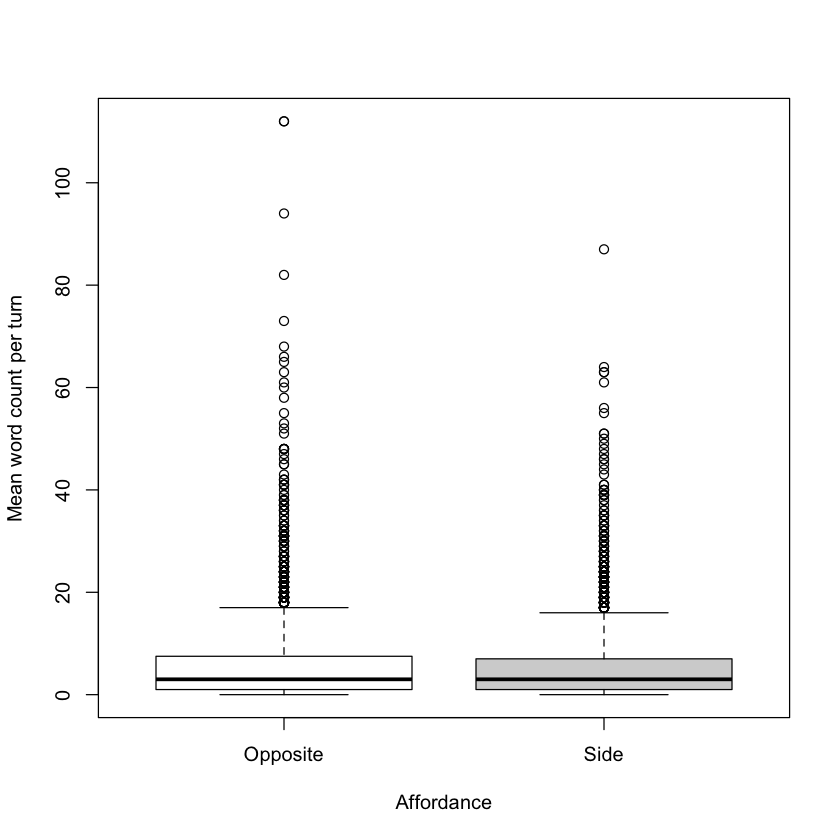

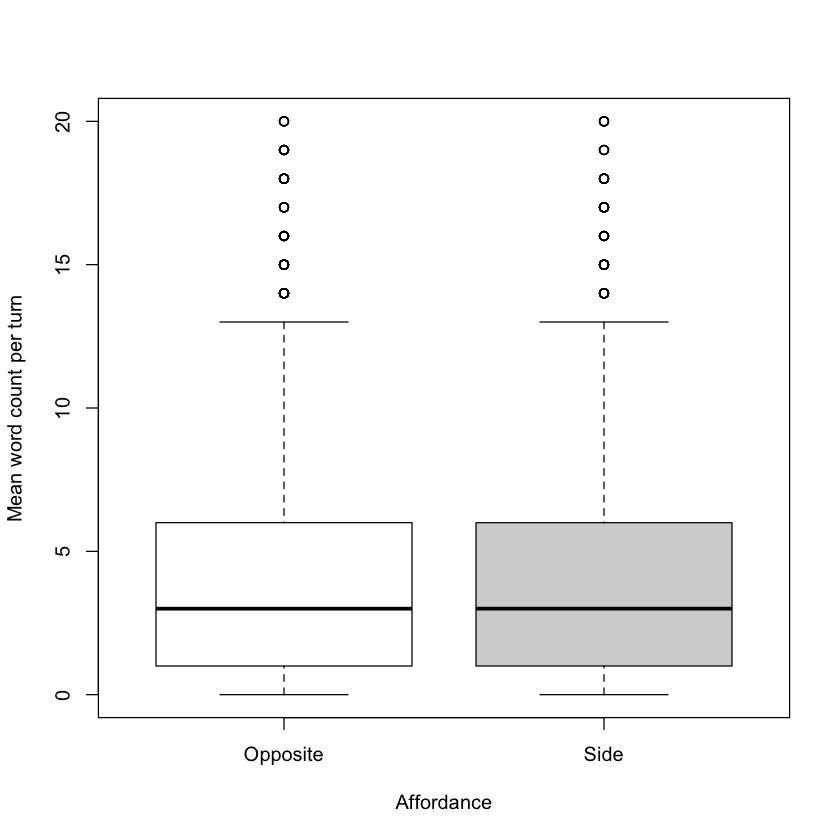

In [28]:
# Investigate outliers (100 expresisons per 100 words)
# which(grepl(100, allData$SE_Allocentric_freq))
# OK these are cases, for example, where the turn has 2 turns (e.g., "kato, aristera") and both are coded as survey

#plot the DG data only:
boxplot(SE_Allocentric_freq ~ Affordance, 
          col=c("white", "lightgray"), 
          ylab='Mean frequency of DG Survey expressions (per 100 words)',
          ylim = c(0, .5), 
          allData_DG) 


boxplot(Demonstr_freq ~ Affordance + Block, 
        col=c("white", "lightgray"), 
        ylab='Mean frequency of Demonstratives (per 100 words)', 
        allData) 

boxplot(WordCount ~ Affordance, 
        col=c("white", "lightgray"), 
        ylab='Mean word count per turn', 
        allData) 

#plot the DF data only:
boxplot(WordCount ~ Affordance, 
        col=c("white", "lightgray"), 
        ylab='Mean word count per turn',
        ylim = c(0,20),
        allData_DF) 

In [29]:
#####################
### DESCRIPTIVES ####
####################

pander(aggregate(SE_Route_freq~Affordance+Route,data=allData_DG,FUN=mean))
pander(aggregate(SE_Allocentric_freq~Affordance+Route,data=allData_DG,FUN=mean))
pander(aggregate(Demonstr_freq~Affordance+Route,data=allData_DG,FUN=mean))



| Affordance |  Route  | SE_Route_freq |
|:----------:|:-------:|:-------------:|
|  Opposite  | Ledras1 |     9.847     |
|    Side    | Ledras1 |     13.54     |
|  Opposite  | Ledras2 |     17.32     |
|    Side    | Ledras2 |     13.33     |



| Affordance |  Route  | SE_Allocentric_freq |
|:----------:|:-------:|:-------------------:|
|  Opposite  | Ledras1 |        2.338        |
|    Side    | Ledras1 |        1.274        |
|  Opposite  | Ledras2 |        1.109        |
|    Side    | Ledras2 |        1.033        |



| Affordance |  Route  | Demonstr_freq |
|:----------:|:-------:|:-------------:|
|  Opposite  | Ledras1 |     2.554     |
|    Side    | Ledras1 |     2.074     |
|  Opposite  | Ledras2 |     1.438     |
|    Side    | Ledras2 |     1.928     |



In [30]:
#Total spatial expressions
summtSETotal = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                              mean=mean(SE_Total_freq, na.rm = TRUE), sd= sd(SE_Total_freq, na.rm = TRUE), se=sd(SE_Total_freq, na.rm = TRUE)/sqrt(length(SE_Total_freq)))
summtSETotal

summtSETotal = dplyr::summarize(group_by(allData),
                                mean=mean(SE_Total_freq, na.rm = TRUE), sd= sd(SE_Total_freq, na.rm = TRUE), se=sd(SE_Total_freq, na.rm = TRUE)/sqrt(length(SE_Total_freq)))
summtSETotal

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,16.69231,23.29810,0.9801584
DF,Opposite,1,Ledras2,24.68962,29.34921,1.1022328
DF,Opposite,2,Ledras1,13.34162,21.00039,1.1631038
DF,Opposite,2,Ledras2,25.08223,32.00973,1.4188064
DF,Side,1,Ledras1,18.73651,28.69119,1.1202026
DF,Side,1,Ledras2,18.88006,28.51519,1.2948083
DF,Side,2,Ledras1,25.18906,29.56799,1.3495879
DF,Side,2,Ledras2,27.92313,30.60975,1.4044718
DG,Opposite,1,Ledras1,12.66022,18.26981,0.7652381


mean,sd,se
<dbl>,<dbl>,<dbl>
19.48739,26.32101,0.2867083


In [31]:
#Route expressions
summtRoute = dplyr::summarize(group_by(allData, Speaker, Affordance, Block, Route),
                          mean=mean(SE_Route_freq, na.rm = TRUE), sd= sd(SE_Route_freq, na.rm = TRUE), se=sd(SE_Route_freq, na.rm = TRUE)/sqrt(length(SE_Route_freq)))
summtRoute

summtRoute = dplyr::summarize(group_by(allData),
                              mean=mean(SE_Route_freq, na.rm = TRUE), sd= sd(SE_Route_freq, na.rm = TRUE), se=sd(SE_Route_freq, na.rm = TRUE)/sqrt(length(SE_Route_freq)))
summtRoute

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,15.000853,22.69143,0.9546357
DF,Opposite,1,Ledras2,22.064908,29.21201,1.0970801
DF,Opposite,2,Ledras1,10.400710,20.23436,1.1206778
DF,Opposite,2,Ledras2,20.338938,29.43458,1.3046650
DF,Side,1,Ledras1,17.078043,28.76612,1.1231284
DF,Side,1,Ledras2,15.321269,24.24656,1.1009796
DF,Side,2,Ledras1,19.888416,27.86136,1.2716914
DF,Side,2,Ledras2,25.485037,30.28138,1.3894051
DG,Opposite,1,Ledras1,9.317120,15.68756,0.6570797


mean,sd,se
<dbl>,<dbl>,<dbl>
16.16775,25.26929,0.2752522


In [32]:
#Survey expressions
summtSurvey = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                              mean=mean(SE_Allocentric_freq, na.rm = TRUE), sd= sd(SE_Allocentric_freq, na.rm = TRUE), se=sd(SE_Allocentric_freq, na.rm = TRUE)/sqrt(length(SE_Allocentric_freq)))
summtSurvey

summtSurvey = dplyr::summarize(group_by(allData),
                               mean=mean(SE_Allocentric_freq, na.rm = TRUE), sd= sd(SE_Allocentric_freq, na.rm = TRUE), se=sd(SE_Allocentric_freq, na.rm = TRUE)/sqrt(length(SE_Allocentric_freq)))
summtSurvey

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,1.2302542,5.252653,0.2209808
DF,Opposite,1,Ledras2,0.4870758,3.516837,0.1320776
DF,Opposite,2,Ledras1,1.4672186,5.147635,0.2851011
DF,Opposite,2,Ledras2,1.2815803,6.949366,0.3080252
DF,Side,1,Ledras1,0.4525876,2.927524,0.1143006
DF,Side,1,Ledras2,0.9704513,4.723070,0.2144636
DF,Side,2,Ledras1,1.8842062,8.867213,0.4047311
DF,Side,2,Ledras2,0.6509472,4.358932,0.2000015
DG,Opposite,1,Ledras1,2.3020793,8.064148,0.3377700


mean,sd,se
<dbl>,<dbl>,<dbl>
1.195355,5.439914,0.05925565


In [33]:
#Neutral expressions
summtNeutral = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                               mean=mean(SE_Neutral_freq, na.rm = TRUE), sd= sd(SE_Neutral_freq, na.rm = TRUE), se=sd(SE_Neutral_freq, na.rm = TRUE)/sqrt(length(SE_Neutral_freq)))
summtNeutral

summtNeutral = dplyr::summarize(group_by(allData),
                                mean=mean(SE_Neutral_freq, na.rm = TRUE), sd= sd(SE_Neutral_freq, na.rm = TRUE), se=sd(SE_Neutral_freq, na.rm = TRUE)/sqrt(length(SE_Neutral_freq)))
summtNeutral

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,0.4612011,3.143336,0.1322411
DF,Opposite,1,Ledras2,2.1376369,7.297324,0.2740568
DF,Opposite,2,Ledras1,1.4736868,6.132564,0.3396513
DF,Opposite,2,Ledras2,3.4617158,10.921100,0.4840693
DF,Side,1,Ledras1,1.2058836,4.977801,0.1943505
DF,Side,1,Ledras2,2.5883379,12.211555,0.5544981
DF,Side,2,Ledras1,3.4164376,8.450650,0.3857176
DF,Side,2,Ledras2,1.7871501,6.971339,0.3198670
DG,Opposite,1,Ledras1,1.0410226,5.568376,0.2332336


mean,sd,se
<dbl>,<dbl>,<dbl>
2.124283,7.963672,0.08674633


In [34]:
#Landmark references
summtLandmarks = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                                mean=mean(Landmark_freq, na.rm = TRUE), sd= sd(Landmark_freq, na.rm = TRUE), se=sd(Landmark_freq, na.rm = TRUE)/sqrt(length(Landmark_freq)))
summtLandmarks

summtLandmarks = dplyr::summarize(group_by(allData),
                                  mean=mean(Landmark_freq, na.rm = TRUE), sd= sd(Landmark_freq, na.rm = TRUE), se=sd(Landmark_freq, na.rm = TRUE)/sqrt(length(Landmark_freq)))
summtLandmarks

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,3.533332,10.946804,0.4605355
DF,Opposite,1,Ledras2,2.870187,7.879349,0.2959152
DF,Opposite,2,Ledras1,2.202829,9.953620,0.5512800
DF,Opposite,2,Ledras2,1.254949,5.553056,0.2461349
DF,Side,1,Ledras1,2.824422,10.491068,0.4096074
DF,Side,1,Ledras2,2.447365,9.066895,0.4117065
DF,Side,2,Ledras1,1.141926,5.340967,0.2437807
DF,Side,2,Ledras2,1.627958,6.147718,0.2820766
DG,Opposite,1,Ledras1,4.962326,12.731965,0.5332833


mean,sd,se
<dbl>,<dbl>,<dbl>
2.689906,9.06983,0.09879544


In [35]:
#Demonstratives 
summtDemonstratives = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                                  mean=mean(Demonstr_freq, na.rm = TRUE), sd= sd(Demonstr_freq, na.rm = TRUE), se=sd(Demonstr_freq, na.rm = TRUE)/sqrt(length(Demonstr_freq)))
summtDemonstratives

summtDemonstratives = dplyr::summarize(group_by(allData),
                                       mean=mean(Demonstr_freq, na.rm = TRUE), sd= sd(Demonstr_freq, na.rm = TRUE), se=sd(Demonstr_freq, na.rm = TRUE)/sqrt(length(Demonstr_freq)))
summtDemonstratives

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,1.7422407,6.759884,0.2843905
DF,Opposite,1,Ledras2,0.5791885,3.201381,0.1202304
DF,Opposite,2,Ledras1,1.2923677,5.518127,0.3056208
DF,Opposite,2,Ledras2,0.8697964,4.256849,0.1886815
DF,Side,1,Ledras1,0.9656471,4.633882,0.1809227
DF,Side,1,Ledras2,1.5429079,7.621888,0.3460921
DF,Side,2,Ledras1,1.0861404,5.446085,0.2485786
DF,Side,2,Ledras2,1.8546283,8.156997,0.3742687
DG,Opposite,1,Ledras1,2.3010060,6.879223,0.2881389


mean,sd,se
<dbl>,<dbl>,<dbl>
1.585601,6.273261,0.06833309


In [36]:
#Ambiguous expressions 
summtAmbig = dplyr::summarize(group_by(allData),
                                       mean=mean(SE_Ambig_freq, na.rm = TRUE), sd= sd(SE_Ambig_freq, na.rm = TRUE), se=sd(SE_Ambig_freq, na.rm = TRUE)/sqrt(length(SE_Ambig_freq)))
summtAmbig

summtAmbig = dplyr::summarize(group_by(allData),
                              mean=mean(SE_Ambig_freq, na.rm = TRUE), sd= sd(SE_Ambig_freq, na.rm = TRUE), se=sd(SE_Ambig_freq, na.rm = TRUE)/sqrt(length(SE_Ambig_freq)))
summtAmbig

mean,sd,se
<dbl>,<dbl>,<dbl>
0.5168208,5.985812,0.06520198


mean,sd,se
<dbl>,<dbl>,<dbl>
0.5168208,5.985812,0.06520198


In [37]:
#Words per turn
summtWords = dplyr::summarize(group_by(allData,Speaker, Affordance, Block, Route),
                                       mean=mean(WordCount, na.rm = TRUE), sd= sd(WordCount, na.rm = TRUE), se=sd(WordCount, na.rm = TRUE)/sqrt(length(WordCount)))
summtWords

`summarise()` has grouped output by 'Speaker', 'Affordance', 'Block'. You can override using the `.groups` argument.



Speaker,Affordance,Block,Route,mean,sd,se
<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
DF,Opposite,1,Ledras1,5.384071,6.241257,0.2625717
DF,Opposite,1,Ledras2,4.863188,5.574322,0.2093481
DF,Opposite,2,Ledras1,4.539877,5.384588,0.2982248
DF,Opposite,2,Ledras2,4.388998,5.634710,0.2497541
DF,Side,1,Ledras1,4.068598,4.900835,0.1913455
DF,Side,1,Ledras2,4.282474,4.649336,0.2111155
DF,Side,2,Ledras1,4.804167,5.811153,0.2652416
DF,Side,2,Ledras2,3.934737,3.938605,0.1807156
DG,Opposite,1,Ledras1,6.980702,8.916995,0.3734918


In [38]:
# Exploratory analyses for body switchers
# Focus on the 2nd block descriptives, since that's when the switch happens 
summtRoute_BodySwitch = dplyr::summarize(group_by(allData, Speaker, Block,BodySwitch, Affordance),
                              mean=mean(SE_Route_freq, na.rm = TRUE), sd= sd(SE_Route_freq, na.rm = TRUE), se=sd(SE_Route_freq, na.rm = TRUE)/sqrt(length(SE_Route_freq)))
print.data.frame(summtRoute_BodySwitch)

summtSurvey_BodySwitch = dplyr::summarize(group_by(allData, Speaker, Block,BodySwitch, Affordance),
                               mean=mean(SE_Allocentric_freq, na.rm = TRUE), sd= sd(SE_Allocentric_freq, na.rm = TRUE), se=sd(SE_Allocentric_freq, na.rm = TRUE)/sqrt(length(SE_Allocentric_freq)))
print.data.frame(summtSurvey_BodySwitch)

`summarise()` has grouped output by 'Speaker', 'Block', 'BodySwitch'. You can override using the `.groups` argument.



   Speaker Block BodySwitch Affordance      mean       sd        se
1       DF     1  nonswitch   Opposite 16.764519 24.72243 0.7615016
2       DF     1  nonswitch       Side 17.107977 27.53331 0.9974266
3       DF     1     switch   Opposite 29.157665 32.89909 2.2180562
4       DF     1     switch       Side 14.883411 25.92041 1.3314421
5       DF     2  nonswitch   Opposite 14.438198 24.60424 0.9881299
6       DF     2  nonswitch       Side 22.498604 28.84430 0.9864542
7       DF     2     switch   Opposite 22.493676 31.29938 2.1346003
8       DF     2     switch       Side 23.632673 32.05617 3.2056168
9       DG     1  nonswitch   Opposite 12.523802 20.74964 0.6376209
10      DG     1  nonswitch       Side 11.221199 18.68621 0.6751601
11      DG     1     switch   Opposite 18.646079 29.18885 1.9679120
12      DG     1     switch       Side 16.394961 27.64815 1.4201898
13      DG     2  nonswitch   Opposite 13.647953 21.47585 0.8597221
14      DG     2  nonswitch       Side 14.601289

`summarise()` has grouped output by 'Speaker', 'Block', 'BodySwitch'. You can override using the `.groups` argument.



   Speaker Block BodySwitch Affordance      mean       sd         se
1       DF     1  nonswitch   Opposite 0.9916925 4.813973 0.14828025
2       DF     1  nonswitch       Side 0.4112359 2.457762 0.08903532
3       DF     1     switch   Opposite 0.0000000 0.000000 0.00000000
4       DF     1     switch       Side 1.1635765 5.484868 0.28173876
5       DF     2  nonswitch   Opposite 1.2075759 6.293310 0.25274540
6       DF     2  nonswitch       Side 1.4068889 7.437718 0.25436459
7       DF     2     switch   Opposite 1.7676902 6.379263 0.43506214
8       DF     2     switch       Side 0.2369213 1.690202 0.16902022
9       DG     1  nonswitch   Opposite 1.7336162 6.663936 0.20477779
10      DG     1  nonswitch       Side 0.9010056 3.895094 0.14073546
11      DG     1     switch   Opposite 0.4220564 2.285717 0.15410304
12      DG     1     switch       Side 1.6725294 5.099019 0.26191900
13      DG     2  nonswitch   Opposite 1.5245428 5.602600 0.22428351
14      DG     2  nonswitch       

In [39]:
#######################################################
## Some descriptives about the aggregated Dialogues ##
#######################################################

#Descriptives of turns in Dialogue
min(allDialogues$finalTurn)
max(allDialogues$finalTurn)
mean(allDialogues$finalTurn)
sd(allDialogues$finalTurn)

[1] 34

[1] 324

[1] 131.6875

[1] 67.02993

In [40]:
# INSERT TO CORRECT

valid_column_names <- make.names(names=names(allDialogues), unique=TRUE, allow_ = TRUE)
names(allDialogues) <- valid_column_names

In [41]:
#Total Turns in Dialogue
summtTotalTurns = dplyr::summarize(group_by(allDialogues, Block),
                              mean=mean(finalTurn, na.rm = TRUE), sd= sd(finalTurn, na.rm = TRUE), se=sd(finalTurn, na.rm = TRUE)/sqrt(length(finalTurn)))
summtTotalTurns

Block,mean,sd,se
<fct>,<dbl>,<dbl>,<dbl>
1,151.2188,71.63336,12.66311
2,112.1562,56.67514,10.01884


In [42]:
#Total Words in Dialogue
summtTotalWords = dplyr::summarize(group_by(allDialogues, Block),
                                   mean=mean(TotalWords, na.rm = TRUE), sd= sd(TotalWords, na.rm = TRUE), se=sd(TotalWords, na.rm = TRUE)/sqrt(length(TotalWords)))
summtTotalWords

Block,mean,sd,se
<fct>,<dbl>,<dbl>,<dbl>
1,895.5000,414.4027,73.25674
2,636.4688,373.7750,66.07471


In [43]:
##############################################################################
## Comparing route vs. survey frequency aggregated by subs in allDialogues ##
##############################################################################

# both partners use more route than survey expressions

# Comparison of Route vs. Survey frequency by Affordance condition
t_tests <- allDialogues %>%
  group_by(Affordance) %>%
  do(tidy(t.test(.$SE_Route_freq,
              .$SE_Survey_freq,
              mu = 0,
              alt = "two.sided",
              paired= TRUE)))
t_tests
print.data.frame(t_tests)

t.test(allDialogues$SE_Route_freq, allDialogues$SE_Survey_freq, paired = TRUE) 
t.test(allDialogues$SE_Route_freq_DG, allDialogues$SE_Survey_freq_DG, paired = TRUE)
t.test(allDialogues$SE_Route_freq_DF, allDialogues$SE_Survey_freq_DF, paired = TRUE)

Affordance,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Opposite,12.13648,14.13717,4.637272e-15,31,10.38560,13.88736,Paired t-test,two.sided
Side,13.16881,16.46918,7.007312e-17,31,11.53801,14.79962,Paired t-test,two.sided


  Affordance estimate statistic      p.value parameter conf.low conf.high
1   Opposite 12.13648  14.13717 4.637272e-15        31 10.38560  13.88736
2       Side 13.16881  16.46918 7.007312e-17        31 11.53801  14.79962
         method alternative
1 Paired t-test   two.sided
2 Paired t-test   two.sided



	Paired t-test

data:  allDialogues$SE_Route_freq and allDialogues$SE_Survey_freq
t = 21.609, df = 63, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 11.48254 13.82275
sample estimates:
mean of the differences 
               12.65265 



	Paired t-test

data:  allDialogues$SE_Route_freq_DG and allDialogues$SE_Survey_freq_DG
t = 16.614, df = 63, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.761176 11.157019
sample estimates:
mean of the differences 
               9.959098 



	Paired t-test

data:  allDialogues$SE_Route_freq_DF and allDialogues$SE_Survey_freq_DF
t = 17.941, df = 63, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 15.20474 19.01645
sample estimates:
mean of the differences 
               17.11059 


In [44]:
# Linear mixed effect models for Total Turns and Words

# contrast structure

allDialogues <- within(allDialogues, {
  
  # Factor 1: Affordance
  Affordance.sideVoppo <- ifelse( Affordance=="Side", 1/2, 
                                  ifelse( Affordance=="Opposite", -1/2, NA ) ) 
  
  # Factor 2: Block
  Block.1V2 <- ifelse( Block=="1", 1/2, 
                       ifelse( Block=="2", -1/2, NA ) ) 
  
  
  # Factor 3: Route
  Route.L1VL2 <- ifelse( Route=="Ledras1", 1/2, 
                         ifelse( Route=="Ledras2", -1/2, NA ) ) 
  
  # Factor 4: DG_Gender
  DG_Gender.mVf <- ifelse( DG_Gender=="male", 1/2, 
                         ifelse( DG_Gender=="female", -1/2, NA ) ) 
  
  # Factor 5: DF_Gender
  DF_Gender.mVf <- ifelse( DF_Gender=="male", 1/2, 
                           ifelse( DF_Gender=="female", -1/2, NA ) )
  
} )


TotalTurns.Model <- lmer(finalTurn~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + (1 | Pair),data=allDialogues)
summary(TotalTurns.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: finalTurn ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 639.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.59738 -0.46193 -0.09054  0.37396  2.10020 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 1974     44.43   
 Residual             2479     49.79   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                131.7857    10.1002  28.0000  13.048
Affordance.sideVoppo                         0.3175    12.5460  28.0000   0.025
Block.1V2                                   38.7222    12.5460  28.0000   3.086
Route.L1VL2                                 -9.5397    12.5460  28.0000  -0.760
Affordance.sideVoppo:Block.1V2             -35.4444    40.4008  2

In [45]:
TotalWords.Model <- lmer(TotalWords~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + (1 | Pair),data=allDialogues)
summary(TotalWords.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TotalWords ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 843.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4694 -0.4773 -0.1552  0.3802  2.0530 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 77541    278.5   
 Residual             91926    303.2   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error      df t value
(Intercept)                                  769.07      62.62   28.00  12.282
Affordance.sideVoppo                         -38.55      76.40   28.00  -0.505
Block.1V2                                    261.76      76.40   28.00   3.426
Route.L1VL2                                  -15.84      76.40   28.00  -0.207
Affordance.sideVoppo:Block.1V2              -108.20     250.46   28.00  -0.432


In [46]:
##// Effect Size

r.squaredGLMM(TotalTurns.Model)[1]
r.squaredGLMM(TotalTurns.Model)[2] #we report this

r.squaredGLMM(TotalWords.Model)[1]
r.squaredGLMM(TotalWords.Model)[2] #we report this

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


[1] 0.1072207

[1] 0.5029673

[1] 0.1039022

[1] 0.5139196

In [47]:
# Exploratory: 
# Adding gender as a covariate

TotalTurns.Model_wGender <- lmer(finalTurn~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DG_Gender + DF_Gender + (1 | Pair),data=allDialogues)
summary(TotalTurns.Model_wGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: finalTurn ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DG_Gender + DF_Gender + (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 620.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.68477 -0.52835 -0.08876  0.35890  2.07565 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 1936     44.00   
 Residual             2479     49.79   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                134.6294    12.6688  26.0000  10.627
Affordance.sideVoppo                         0.3175    12.5460  28.0000   0.025
Block.1V2                                   38.7222    12.5460  28.0000   3.086
Route.L1VL2                                 -9.5397    12.5460  28.0000  -0.760
DG_Gendermale                            

In [48]:
TotalWords.Model_wGender <- lmer(TotalWords~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DG_Gender + DF_Gender +   (1 | Pair),data=allDialogues)
summary(TotalWords.Model_wGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TotalWords ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DG_Gender + DF_Gender + (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 818

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4891 -0.4622 -0.1479  0.3228  2.0415 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 82091    286.5   
 Residual             91926    303.2   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error      df t value
(Intercept)                                  737.46      80.45   26.00   9.167
Affordance.sideVoppo                         -38.55      76.40   28.00  -0.505
Block.1V2                                    261.76      76.40   28.00   3.426
Route.L1VL2                                  -15.84      76.40   28.00  -0.207
DG_Gendermale                                164.12     1

In [49]:
# Adding pair familiarity as a covariate 

TotalTurns.Model_Familiarity <- lmer(finalTurn~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + PairFamiliarity + (1 | Pair),data=allDialogues)
summary(TotalTurns.Model_Familiarity)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: finalTurn ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    PairFamiliarity + (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 600.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5954 -0.5149 -0.1313  0.3378  2.1201 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 2048     45.26   
 Residual             2479     49.79   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                120.2749    28.6578  24.0000   4.197
Affordance.sideVoppo                         0.3175    12.5460  28.0000   0.025
Block.1V2                                   38.7222    12.5460  28.0000   3.086
Route.L1VL2                                 -9.5397    12.5460  28.0000  -0.760
PairFamiliaritycouple                       66.5149    57

In [50]:
TotalWords.Model_Familiarity <- lmer(TotalWords~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + PairFamiliarity + (1 | Pair),data=allDialogues)
summary(TotalWords.Model_Familiarity)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TotalWords ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    PairFamiliarity + (1 | Pair)
   Data: allDialogues

REML criterion at convergence: 790.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4564 -0.4417 -0.1551  0.3762  1.9943 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 85433    292.3   
 Residual             91926    303.2   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error      df t value
(Intercept)                                  677.81     181.17   24.00   3.741
Affordance.sideVoppo                         -38.55      76.40   28.00  -0.505
Block.1V2                                    261.76      76.40   28.00   3.426
Route.L1VL2                                  -15.84      76.40   28.00  -0.207
PairFamiliaritycouple                        493.68     361.9

In [51]:
######################################
###### LMERs on DG data ONLY ########
#####################################

#Check variable types
str(allData_DG)

'data.frame':	4223 obs. of  26 variables:
 $ Pair                    : Factor w/ 32 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Session                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Route                   : Factor w/ 2 levels "Ledras1","Ledras2": 1 1 1 1 1 1 1 1 1 1 ...
 $ Affordance              : Factor w/ 2 levels "Opposite","Side": 2 2 2 2 2 2 2 2 2 2 ...
 $ Turn                    : int  1 3 5 7 9 11 13 15 17 19 ...
 $ Speaker                 : chr  "DG" "DG" "DG" "DG" ...
 $ SpeechContent           : chr  "το λοιπόν / είσαι / στη Λήδρας / " "εντάξει ? / τζιαι είναι το παλιό το Flo Café στ’ αριστερά σου / " "στην αρχή / πού’ταν το Flo Café κάπου στη μέση " "πού’ταν το Flo Café {εντάξει} {πα*} πάνω στο χάρτη σου ?" ...
 $ SpatialExpression       : int  0 0 2 1 2 1 2 1 2 1 ...
 $ SE_Route                : int  0 0 0 0 0 1 2 1 2 1 ...
 $ SE_Allocentric          : int  0 0 0 1 1 0 0 0 0 0 ...
 $ SE_Neutral              : int  0 0 2 0 1 0 0 0 0 0 ...
 $ Ambiguous        

In [52]:
################################
## Set-up contrast structure ##
################################

allData_DG <- within(allData_DG, {
  
  # Factor 1: Affordance
  Affordance.sideVoppo <- ifelse( Affordance=="Side", 1/2, 
                                  ifelse( Affordance=="Opposite", -1/2, NA ) ) 
  
  # Factor 2: Block
  Block.1V2 <- ifelse( Block=="1", 1/2, 
                       ifelse( Block=="2", -1/2, NA ) ) 
  
  
  # Factor 3: Route
  Route.L1VL2 <- ifelse( Route=="Ledras1", 1/2, 
                         ifelse( Route=="Ledras2", -1/2, NA ) ) 
  
  # Factor 4: Body Switch (for exploratory analyses)
  BodySwitch.yesVno <- ifelse( BodySwitch=="switch", 1/2, 
                         ifelse( BodySwitch=="nonswitch", -1/2, NA ) ) 
  
  
} )

In [53]:
##########################################
## Spatial expressions frequency model ##

### NOT Reported ###

SE_Total_DG.model = lmer(SE_Total_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                         + (1 | Pair) 
                         + (0 + Affordance.sideVoppo | Pair),
                         #+ (0 + Block.1V2 | Pair),
                         #+ (0 + Route.L1VL2 | Pair),
                         #+ (0 + centered_Turn | Pair),
                         #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                         data = allData_DG, 
                         REML=FALSE)

In [54]:
#coef(SE_Total_DG.model)
summary(SE_Total_DG.model)
#print('Frequency of total spatial expressions:'); pander(print_stats(SE_Total_DG.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Total_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 37241.7  37317.4 -18608.8  37217.7     4071 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5125 -0.6018 -0.2930  0.3531  3.8970 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           16.70    4.086  
 Pair.1   Affordance.sideVoppo  44.14    6.644  
 Residual                      520.84   22.822  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                  17.59256    0.82912   33.06327
Affordance.sideVoppo                         -0.21413    1.42261   29.59526
Block.1V2                              

In [55]:
r.squaredGLMM(SE_Total_DG.model)[1]
r.squaredGLMM(SE_Total_DG.model)[2] #we report this

[1] 0.01883422

[1] 0.06843548

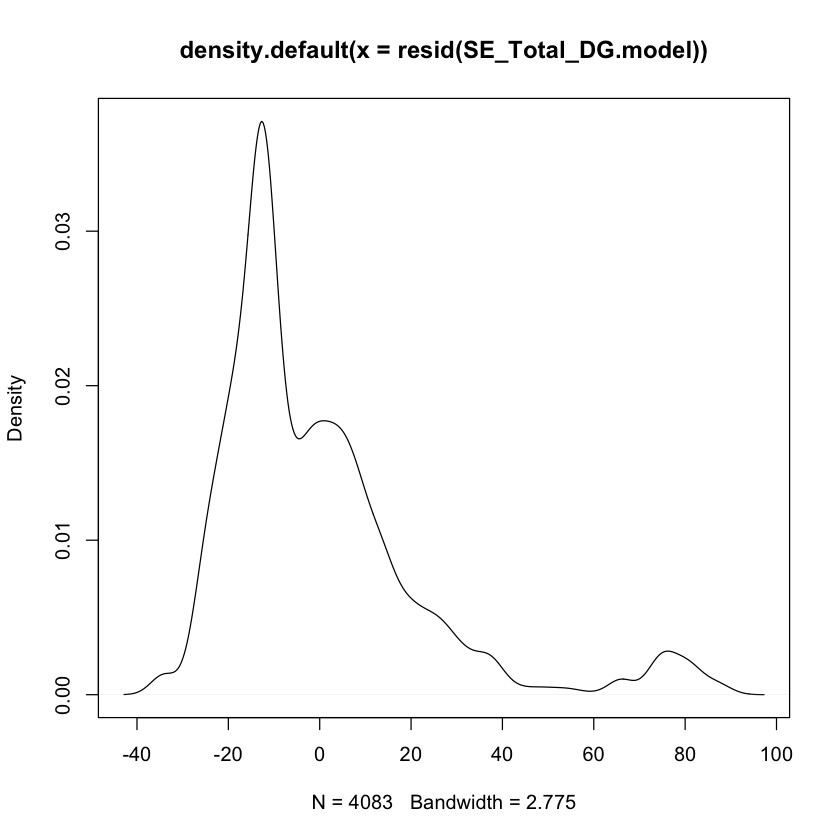

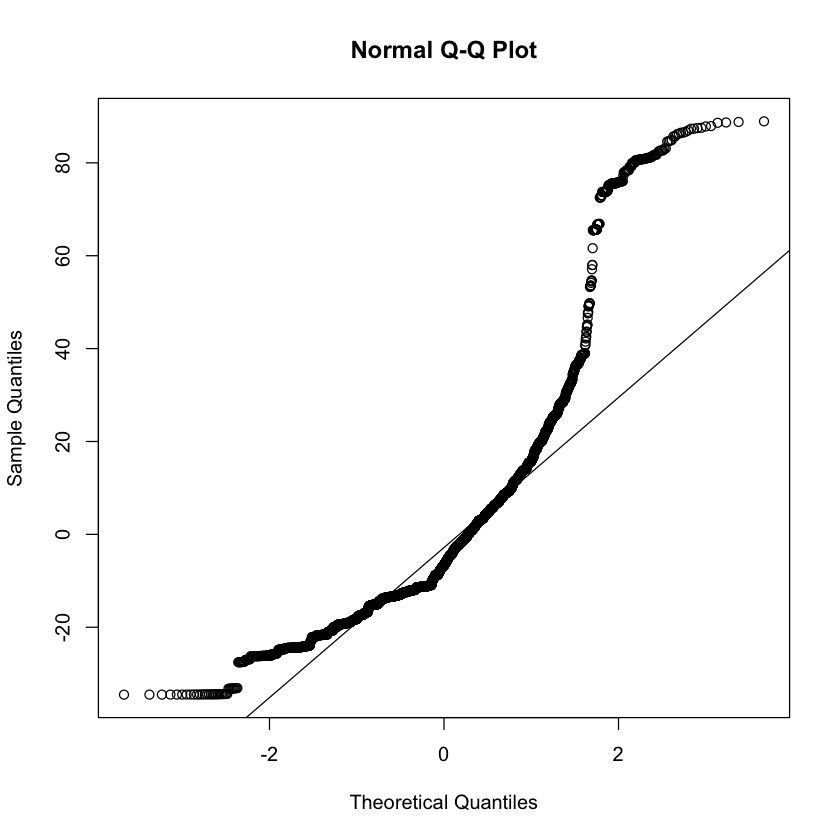

In [56]:
#check distribution of residuals
plot(density(resid(SE_Total_DG.model))) #does this look approximately normal
qqnorm(resid(SE_Total_DG.model)) #check if they fall on a straight line
qqline(resid(SE_Total_DG.model)) 

In [57]:
########################################
## Route expressions frequency model ##

SE_Route_DG.model = lmer(SE_Route_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                       + (1 | Pair) 
                       + (0 + Affordance.sideVoppo | Pair)
                       + (0 + Block.1V2 | Pair),
                       #+ (0 + Route.L1VL2 | Pair),
                       #+ (0 + centered_Turn | Pair),
                       #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                       data = allData_DG, 
                       REML=FALSE)
#coef(SE_Route_DG.model)
summary(SE_Route_DG.model)
#print('Frequency of Route expressions:'); pander(print_stats(SE_Route_DG.model)) 

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message:
“Model failed to converge with 1 negative eigenvalue: -2.9e-02”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Route_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |  
    Pair) + (0 + Block.1V2 | Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 36917.4  36999.5 -18445.7  36891.4     4070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3170 -0.5772 -0.3504  0.2766  4.1741 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           13.953   3.735  
 Pair.1   Affordance.sideVoppo   1.426   1.194  
 Pair.2   Block.1V2             30.686   5.540  
 Residual                      481.740  21.949  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                  13.87797    0.76662   32.87414
Affordance.sideVoppo                    

In [58]:
r.squaredGLMM(SE_Route_DG.model)[1]
r.squaredGLMM(SE_Route_DG.model)[2] #we report this

[1] 0.01978464

[1] 0.06255867

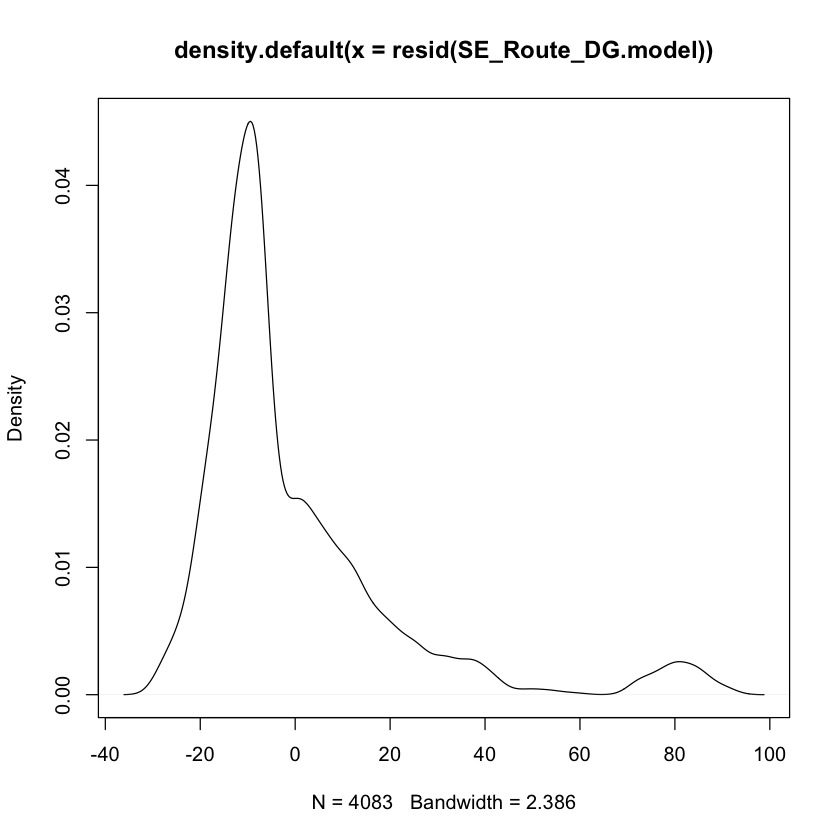

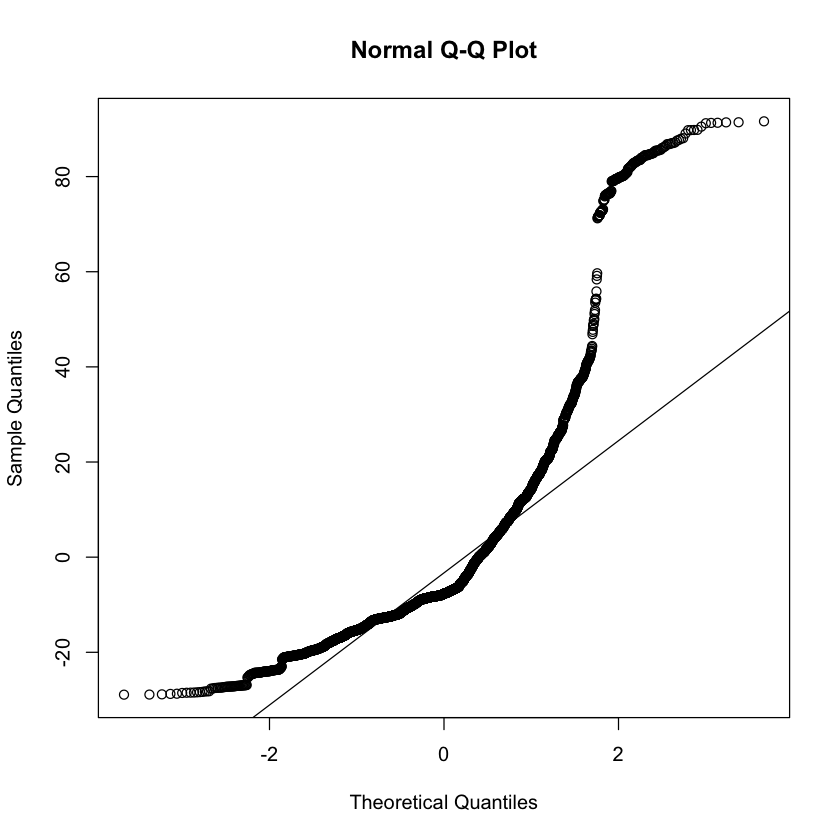

In [59]:
#check distribution of residuals
plot(density(resid(SE_Route_DG.model))) #does this look approximately normal
qqnorm(resid(SE_Route_DG.model)) #check if they fall on a straight line
qqline(resid(SE_Route_DG.model)) 

In [60]:
#########################################
##  Survey expressions frequency model ##

SE_Survey_DG.model = lmer(SE_Allocentric_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                        + (1 | Pair) 
                        + (0 + Affordance.sideVoppo | Pair)
                        + (0 + Block.1V2 | Pair)
                        + (0 + Route.L1VL2 | Pair) 
                        + (0 + centered_Turn | Pair), 
                        #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                        data = allData_DG, 
                        REML=FALSE)
#coef(SE_Survey_DG.model)
summary(SE_Survey_DG.model)
#print('Frequency of Survey expressions:'); pander(print_stats(SE_Survey_DG.model)) 

boundary (singular) fit: see ?isSingular



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
SE_Allocentric_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |  
    Pair) + (0 + Block.1V2 | Pair) + (0 + Route.L1VL2 | Pair) +  
    (0 + centered_Turn | Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 25366.9  25461.6 -12668.5  25336.9     4068 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0752 -0.3246 -0.1878 -0.0717 17.9480 

Random effects:
 Groups   Name                 Variance  Std.Dev. 
 Pair     (Intercept)          1.025e+00 1.0126198
 Pair.1   Affordance.sideVoppo 0.000e+00 0.0000000
 Pair.2   Block.1V2            0.000e+00 0.0000000
 Pair.3   Route.L1VL2          1.022e-07 0.0003197
 Pair.4   centered_Turn        2.180e-01 0.4668598
 Residual                      2.848e+01 5.3370863
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
           

In [61]:
r.squaredGLMM(SE_Survey_DG.model)[1]
r.squaredGLMM(SE_Survey_DG.model)[2] #we report this

[1] 0.01104784

[1] 0.05237239

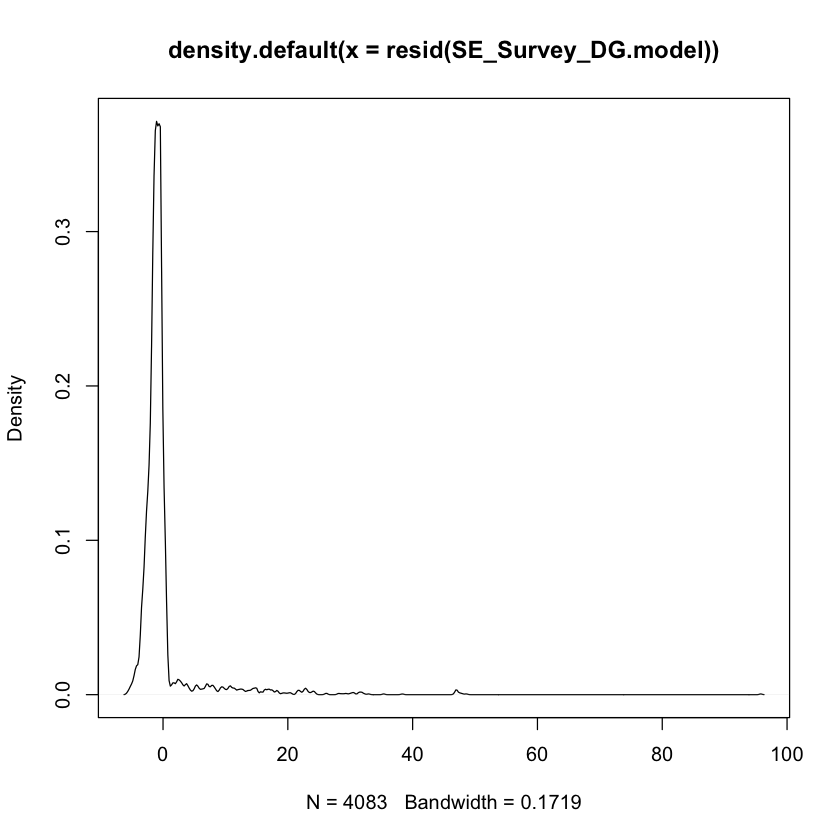

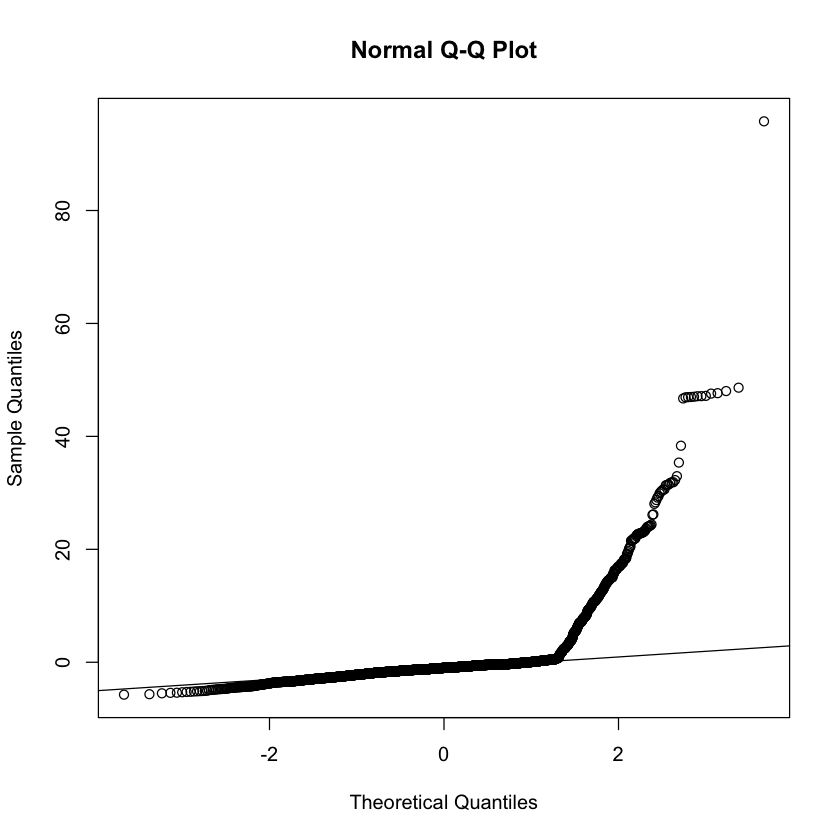

In [62]:
#check distribution of residuals
plot(density(resid(SE_Survey_DG.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(SE_Survey_DG.model)) #check if they fall on a straight line
qqline(resid(SE_Survey_DG.model)) 

In [63]:
###########################################
##  Neutral expressions frequency model ##

SE_Neutral_DG.model = lmer(SE_Neutral_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                         + (1 | Pair) 
                         + (0 + Affordance.sideVoppo | Pair),
                         #+ (0 + Block.1V2 | Pair),
                         #+ (0 + Route.L1VL2 | Pair), 
                         #+ (0 + centered_Turn | Pair), #did not converge
                         #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                         data = allData_DG, 
                         REML=FALSE)
#coef(SE_Neutral_DG.model)
summary(SE_Neutral_DG.model)
#print('Frequency of Neutral expressions:'); pander(print_stats(SE_Neutral_DG.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Neutral_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 28513.1  28588.9 -14244.5  28489.1     4071 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9485 -0.3391 -0.1865 -0.1178 12.4374 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           1.316   1.147   
 Pair.1   Affordance.sideVoppo  3.263   1.806   
 Residual                      61.707   7.855   
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                   2.2644     0.2451   33.5796
Affordance.sideVoppo                          0.2988     0.4193   30.7581
Block.1V2                                  

In [64]:
r.squaredGLMM(SE_Neutral_DG.model)[1]
r.squaredGLMM(SE_Neutral_DG.model)[2] #we report this

[1] 0.01065216

[1] 0.04368359

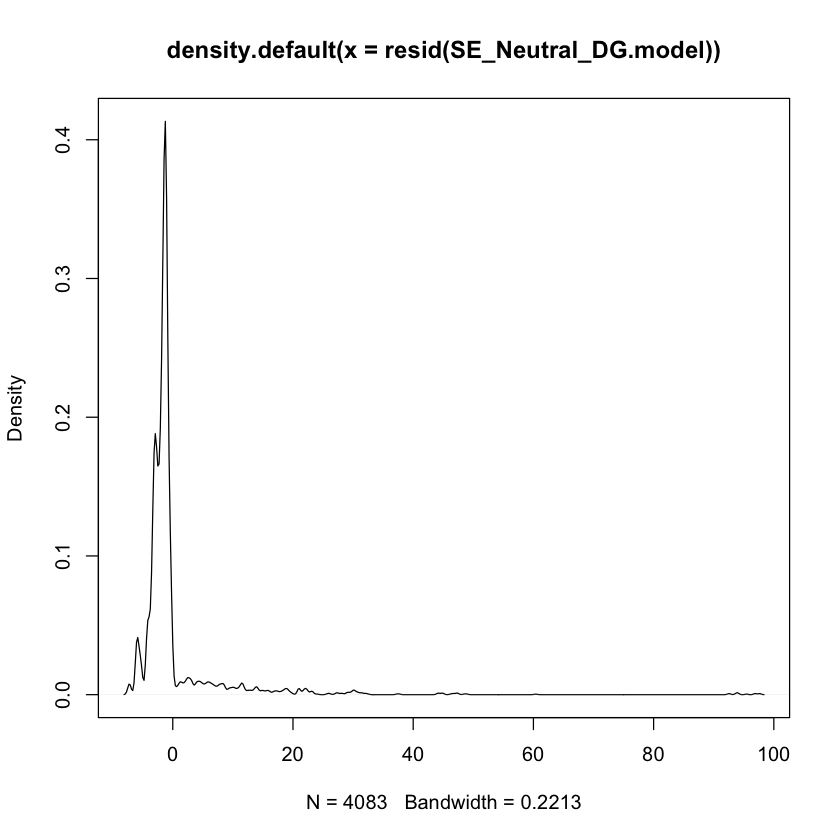

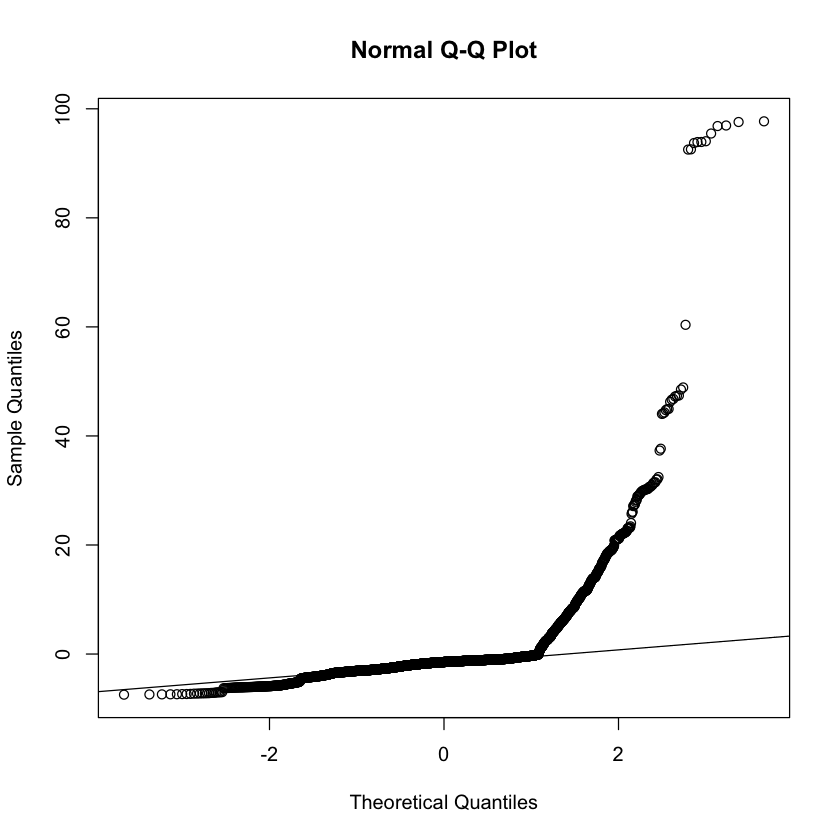

In [65]:
#check distribution of residuals
plot(density(resid(SE_Neutral_DG.model))) #This does not look normal -- very positively skewed. I tried log-transforming and adding a small value to the DV but does not help
qqnorm(resid(SE_Neutral_DG.model)) #check if they fall on a straight line
qqline(resid(SE_Neutral_DG.model)) 

In [66]:
######################################
##  Demonstratives frequency model ##

Demonstratives_DG.model = lmer(Demonstr_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                             + (1 | Pair) 
                             + (0 + Affordance.sideVoppo | Pair),
                             #+ (0 + Block.1V2 | Pair),
                             #+ (0 + Route.L1VL2 | Pair), #did not converge
                             #+ (0 + centered_Turn | Pair), #did not converge
                             #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                             data = allData_DG, 
                             REML=FALSE)
#coef(Demonstratives_DG.model)
summary(Demonstratives_DG.model)
#print('Frequency of Demonstratives:'); pander(print_stats(Demonstratives_DG.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: Demonstr_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 27076.5  27152.2 -13526.2  27052.5     4071 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6611 -0.3552 -0.2357 -0.1228 14.9040 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           0.7711  0.8781  
 Pair.1   Affordance.sideVoppo  0.1937  0.4402  
 Residual                      43.7214  6.6122  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                   2.08021    0.19254   31.93602
Affordance.sideVoppo                         -0.09362    0.23142   27.54980
Block.1V2                              

In [67]:
r.squaredGLMM(Demonstratives_DG.model)[1]
r.squaredGLMM(Demonstratives_DG.model)[2] #we report this

[1] 0.005795519

[1] 0.02408806

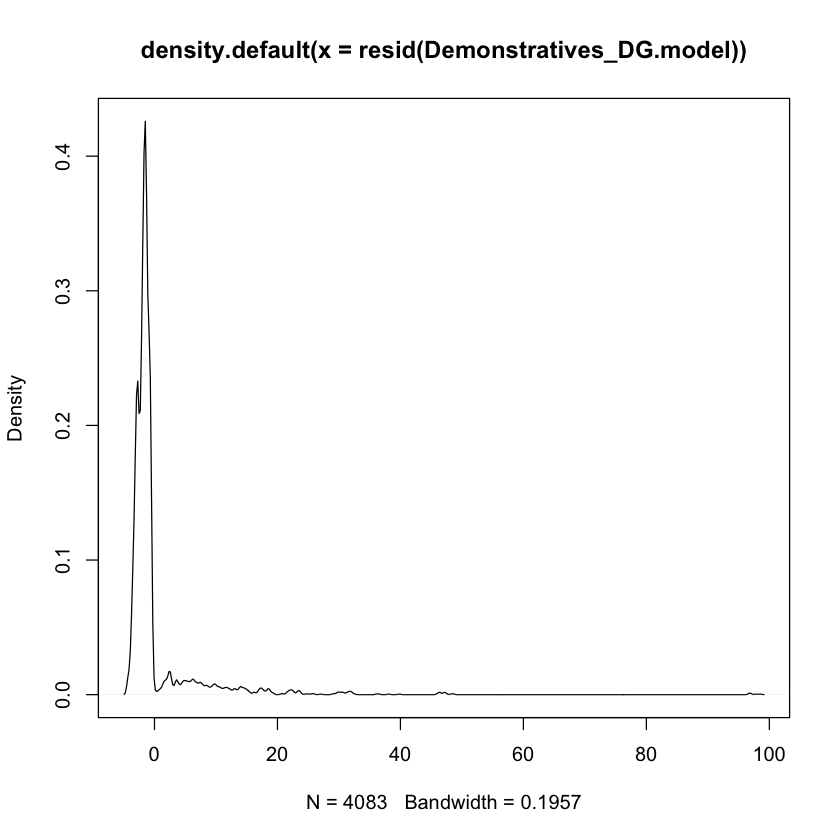

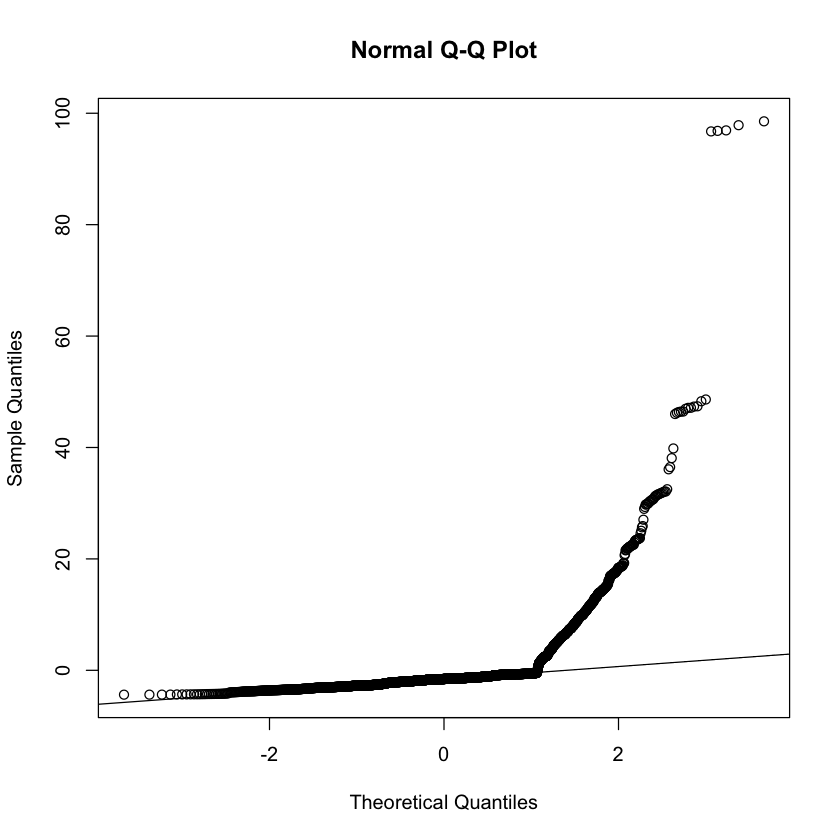

In [68]:
#check distribution of residuals
plot(density(resid(Demonstratives_DG.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(Demonstratives_DG.model)) #check if they fall on a straight line
qqline(resid(Demonstratives_DG.model))

In [69]:
#################################
##  Landmarks frequency model ##

Landmarks_DG.model = lmer(Landmark_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                        + (1 | Pair) 
                        + (0 + Affordance.sideVoppo | Pair)
                        + (0 + Block.1V2 | Pair),
                        #+ (0 + Route.L1VL2 | Pair), #did not converge
                        #+ (0 + centered_Turn | Pair), #did not converge
                        #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                        data = allData_DG, 
                        REML=FALSE)
#coef(Landmarks_DG.model)
summary(Landmarks_DG.model)
#print('Frequency of Landmarks:'); pander(print_stats(Landmarks_DG.model)) 

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00278604 (tol = 0.002, component 1)”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: Landmark_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |  
    Pair) + (0 + Block.1V2 | Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 29790.5  29872.6 -14882.2  29764.5     4070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0643 -0.3781 -0.1843  0.0128 10.7318 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           3.3058  1.8182  
 Pair.1   Affordance.sideVoppo  3.1237  1.7674  
 Pair.2   Block.1V2             0.3598  0.5999  
 Residual                      84.1183  9.1716  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                   2.8979     0.3610   31.4151
Affordance.sideVoppo                        

In [70]:
r.squaredGLMM(Landmarks_DG.model)[1]
r.squaredGLMM(Landmarks_DG.model)[2] #we report this

[1] 0.02622706

[1] 0.07229003

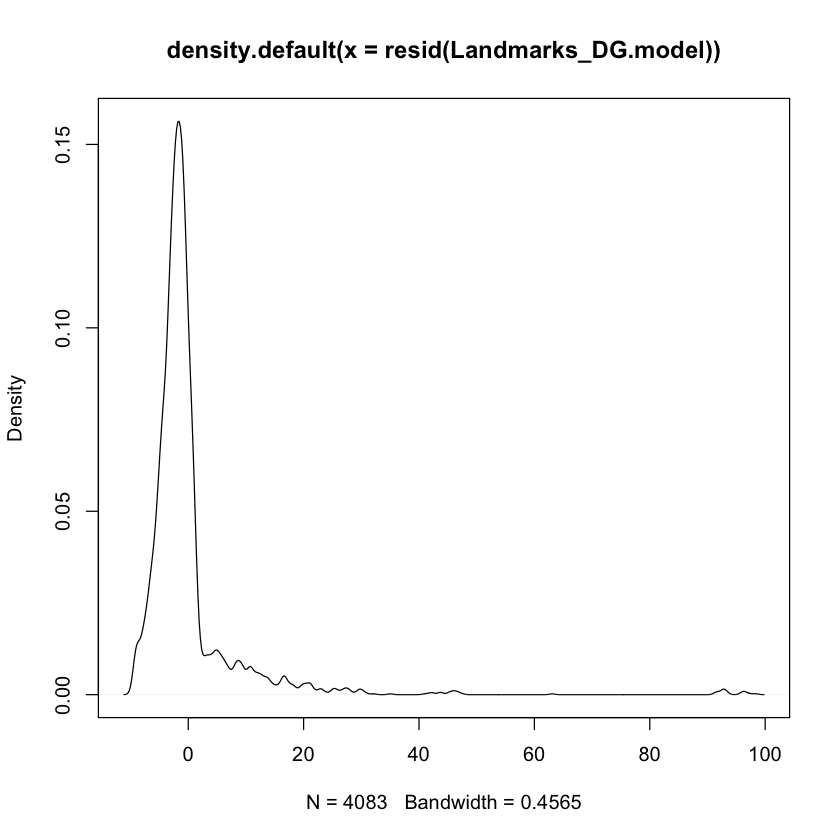

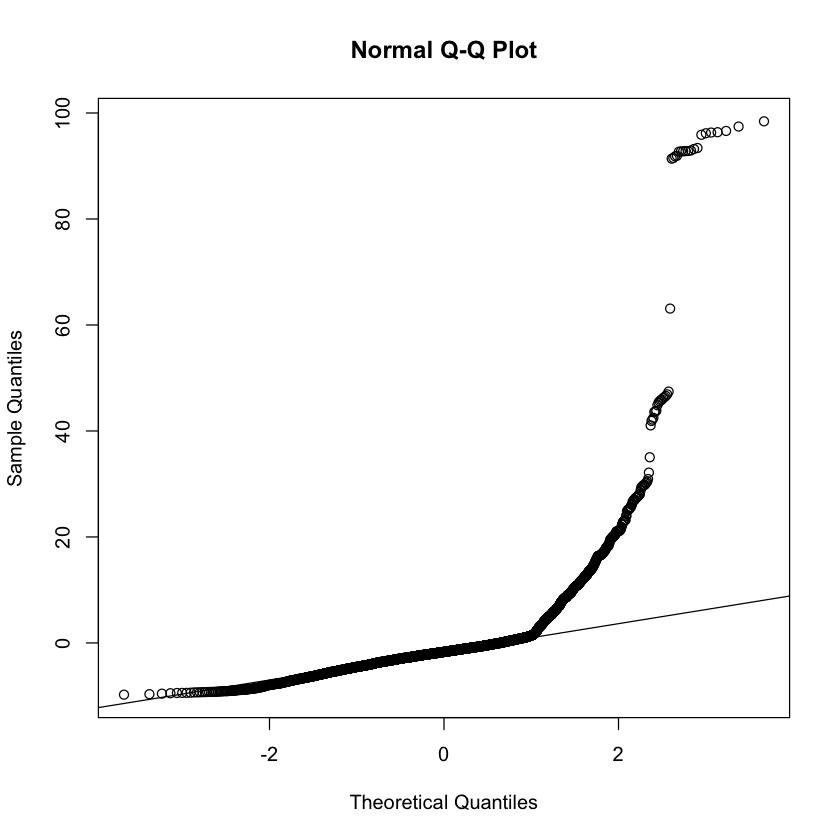

In [71]:
#check distribution of residuals
plot(density(resid(Landmarks_DG.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(Landmarks_DG.model)) #check if they fall on a straight line
qqline(resid(Landmarks_DG.model)) 

In [72]:
########################
##  Word count model ##

Words_DG.model = lmer(WordCount ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                    + (1 | Pair) 
                    + (0 + Affordance.sideVoppo | Pair),
                    #+ (0 + Block.1V2 | Pair),
                    #+ (0 + Route.L1VL2 | Pair),
                    #+ (0 + centered_Turn | Pair), 
                    #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair),
                    #+ (0 + Affordance.sideVoppo:Route.L1VL2 | Pair), #did not converge
                    data = allData_DG, 
                    REML=FALSE)
#coef(Words_DG.model)
summary(Words_DG.model)
#print('Word Counts per turn:'); pander(print_stats(Words_DG.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: WordCount ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 30267.5  30343.7 -15121.8  30243.5     4211 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6233 -0.5581 -0.2759  0.2396 11.9221 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           3.4276  1.8514  
 Pair.1   Affordance.sideVoppo  0.1859  0.4311  
 Residual                      74.3532  8.6228  
Number of obs: 4223, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                   7.2884     0.3610   31.9671
Affordance.sideVoppo                         -0.2678     0.2897   30.3633
Block.1V2                                     0.3

In [73]:
r.squaredGLMM(Words_DG.model)[1]
r.squaredGLMM(Words_DG.model)[2] #we report this

[1] 0.03093705

[1] 0.07419488

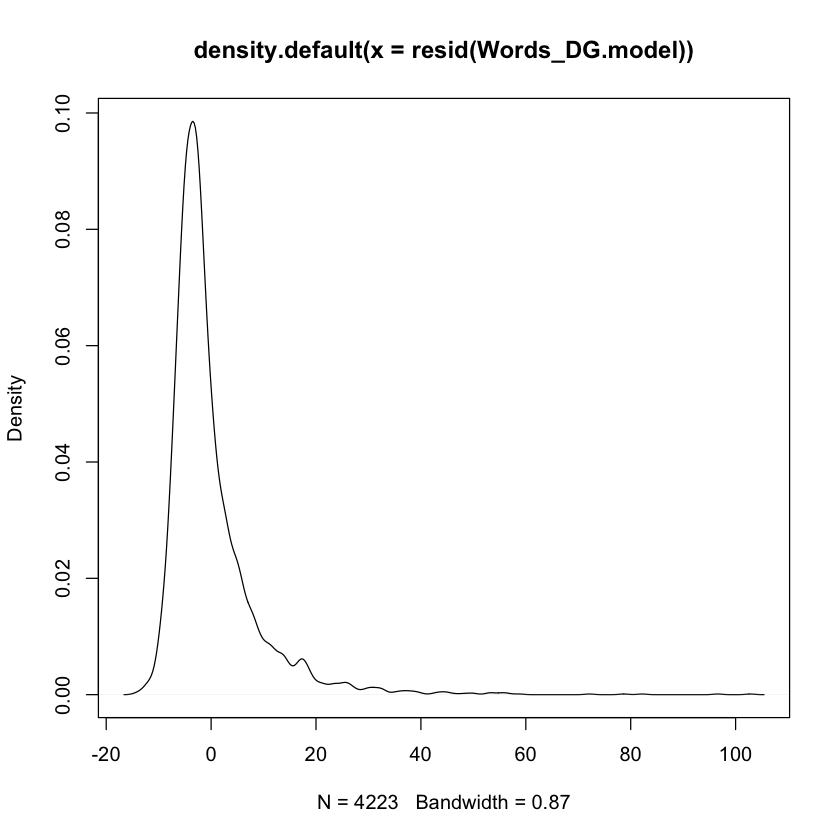

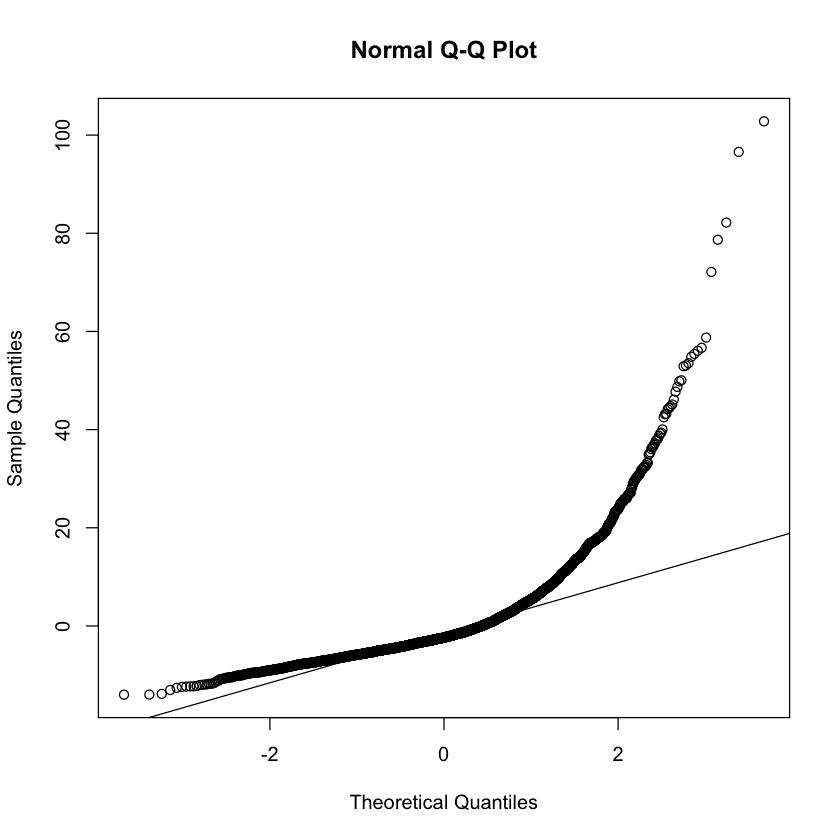

In [74]:
#check distribution of residuals
plot(density(resid(Words_DG.model))) #I re-run the model with log-transform (log(WordCount+1)), and this density plot looks like it has 2 peaks
qqnorm(resid(Words_DG.model)) #check if they fall on a straight line
qqline(resid(Words_DG.model)) 

In [75]:
######################################
###### LMERs on DF data ONLY ########
#####################################

#Check variable types
str(allData_DF)

'data.frame':	4205 obs. of  26 variables:
 $ Pair                    : Factor w/ 32 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Session                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Route                   : Factor w/ 2 levels "Ledras1","Ledras2": 1 1 1 1 1 1 1 1 1 1 ...
 $ Affordance              : Factor w/ 2 levels "Opposite","Side": 2 2 2 2 2 2 2 2 2 2 ...
 $ Turn                    : int  2 4 6 8 10 12 14 16 18 20 ...
 $ Speaker                 : chr  "DF" "DF" "DF" "DF" ...
 $ SpeechContent           : chr  "ΟΚ / " " // κάτσε στην αρχή της Λήδρας ή στο τέλος της Λήδρας ?" "ΟΚ" "ναι ? " ...
 $ SpatialExpression       : int  0 2 0 0 0 0 3 0 0 2 ...
 $ SE_Route                : int  0 0 0 0 0 0 3 0 0 2 ...
 $ SE_Allocentric          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SE_Neutral              : int  0 2 0 0 0 0 0 0 0 0 ...
 $ Ambiguous               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Landmark                : int  0 2 0 0 0 0 0 0 0 0 ...
 $ Demonstrative           : int  0

In [76]:
################################
## Set-up contrast structure ##
################################


allData_DF <- within(allData_DF, {
  
  # Factor 1: Affordance
  Affordance.sideVoppo <- ifelse( Affordance=="Side", 1/2, 
                                  ifelse( Affordance=="Opposite", -1/2, NA ) ) 
  
  # Factor 2: Block
  Block.1V2 <- ifelse( Block=="1", 1/2, 
                       ifelse( Block=="2", -1/2, NA ) ) 
  
  
  # Factor 3: Route
  Route.L1VL2 <- ifelse( Route=="Ledras1", 1/2, 
                         ifelse( Route=="Ledras2", -1/2, NA ) ) 
  
  # Factor 4: Body Switch (for exploratory analyses)
  BodySwitch.yesVno <- ifelse( BodySwitch=="switch", 1/2, 
                               ifelse( BodySwitch=="nonswitch", -1/2, NA ) ) 
  
} )

In [77]:
##########################################
## Spatial expressions frequency model ##

### NOT reported ###

SE_Total_DF.model = lmer(SE_Total_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                         + (1 | Pair) 
                         + (0 + Affordance.sideVoppo | Pair),
                         #+ (0 + Block.1V2 | Pair),
                         #+ (0 + Route.L1VL2 | Pair),
                         #+ (0 + centered_Turn | Pair),
                         #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                         data = allData_DF, 
                         REML=FALSE)

In [78]:
#coef(SE_Total_DF.model)
summary(SE_Total_DF.model)
#print('Frequency of total spatial expressions:'); pander(print_stats(SE_Total_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Total_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 37270.8  37346.1 -18623.4  37246.8     3923 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7364 -0.6848 -0.2727  0.4145 10.1932 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           37.61    6.133  
 Pair.1   Affordance.sideVoppo  43.49    6.595  
 Residual                      738.26   27.171  
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                  21.0135     1.1974   30.8967
Affordance.sideVoppo                          2.1568     1.5181   34.6773
Block.1V2                                    

In [79]:
r.squaredGLMM(SE_Total_DF.model)[1]
r.squaredGLMM(SE_Total_DF.model)[2] #we report this

[1] 0.04627059

[1] 0.105047

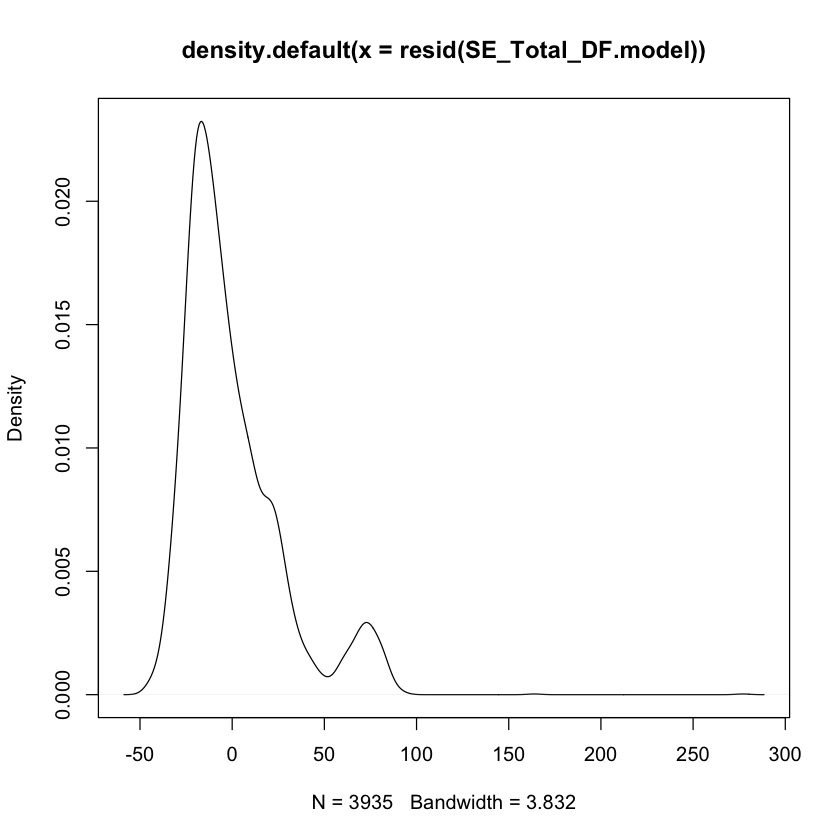

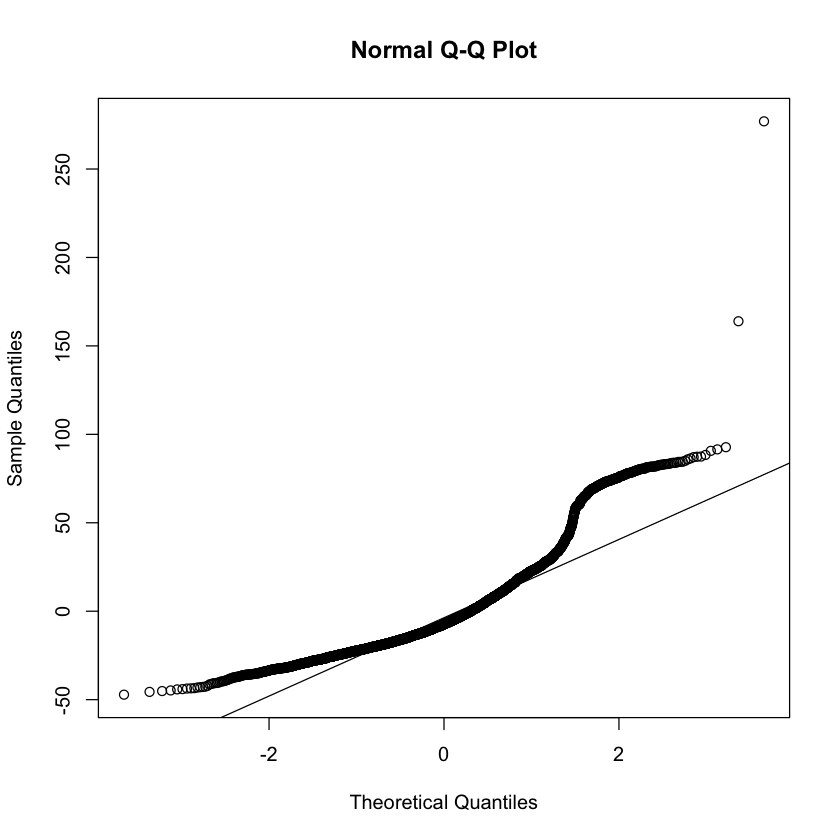

In [80]:
#check distribution of residuals
plot(density(resid(SE_Total_DF.model))) #does this look approximately normal
qqnorm(resid(SE_Total_DF.model)) #check if they fall on a straight line
qqline(resid(SE_Total_DF.model)) 

In [81]:
########################################
## Route expressions frequency model ##

SE_Route_DF.model = lmer(SE_Route_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                         + (1 | Pair) 
                         + (0 + Affordance.sideVoppo | Pair),
                         #+ (0 + Block.1V2 | Pair),
                         #+ (0 + Route.L1VL2 | Pair),
                         #+ (0 + centered_Turn | Pair),#did not converge
                         #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                         data = allData_DF, 
                         REML=FALSE)
#coef(SE_Route_DF.model)
summary(SE_Route_DF.model)
#print('Frequency of Route expressions:'); pander(print_stats(SE_Route_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Route_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 36956.5  37031.8 -18466.2  36932.5     3923 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5599 -0.6510 -0.3125  0.3385  3.5938 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           36.01    6.001  
 Pair.1   Affordance.sideVoppo  33.61    5.797  
 Residual                      681.99   26.115  
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                  17.9663     1.1680   31.5842
Affordance.sideVoppo                          2.2007     1.3835   34.0520
Block.1V2                                    

In [82]:
r.squaredGLMM(SE_Route_DF.model)[1]
r.squaredGLMM(SE_Route_DF.model)[2] #we report this

[1] 0.03729975

[1] 0.09615761

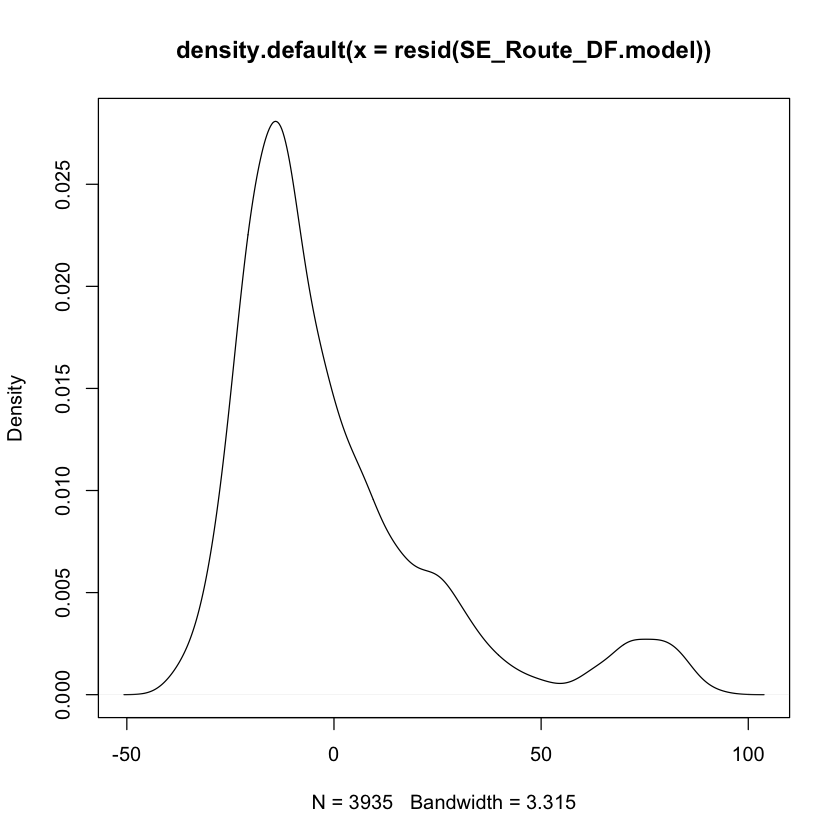

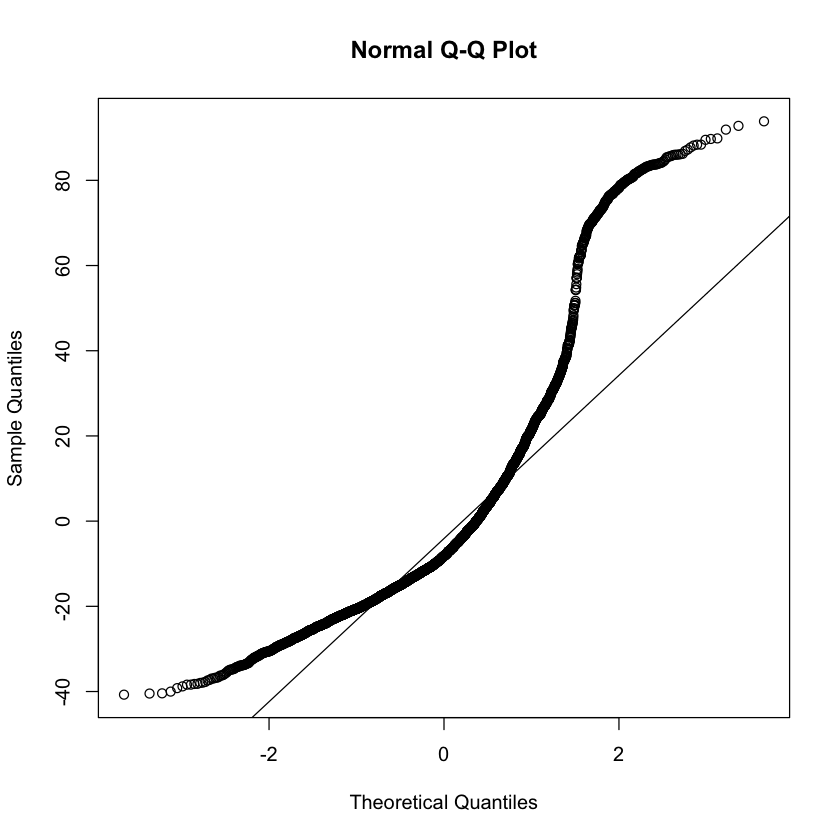

In [83]:
#check distribution of residuals
plot(density(resid(SE_Route_DF.model))) #does this look approximately normal
qqnorm(resid(SE_Route_DF.model)) #check if they fall on a straight line
qqline(resid(SE_Route_DF.model)) 

In [84]:
#########################################
##  Survey expressions frequency model ##

SE_Survey_DF.model = lmer(SE_Allocentric_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                          + (1 | Pair) 
                          + (0 + Affordance.sideVoppo | Pair)
                          + (0 + Block.1V2 | Pair)
                          + (0 + Route.L1VL2 | Pair), 
                          #+ (0 + centered_Turn | Pair), 
                          #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                          data = allData_DF, 
                          REML=FALSE)
#coef(SE_Survey_DF.model)
summary(SE_Survey_DF.model)
#print('Frequency of Survey expressions:'); pander(print_stats(SE_Survey_DF.model)) 

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 2 negative eigenvalues”
Warning message:
“Model failed to converge with 2 negative eigenvalues: -2.8e-02 -2.8e-02”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
SE_Allocentric_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |  
    Pair) + (0 + Block.1V2 | Pair) + (0 + Route.L1VL2 | Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 24340.9  24428.8 -12156.5  24312.9     3921 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8699 -0.2006 -0.1186 -0.0498 18.6032 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           0.86474 0.9299  
 Pair.1   Affordance.sideVoppo  0.02349 0.1533  
 Pair.2   Block.1V2             1.07957 1.0390  
 Pair.3   Route.L1VL2           0.21447 0.4631  
 Residual                      27.70448 5.2635  
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                      

In [85]:
r.squaredGLMM(SE_Survey_DF.model)[1]
r.squaredGLMM(SE_Survey_DF.model)[2] #we report this

[1] 0.009364943

[1] 0.05029921

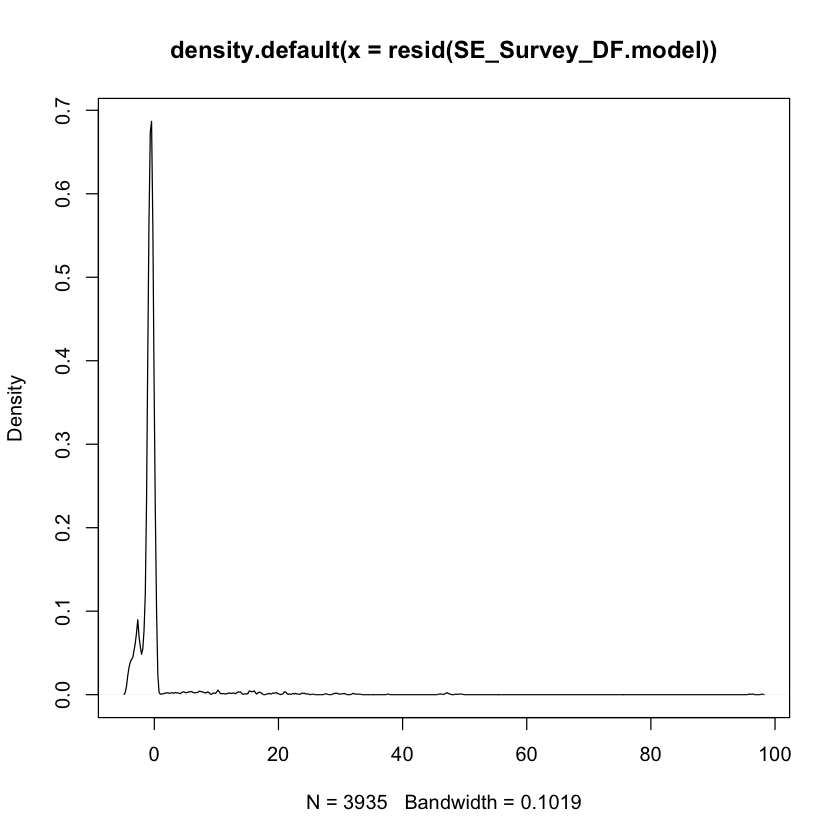

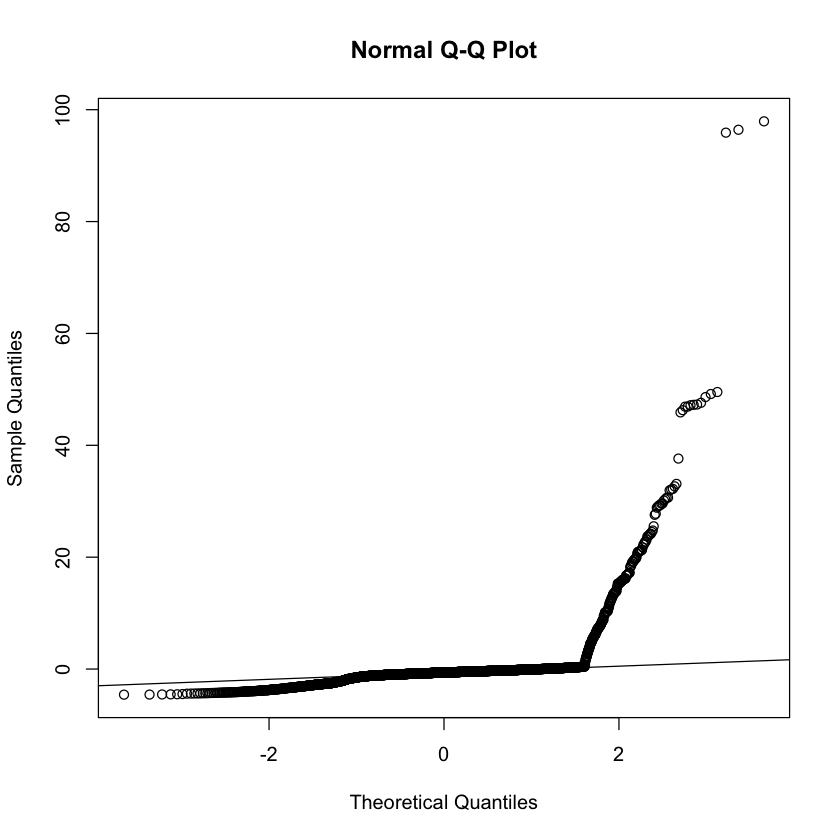

In [86]:
#check distribution of residuals
plot(density(resid(SE_Survey_DF.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(SE_Survey_DF.model)) #check if they fall on a straight line
qqline(resid(SE_Survey_DF.model)) 

In [87]:
###########################################
##  Neutral expressions frequency model ##

SE_Neutral_DF.model = lmer(SE_Neutral_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                           + (1 | Pair) 
                           + (0 + Affordance.sideVoppo | Pair),
                           #+ (0 + Block.1V2 | Pair),
                           #+ (0 + Route.L1VL2 | Pair),
                           #+ (0 + centered_Turn | Pair), #did not converge
                           #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                           data = allData_DF, 
                           REML=FALSE)
#coef(SE_Neutral_DF.model)
summary(SE_Neutral_DF.model)
#print('Frequency of Neutral expressions:'); pander(print_stats(SE_Neutral_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Neutral_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 27316.3  27391.7 -13646.2  27292.3     3923 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1507 -0.3097 -0.1748 -0.0653 25.4503 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           1.296   1.139   
 Pair.1   Affordance.sideVoppo  4.030   2.007   
 Residual                      59.092   7.687   
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                   2.0387     0.2445   31.7972
Affordance.sideVoppo                          0.2338     0.4492   31.2116
Block.1V2                                  

In [88]:
r.squaredGLMM(SE_Neutral_DF.model)[1]
r.squaredGLMM(SE_Neutral_DF.model)[2] #we report this

[1] 0.02123049

[1] 0.05795753

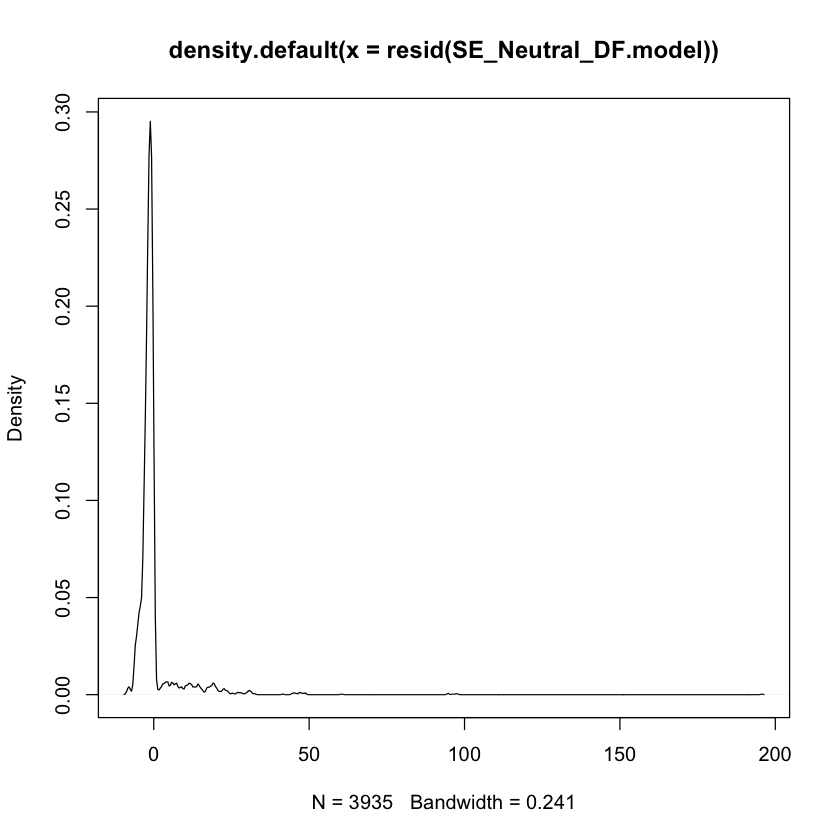

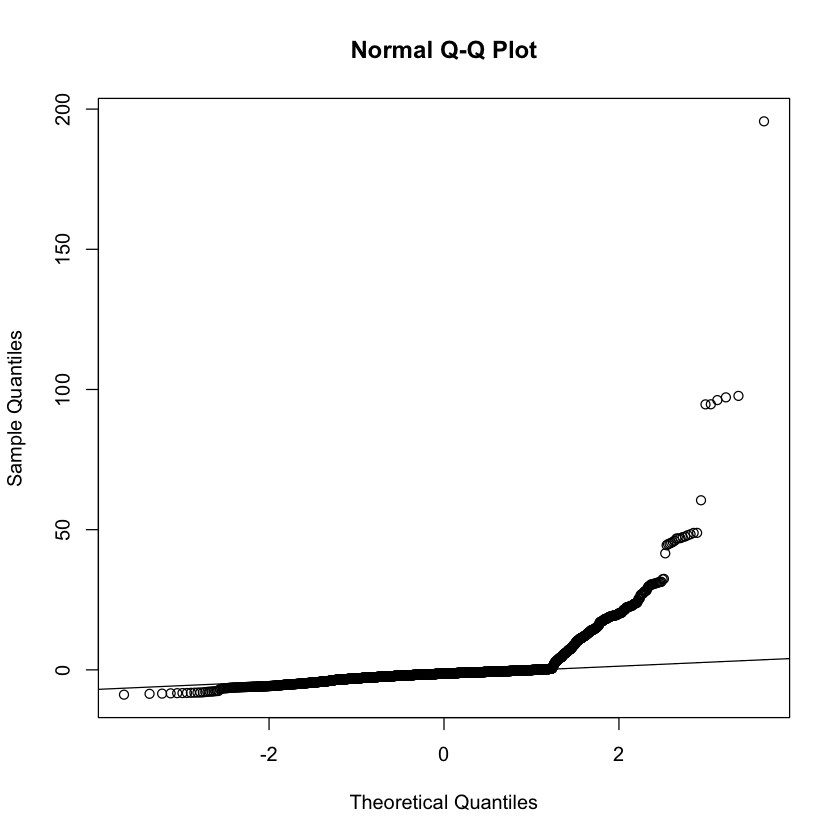

In [89]:
#check distribution of residuals
plot(density(resid(SE_Neutral_DF.model))) #This does not look normal -- very positively skewed. I tried log-transforming and adding a small value to the DV but does not help
qqnorm(resid(SE_Neutral_DF.model)) #check if they fall on a straight line
qqline(resid(SE_Neutral_DF.model)) 

In [90]:
######################################
##  Demonstratives frequency model ##

Demonstratives_DF.model = lmer(Demonstr_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                               + (1 | Pair) 
                               + (0 + Affordance.sideVoppo | Pair),
                               #+ (0 + Block.1V2 | Pair),
                               #+ (0 + Route.L1VL2 | Pair), #did not converge
                               #+ (0 + centered_Turn | Pair), #did not converge
                               #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                               data = allData_DF, 
                               REML=FALSE)
#coef(Demonstratives_DF.model)
summary(Demonstratives_DF.model)
#print('Frequency of Demonstratives:'); pander(print_stats(Demonstratives_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: Demonstr_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 24957.8  25033.1 -12466.9  24933.8     3923 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7237 -0.2634 -0.1624 -0.1080 16.9729 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           0.4244  0.6515  
 Pair.1   Affordance.sideVoppo  0.8350  0.9138  
 Residual                      32.6757  5.7163  
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                   1.21853    0.15309   30.81990
Affordance.sideVoppo                          0.16652    0.25583   31.01218
Block.1V2                              

In [91]:
r.squaredGLMM(Demonstratives_DF.model)[1]
r.squaredGLMM(Demonstratives_DF.model)[2] #we report this

[1] 0.00537405

[1] 0.02428044

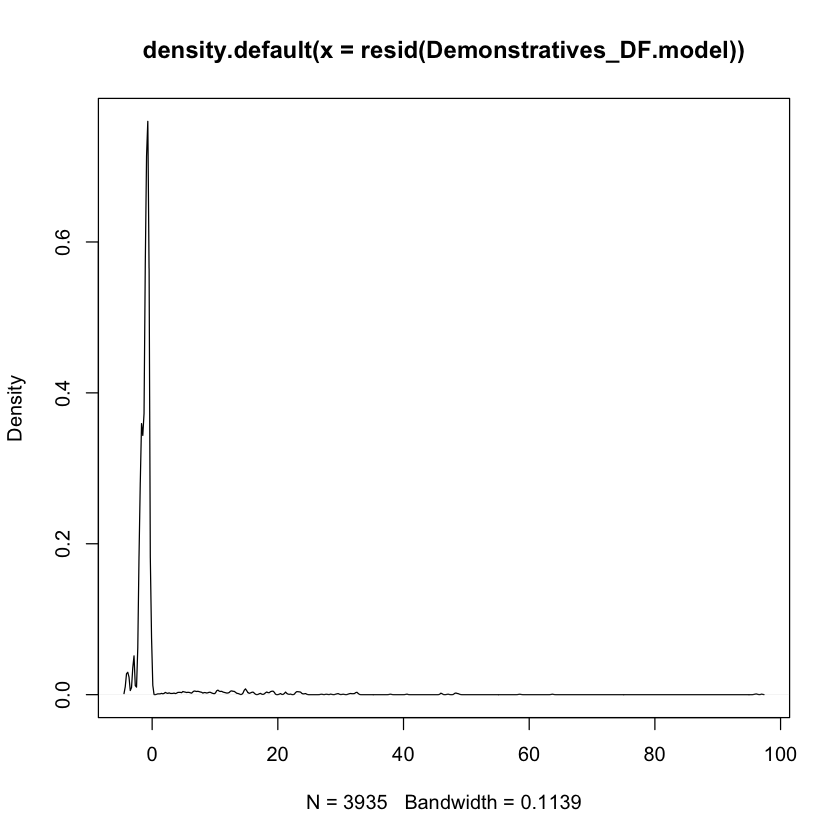

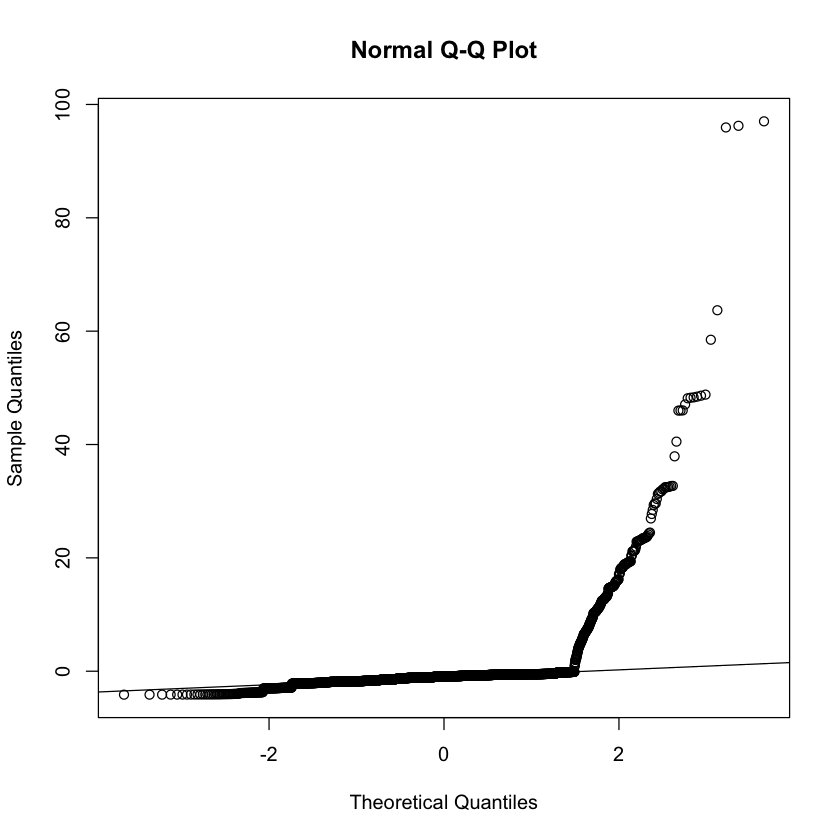

In [92]:
#check distribution of residuals
plot(density(resid(Demonstratives_DF.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(Demonstratives_DF.model)) #check if they fall on a straight line
qqline(resid(Demonstratives_DF.model))

In [93]:
#################################
##  Landmarks frequency model ##

Landmarks_DF.model = lmer(Landmark_freq ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                          + (1 | Pair) 
                          + (0 + Affordance.sideVoppo | Pair),
                          #+ (0 + Block.1V2 | Pair),
                          #+ (0 + Route.L1VL2 | Pair), #did not converge
                          #+ (0 + centered_Turn | Pair), #did not converge
                          #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair), #did not converge
                          data = allData_DF, 
                          REML=FALSE)
#coef(Landmarks_DF.model)
summary(Landmarks_DF.model)
print('Frequency of Landmarks:'); pander(print_stats(Landmarks_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: Landmark_freq ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 27916.0  27991.3 -13946.0  27892.0     3923 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0877 -0.3669 -0.1826 -0.0449 11.8644 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           2.346   1.532   
 Pair.1   Affordance.sideVoppo  3.633   1.906   
 Residual                      68.724   8.290   
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                   2.33474    0.31056   27.15925
Affordance.sideVoppo                         -0.34288    0.44794   26.72046
Block.1V2                              

[1] "Frequency of Landmarks:"


|                     &nbsp;                     | Estimate | Std..Error |
|:----------------------------------------------:|:--------:|:----------:|
|                **(Intercept)**                 |  2.335   |   0.3106   |
|            **Affordance.sideVoppo**            | -0.3429  |   0.4479   |
|                 **Block.1V2**                  |  1.196   |   0.4479   |
|                **Route.L1VL2**                 |  0.1716  |   0.4479   |
|               **centered_Turn**                | -0.6046  |   0.1342   |
|       **Affordance.sideVoppo:Block.1V2**       | 0.05243  |   1.242    |
|      **Affordance.sideVoppo:Route.L1VL2**      |  -1.824  |   1.242    |
|           **Block.1V2:Route.L1VL2**            | -0.2878  |   1.242    |
| **Affordance.sideVoppo:Block.1V2:Route.L1VL2** |  1.333   |   1.792    |

Table: Table continues below

 

|                     &nbsp;                     |  df   | t.value |
|:--------------------------------------

In [94]:
r.squaredGLMM(Landmarks_DF.model)[1]
r.squaredGLMM(Landmarks_DF.model)[2] #we report this

[1] 0.01338709

[1] 0.05798617

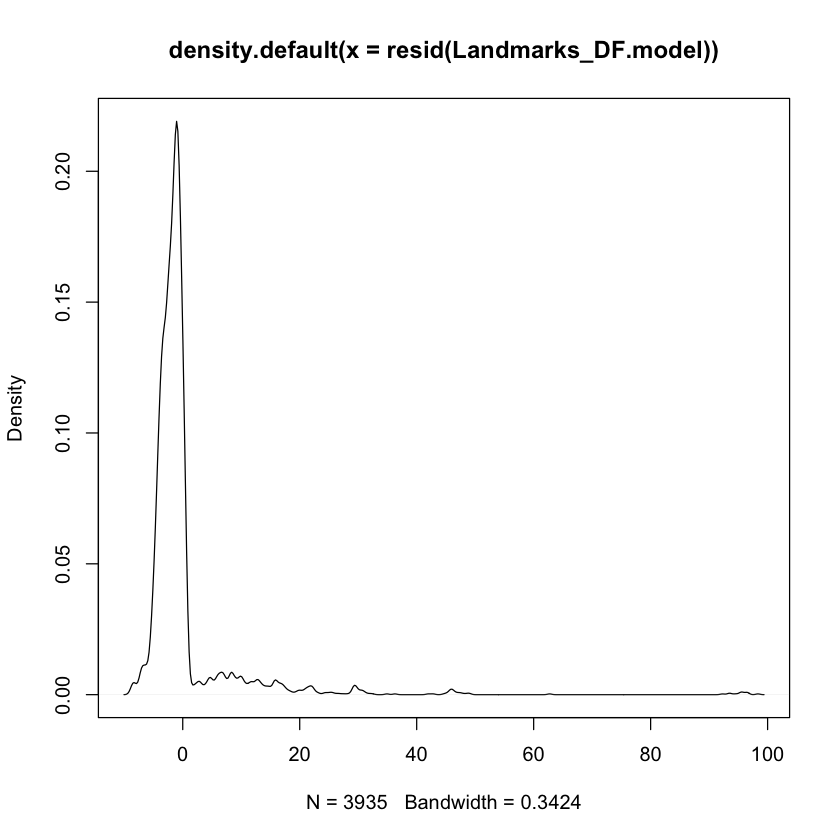

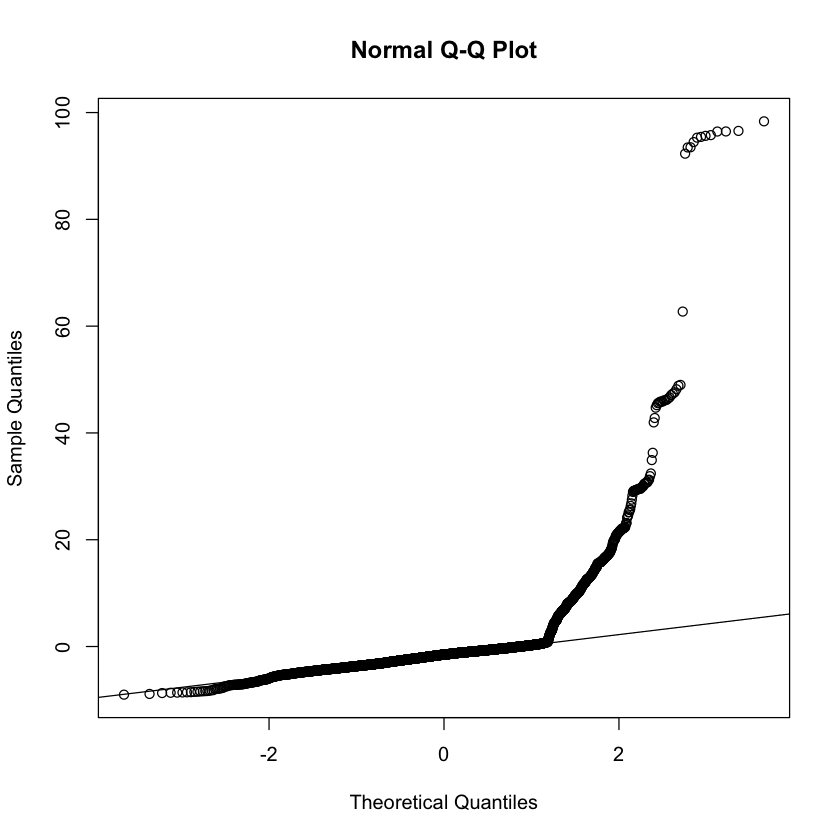

In [95]:
#check distribution of residuals
plot(density(resid(Landmarks_DF.model))) #This does not look normal -- very positively skewed. 
qqnorm(resid(Landmarks_DF.model)) #check if they fall on a straight line
qqline(resid(Landmarks_DF.model)) 

In [96]:
########################
##  Word count model ##

Words_DF.model = lmer(WordCount ~ Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                      + (1 | Pair) 
                      + (0 + Affordance.sideVoppo | Pair),
                      #+ (0 + Block.1V2 | Pair),
                      #+ (0 + Route.L1VL2 | Pair),
                      #+ (0 + centered_Turn | Pair), 
                      #+ (0 + Affordance.sideVoppo:Block.1V2 | Pair),
                      #+ (0 + Affordance.sideVoppo:Route.L1VL2 | Pair), #did not converge
                      data = allData_DF, 
                      REML=FALSE)
#coef(Words_DF.model)
summary(Words_DF.model)
#print('Word Counts per turn:'); pander(print_stats(Words_DF.model)) 

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: WordCount ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    centered_Turn + (1 | Pair) + (0 + Affordance.sideVoppo |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 25813.7  25889.8 -12894.8  25789.7     4193 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5438 -0.5902 -0.2889  0.2591  8.5255 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           0.7250  0.8515  
 Pair.1   Affordance.sideVoppo  0.2243  0.4737  
 Residual                      26.6371  5.1611  
Number of obs: 4205, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                   4.45963    0.17511   30.68562
Affordance.sideVoppo                         -0.47507    0.18900   28.78356
Block.1V2                                  

In [97]:
r.squaredGLMM(Words_DF.model)[1]
r.squaredGLMM(Words_DF.model)[2] #we report this

[1] 0.04119765

[1] 0.06851146

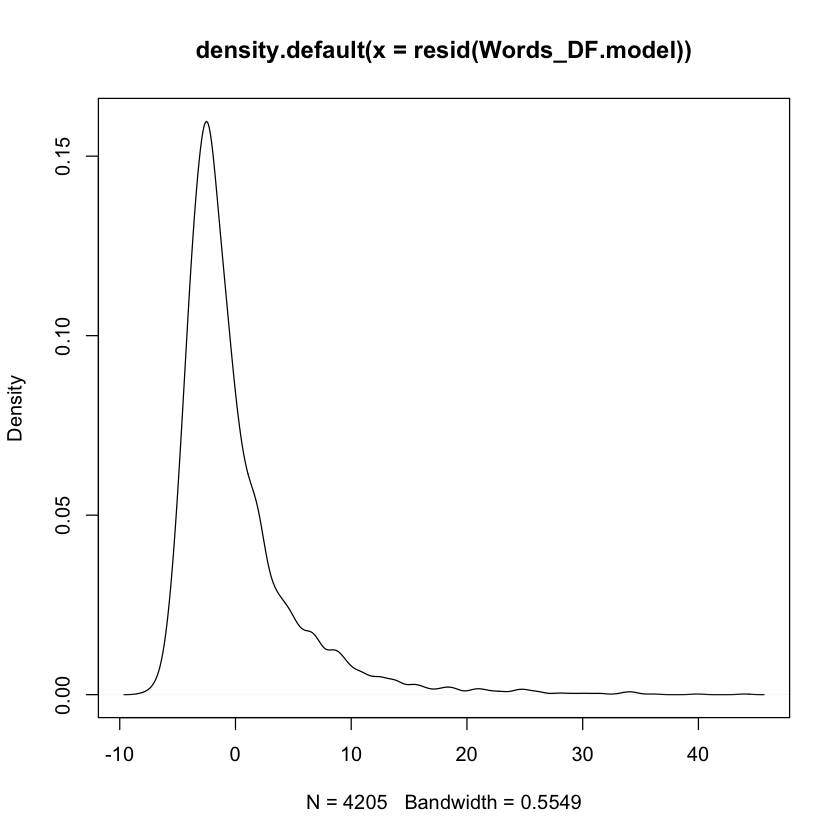

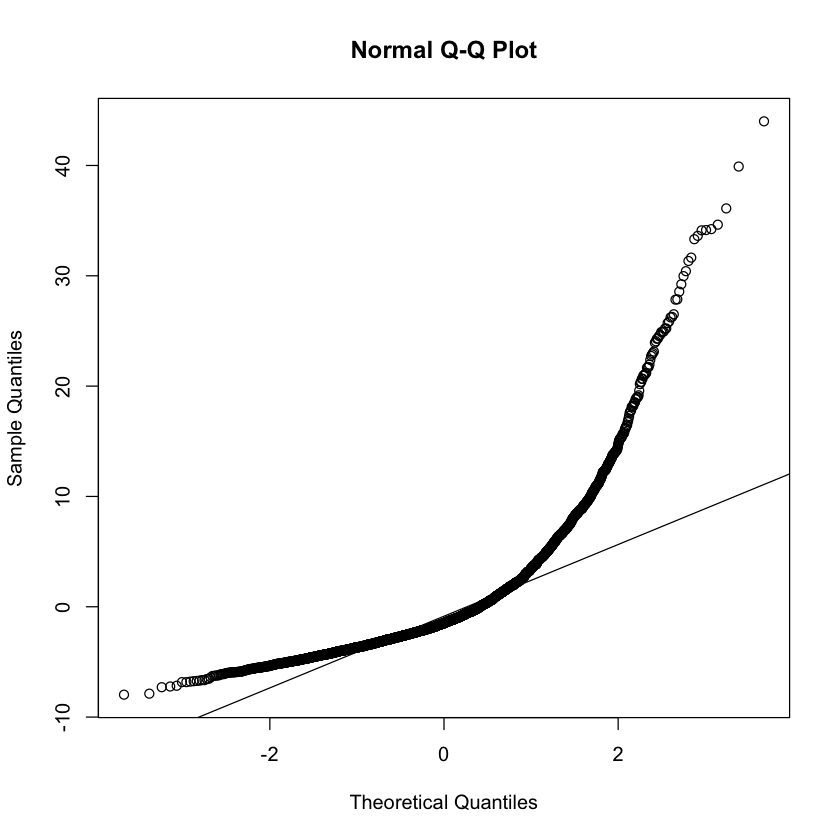

In [98]:
#check distribution of residuals
plot(density(resid(Words_DF.model))) #I re-run the model with log-transform (log(WordCount+1)), and this density plot looks like it has 2 peaks
qqnorm(resid(Words_DF.model)) #check if they fall on a straight line
qqline(resid(Words_DF.model)) 

In [99]:
####################################################
###### Exploration of gender and familiarity ######
####################################################

#Total Turns in Dialogue by Pair Familiarity

summtTotalTurns_byFamiliarity = dplyr::summarize(group_by(allDialogues, PairFamiliarity),
                                                 mean=mean(finalTurn, na.rm = TRUE), sd= sd(finalTurn, na.rm = TRUE), se=sd(finalTurn, na.rm = TRUE)/sqrt(length(finalTurn)))
print.data.frame(summtTotalTurns_byFamiliarity)

  PairFamiliarity     mean       sd       se
1   acquaintances 125.0000 44.10341 13.94672
2          couple 163.5000 69.40461 34.70231
3         friends 113.6923 69.18888 13.56906
4       strangers 141.1875 69.56936 17.39234
5         unknown 163.6250 72.01971 25.46281


In [100]:
#Total Words in Dialogue by Pair Familiarity

summtTotalWords_byFamiliarity = dplyr::summarize(group_by(allDialogues, PairFamiliarity),
                                                 mean=mean(TotalWords, na.rm = TRUE), sd= sd(TotalWords, na.rm = TRUE), se=sd(TotalWords, na.rm = TRUE)/sqrt(length(TotalWords)))
print.data.frame(summtTotalWords_byFamiliarity)

  PairFamiliarity      mean       sd        se
1   acquaintances  689.1000 309.1161  97.75110
2          couple 1045.5000 541.6829 270.84144
3         friends  718.8077 456.0569  89.44012
4       strangers  782.3750 404.6424 101.16059
5         unknown  842.8750 348.6826 123.27791


In [101]:
#Total Turns in Dialogue by DG Gender

summtTotalTurns_byDGGender = dplyr::summarize(group_by(allDialogues, DG_Gender),
                                              mean=mean(finalTurn, na.rm = TRUE), sd= sd(finalTurn, na.rm = TRUE), se=sd(finalTurn, na.rm = TRUE)/sqrt(length(finalTurn)))
print.data.frame(summtTotalTurns_byDGGender)

  DG_Gender     mean       sd       se
1    female 131.8958 70.81809 10.22171
2      male 131.0625 56.17647 14.04412


In [102]:
#Total Words in Dialogue by DG Gender

summtTotalWords_byDGGender = dplyr::summarize(group_by(allDialogues, DG_Gender),
                                              mean=mean(TotalWords, na.rm = TRUE), sd= sd(TotalWords, na.rm = TRUE), se=sd(TotalWords, na.rm = TRUE)/sqrt(length(TotalWords)))
print.data.frame(summtTotalWords_byDGGender)

  DG_Gender     mean       sd        se
1    female 742.9792 406.9004  58.73101
2      male 835.0000 435.4925 108.87313


In [103]:
#Total Turns in Dialogue by DF Gender

summtTotalTurns_byDFGender = dplyr::summarize(group_by(allDialogues, DF_Gender),
                                              mean=mean(finalTurn, na.rm = TRUE), sd= sd(finalTurn, na.rm = TRUE), se=sd(finalTurn, na.rm = TRUE)/sqrt(length(finalTurn)))
print.data.frame(summtTotalTurns_byDFGender)

  DF_Gender     mean       sd        se
1    female 137.2115 70.11988  9.723878
2      male 107.7500 46.55422 13.439046


In [104]:
#Total Words in Dialogue by DF Gender

summtTotalWords_byDFGender = dplyr::summarize(group_by(allDialogues, DF_Gender),
                                              mean=mean(TotalWords, na.rm = TRUE), sd= sd(TotalWords, na.rm = TRUE), se=sd(TotalWords, na.rm = TRUE)/sqrt(length(TotalWords)))
print.data.frame(summtTotalWords_byDFGender)

  DF_Gender     mean       sd        se
1    female 766.7885 419.9551  58.23729
2      male 762.5000 396.9725 114.59610


In [105]:
#########################################################
##  Exploratory: Language use of body switchers models ##

SE_Route_DG_BodySwitch.model = lmer(SE_Route_freq ~ BodySwitch.yesVno*Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                         + (1 | Pair) 
                         #+ (0 + BodySwitch.yesVno | Pair)
                         #+ (0 + Affordance.sideVoppo | Pair)
                         + (0 + Block.1V2 | Pair),
                         #+ (0 + Route.L1VL2 | Pair),
                         #+ (0 + centered_Turn | Pair),
                         #+ (0 + BodySwitch.yesVno:Block.1V2 | Pair), #did not converge
                         data = allData_DG, 
                         REML=FALSE)
summary(SE_Route_DG_BodySwitch.model)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
SE_Route_freq ~ BodySwitch.yesVno * Affordance.sideVoppo * Block.1V2 *  
    Route.L1VL2 + centered_Turn + (1 | Pair) + (0 + Block.1V2 |      Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 36904.1  37030.4 -18432.0  36864.1     4063 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4408 -0.5711 -0.3694  0.2872  4.2124 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept)   4.764   2.183  
 Pair.1   Block.1V2    23.740   4.872  
 Residual             481.841  21.951  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
                                                              Estimate
(Intercept)                                                    14.1039
BodySwitch.yesVno                                               1.4665
Affordance.sideVoppo                                           -1.3156
Block.1V2

In [106]:
SE_Survey_DG_BodySwitch.model = lmer(SE_Allocentric_freq ~ BodySwitch.yesVno*Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                          + (1 | Pair) 
                          + (0 + BodySwitch.yesVno | Pair)
                          + (0 + Affordance.sideVoppo | Pair)
                          + (0 + Block.1V2 | Pair)
                          + (0 + Route.L1VL2 | Pair), 
                          #+ (0 + centered_Turn | Pair), 
                          #+ (0 + BodySwitch.yesVno:Block.1V2 | Pair), #did not converge
                          data = allData_DG, 
                          REML=FALSE)
summary(SE_Survey_DG_BodySwitch.model)

boundary (singular) fit: see ?isSingular

Warning message:
“Model failed to converge with 1 negative eigenvalue: -3.8e-03”

Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Allocentric_freq ~ BodySwitch.yesVno * Affordance.sideVoppo *  
    Block.1V2 * Route.L1VL2 + centered_Turn + (1 | Pair) + (0 +  
    BodySwitch.yesVno | Pair) + (0 + Affordance.sideVoppo | Pair) +  
    (0 + Block.1V2 | Pair) + (0 + Route.L1VL2 | Pair)
   Data: allData_DG

     AIC      BIC   logLik deviance df.resid 
 25374.5  25519.7 -12664.2  25328.5     4060 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2328 -0.3372 -0.1694 -0.0765 18.0167 

Random effects:
 Groups   Name                 Variance Std.Dev.
 Pair     (Intercept)           0.70058 0.8370  
 Pair.1   BodySwitch.yesVno     0.08618 0.2936  
 Pair.2   Affordance.sideVoppo  0.00000 0.0000  
 Pair.3   Block.1V2             0.00000 0.0000  
 Pair.4   Route.L1VL2           0.00000 0.0000  
 Residual                      28.63448 5.3511  
Number of obs: 4083, groups:  Pair, 32

Fixed effects:
  

In [107]:
SE_Route_DF_BodySwitch.model = lmer(SE_Route_freq ~ BodySwitch.yesVno*Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                                    + (1 | Pair) 
                                    #+ (0 + BodySwitch.yesVno | Pair)
                                    #+ (0 + Affordance.sideVoppo | Pair)
                                    + (0 + Block.1V2 | Pair),
                                    #+ (0 + Route.L1VL2 | Pair),
                                    #+ (0 + centered_Turn | Pair),
                                    #+ (0 + BodySwitch.yesVno:Block.1V2 | Pair), #did not converge
                                    data = allData_DF, 
                                    REML=FALSE)
summary(SE_Route_DF_BodySwitch.model)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
SE_Route_freq ~ BodySwitch.yesVno * Affordance.sideVoppo * Block.1V2 *  
    Route.L1VL2 + centered_Turn + (1 | Pair) + (0 + Block.1V2 |      Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 36956.8  37082.3 -18458.4  36916.8     3915 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5182 -0.6482 -0.3173  0.3401  3.5902 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept)  24.96    4.996  
 Pair.1   Block.1V2    18.62    4.315  
 Residual             682.53   26.125  
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                                               Estimate
(Intercept)                                                    19.39691
BodySwitch.yesVno                                               3.88201
Affordance.sideVoppo                                           -0.45410
Block

In [108]:
SE_Survey_DF_BodySwitch.model = lmer(SE_Allocentric_freq ~ BodySwitch.yesVno*Affordance.sideVoppo*Block.1V2*Route.L1VL2 + centered_Turn 
                                     + (1 | Pair) 
                                     + (0 + Affordance.sideVoppo | Pair)
                                     + (0 + BodySwitch.yesVno | Pair),
                                     #+ (0 + Block.1V2 | Pair),
                                     #+ (0 + Route.L1VL2 | Pair), 
                                     #+ (0 + centered_Turn | Pair), 
                                     #+ (0 + BodySwitch.yesVno:Block.1V2 | Pair), #did not converge
                                     data = allData_DF, 
                                     REML=FALSE)
summary(SE_Survey_DF_BodySwitch.model)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message:
“Model failed to converge with 1 negative eigenvalue: -2.2e-01”

Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: SE_Allocentric_freq ~ BodySwitch.yesVno * Affordance.sideVoppo *  
    Block.1V2 * Route.L1VL2 + centered_Turn + (1 | Pair) + (0 +  
    Affordance.sideVoppo | Pair) + (0 + BodySwitch.yesVno | Pair)
   Data: allData_DF

     AIC      BIC   logLik deviance df.resid 
 24346.3  24478.1 -12152.1  24304.3     3914 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9432 -0.2068 -0.1185 -0.0460 18.5992 

Random effects:
 Groups   Name                 Variance  Std.Dev.
 Pair     (Intercept)           0.004784 0.06916 
 Pair.1   Affordance.sideVoppo  1.139609 1.06752 
 Pair.2   BodySwitch.yesVno     2.692949 1.64102 
 Residual                      27.701627 5.26323 
Number of obs: 3935, groups:  Pair, 32

Fixed effects:
                                                               Estimate
(Intercept)                                                     0.92799
BodySwitc

# From file "Affordances_MapReconstructions.R"

In [109]:

##############################
#### MAP DRAWING ANAYSES ####
############################

#read Spatial Expressions file
source('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Code/Affordances_SpatialExpressions.r')

ERROR: Error in `colnames<-`(`*tmp*`, value = c("Pair", "Session", "Affordance", : attempt to set 'colnames' on an object with less than two dimensions


In [111]:
AllMapReconData <- read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Map_Reconstructions/DirGiving_MapCoding_Masterfile.xlsx', na.strings=c("NA", "#NULL!")) 

In [112]:
#select data only for Ledras 1 and Ledras 2 routes 
MapReconLedrasData <- subset(AllMapReconData, AllMapReconData$Route %in% c('Ledra1', 'Ledra2'))
#View(MapReconLedrasData)
MapReconLedrasData

,Pair,Session,Affordance,Environment,Route,Segments_Total,Route_Sequence,DF_Sequence,Segs_InitialCorrect,RelativeTurnsCorrect
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
2,1,2,Opposite,Remote,Ledra1,9,SRLRLLRRL,SRLRLLRRL,9,9
4,1,4,Side,Remote,Ledra2,10,SRLLRLRLRR,SRLLRLRRL,7,7
6,10,2,Opposite,Remote,Ledra2,10,SRLLRLRLRR,SRLLRLL,6,7
7,10,3,Side,Remote,Ledra1,9,SRLRLLRRL,SRLRLL,5,6
10,11,2,Side,Remote,Ledra2,10,SRLLRLRLRR,SRLLRL,5,5
11,11,3,Opposite,Remote,Ledra1,9,SRLRLLRRL,SLRLRLRLR,5,5
14,12,2,Opposite,Remote,Ledra1,9,SRLRLLRRL,SRLRLLRLRRR,5,7
15,12,3,Side,Remote,Ledra2,10,SRLLRLRLRR,SRLLRLR,5,7
17,13,1,Side,Remote,Ledra1,9,SRLRLLRRL,SRLRLLR,7,7


In [113]:
# for consistency with other dataframes change Ledra -> Ledras
MapReconLedrasData$Route <- gsub('Ledra1','Ledras1',MapReconLedrasData$Route)
MapReconLedrasData$Route <- gsub('Ledra2','Ledras2',MapReconLedrasData$Route)

dim(MapReconLedrasData)

[1] 64 10

In [114]:
MapReconLedrasData$Block = "1"
MapReconLedrasData$Block[MapReconLedrasData$Session %in% c('3','4')]='2'
MapReconLedrasData$Pro_initSegsCorrect = (MapReconLedrasData$Segs_InitialCorrect) / (MapReconLedrasData$Segments_Total)
MapReconLedrasData$Pro_relaTurnsCorrect = (MapReconLedrasData$RelativeTurnsCorrect) / (MapReconLedrasData$Segments_Total)

with(MapReconLedrasData, table(Affordance, Route, Block))

, , Block = 1

          Route
Affordance Ledras1 Ledras2
  Opposite       8       8
  Side           8       8

, , Block = 2

          Route
Affordance Ledras1 Ledras2
  Opposite       8       8
  Side           8       8


In [115]:
MapReconLedrasData$Pair = as.factor(as.matrix(MapReconLedrasData$Pair))
MapReconLedrasData$Affordance = as.factor(as.matrix(MapReconLedrasData$Affordance))
MapReconLedrasData$Route = as.factor(as.matrix(MapReconLedrasData$Route))
MapReconLedrasData$Block = as.factor(as.matrix(MapReconLedrasData$Block))

MapReconLedrasData$Pro_initSegsCorrect = as.numeric(as.matrix(MapReconLedrasData$Pro_initSegsCorrect))
MapReconLedrasData$Pro_relaTurnsCorrect = as.numeric(as.matrix(MapReconLedrasData$Pro_relaTurnsCorrect))

str(MapReconLedrasData)

'data.frame':	64 obs. of  13 variables:
 $ Pair                : Factor w/ 32 levels "1","2","3","4",..: 1 1 10 10 11 11 12 12 13 13 ...
 $ Session             : int  2 4 2 3 2 3 2 3 1 4 ...
 $ Affordance          : Factor w/ 2 levels "Opposite","Side": 1 2 1 2 2 1 1 2 2 1 ...
 $ Environment         : chr  "Remote" "Remote" "Remote" "Remote" ...
 $ Route               : Factor w/ 2 levels "Ledras1","Ledras2": 1 2 2 1 2 1 1 2 1 2 ...
 $ Segments_Total      : int  9 10 10 9 10 9 9 10 9 10 ...
 $ Route_Sequence      : chr  "SRLRLLRRL" "SRLLRLRLRR" "SRLLRLRLRR" "SRLRLLRRL" ...
 $ DF_Sequence         : chr  "SRLRLLRRL" "SRLLRLRRL" "SRLLRLL" "SRLRLL" ...
 $ Segs_InitialCorrect : int  9 7 6 5 5 5 5 5 7 10 ...
 $ RelativeTurnsCorrect: int  9 7 7 6 5 5 7 7 7 10 ...
 $ Block               : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ Pro_initSegsCorrect : num  1 0.7 0.6 0.556 0.5 ...
 $ Pro_relaTurnsCorrect: num  1 0.7 0.7 0.667 0.5 ...


In [116]:
# Let's identify target variables from allDialogues we want to bring over
colnames(allDialogues)

NULL

In [117]:
which(colnames(allDialogues)=="finalTurn")

integer(0)

In [118]:
which(colnames(allDialogues)=="PairFamiliarity")

integer(0)

In [119]:
which(colnames(allDialogues)=="BodySwitch" )

integer(0)

In [121]:
fls = list.files("/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/", pattern='xls') # get list of xls files
rt = "/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/" # root folder location

In [122]:
allData = c() #initiate empty variable for masterfile
allDialogues = c() #initiate empty variable for aggregate dialogue data 

In [ ]:
for (fl in fls) {
    print(fl)
    fileName = paste(rt,fl,sep='')
    Dialogue = read.xls(fileName, stringsAsFactors=F, header=T) 
    colnames(Dialogue) = c("Pair","Session","Route","Affordance","Turn","Speaker", "SpeechContent","SpatialExpression","SE_Route","SE_Allocentric","SE_Neutral","Ambiguous","Landmark","Demonstrative","WordCount")  
    Dialogue$centered_Turn =scale(Dialogue$Turn) #create standardized Turn variable
    
    #get aggregate measures about each dialogue
    finalTurn = length(Dialogue$Turn) #grab max turn to get the range across dialogues
    TotalDialogueWords = sum(Dialogue$WordCount) #grab total word count for dialogue
    TotalDialogueWords_DG = sum(Dialogue$WordCount[Dialogue$Speaker %in% c('DG')]) #get DG's words per dialogue
    TotalDialogueWords_DF = sum(Dialogue$WordCount[Dialogue$Speaker %in% c('DF')]) #get DF's words per dialogue
    SE_Route_freq = (sum(Dialogue$SE_Route)/TotalDialogueWords) * 100 
    SE_Route_freq_DG = (sum(Dialogue$SE_Route[Dialogue$Speaker %in% c('DG')])/TotalDialogueWords_DG) * 100
    SE_Route_freq_DF = (sum(Dialogue$SE_Route[Dialogue$Speaker %in% c('DF')])/TotalDialogueWords_DF) * 100 
    SE_Survey_freq = (sum(Dialogue$SE_Allocentric)/TotalDialogueWords) * 100
    SE_Survey_freq_DG = (sum(Dialogue$SE_Allocentric[Dialogue$Speaker %in% c('DG')])/ TotalDialogueWords_DG) * 100 
    SE_Survey_freq_DF = (sum(Dialogue$SE_Allocentric[Dialogue$Speaker %in% c('DF')])/TotalDialogueWords_DF) * 100
    
    allData = rbind(allData, Dialogue)
    
    allDialogues = rbind(allDialogues, data.frame(Dialogue$Pair[1], Dialogue$Session[1], Dialogue$Affordance[1], Dialogue$Route[1], 
                                                  finalTurn, TotalDialogueWords, TotalDialogueWords_DG, TotalDialogueWords_DF,
                                                  SE_Route_freq, SE_Route_freq_DG, SE_Route_freq_DF,
                                                  SE_Survey_freq, SE_Survey_freq_DG, SE_Survey_freq_DF))
}

In [ ]:
#Add column names to allDialogues file
colnames(allDialogues) = c("Pair","Session","Affordance","Route", "finalTurn", 
                           "TotalWords", "TotalWords_DG", "TotalWords_DF", 
                           "SE_Route_freq", "SE_Route_freq_DG", "SE_Route_freq_DF",
                           "SE_Survey_freq", "SE_Survey_freq_DG", "SE_Survey_freq_DF")  

dim(allData)
dim(allDialogues)

In [ ]:
############################################
### Add partners' gender & Familiarity #####
############################################

allDialogues$PairFamiliarity <- c("acquaintances", "acquaintances", #pair 1
                                  "acquaintances", "acquaintances", #pair 10
                                  "friends", "friends", #pair 11
                                  "strangers", "strangers", #pair 12
                                  "acquaintances", "acquaintances", #pair 13
                                  "friends", "friends", #pair 14
                                  "unknown", "unknown", #pair 15
                                  "friends", "friends", #pair 16
                                  "strangers", "strangers", #pair 17
                                  "couple", "couple", #pair 18
                                  "unknown", "unknown", #pair 19
                                  "friends", "friends", #pair 2
                                  "friends", "friends", #pair 20
                                  "friends", "friends", #pair 21
                                  "friends", "friends", #pair 22
                                  "unknown", "unknown", #pair 23
                                  "couple", "couple", #pair 24
                                  "acquaintances", "acquaintances", #pair 25
                                  "strangers", "strangers", #pair 26
                                  "friends", "friends", #pair 27
                                  "strangers", "strangers", #pair 28
                                  "friends", "friends", #pair 29
                                  "unknown", "unknown", #pair 3
                                  "acquaintances", "acquaintances", #pair 30
                                  "friends", "friends", #pair 31
                                  "friends", "friends", #pair 32
                                  "friends", "friends", #pair 4
                                  "strangers", "strangers", #pair 5
                                  "strangers", "strangers", #pair 6
                                  "strangers", "strangers", #pair 7
                                  "friends", "friends", #pair 8
                                  "strangers", "strangers" #pair 9
                                  )

table(allDialogues$PairFamiliarity)

In [ ]:
PairsGender <- matrix(c("male", "female", #pair 1
                                  "male", "female", #pair 10
                                  "male", "female", #pair 11
                                  "female", "female", #pair 12
                                  "female", "male", #pair 13
                                  "female", "female", #pair 14
                                  "female", "female", #pair 15
                                  "female", "female", #pair 16
                                  "female", "female", #pair 17
                                  "male", "female", #pair 18
                                  "female", "female", #pair 19
                                  "female", "female", #pair 2
                                  "female", "male", #pair 20
                                  "female", "female", #pair 21
                                  "female", "female", #pair 22
                                  "female", "female", #pair 23
                                  "male", "female", #pair 24
                                  "female", "female", #pair 25
                                  "female", "female", #pair 26
                                  "female", "female", #pair 27
                                  "female", "female", #pair 28
                                  "female", "female", #pair 29
                                  "female", "female", #pair 3
                                  "male", "female", #pair 30
                                  "male", "male", #pair 31
                                  "female", "female", #pair 32
                                  "female", "female", #pair 4
                                  "female", "male", #pair 5
                                  "female", "female", #pair 6
                                  "female", "male", #pair 7
                                  "male", "male", #pair 8
                                  "female", "female" #pair 9
), ncol = 2, byrow = TRUE)

In [ ]:
colnames(PairsGender) <- c("DG_Gender", "DF_Gender")

In [ ]:
PairsGender <- as.data.frame(PairsGender)
PairsGender$PairType <- paste(PairsGender$DG_Gender,PairsGender$DF_Gender)

In [ ]:
PairsGender

In [ ]:
table(PairsGender$PairType)
table(PairsGender$DG_Gender)
table(PairsGender$DF_Gender)

In [ ]:
# Repeat each row 2, 
# since each Pair for allDialogues--with which we want to merge this info-- has two rows (one for each route)
PairsGender <- PairsGender[rep(seq_len(nrow(PairsGender)), each=2),]
PairsGender

In [ ]:
# Add Gender information to the allDialogues dataframe
allDialogues <- cbind(allDialogues, PairsGender)
allDialogues

In [ ]:
### Code those pairs who switched body orientation spontaneously ###

# Pairs who switched their body orientation:  
# Pairs 8, 15, 24, 25 switched from counter-aligned to aligned block 2
# Pairs 28 and 32 switched from aligned to counter-aligned in block 2

# for allDialogues
BodySwitch <- matrix(c("nonswitch", #pair 1
                           "nonswitch", #pair 10
                           "nonswitch", #pair 11
                           "nonswitch", #pair 12
                           "nonswitch", #pair 13
                           "nonswitch", #pair 14
                           "switch", #pair 15
                           "nonswitch", #pair 16
                           "nonswitch", #pair 17
                           "nonswitch", #pair 18
                           "nonswitch", #pair 19
                           "nonswitch", #pair 2
                           "nonswitch", #pair 20
                           "nonswitch", #pair 21
                           "nonswitch", #pair 22
                           "nonswitch", #pair 23
                           "switch", #pair 24
                           "switch", #pair 25
                           "nonswitch", #pair 26
                           "nonswitch", #pair 27
                           "switch", #pair 28
                           "nonswitch", #pair 29
                           "nonswitch", #pair 3
                           "nonswitch", #pair 30
                           "nonswitch", #pair 31
                           "switch", #pair 32
                           "nonswitch", #pair 4
                           "nonswitch", #pair 5
                           "nonswitch", #pair 6
                           "nonswitch", #pair 7
                           "switch", #pair 8
                           "nonswitch" #pair 9
))

table(BodySwitch)

In [ ]:
# Repeat each row 2, 
# since each Pair for allDialogues--with which we want to merge this info-- has two rows (one for each route)
BodySwitch <- BodySwitch[rep(seq_len(nrow(BodySwitch)), each=2),]

In [ ]:
# Add BodySwitch information to the allDialogues dataframe
allDialogues <- cbind(allDialogues, BodySwitch)

In [ ]:
# for allData
allData$BodySwitch = "nonswitch"
# Pairs 8, 15, 24, 25 switched from counter-aligned to aligned block 2
# Pairs 28 and 32 switched from aligned to counter-aligned in block 2
allData$BodySwitch[allData$Pair %in% c(8,15,24,25,28,32)]='switch'

In [137]:
# Merge with allDialogues
MapReconLedrasData  <- cbind(MapReconLedrasData, allDialogues[, c(5:15, 19)])
str(MapReconLedrasData)

'data.frame':	64 obs. of  25 variables:
 $ Pair                : Factor w/ 32 levels "1","2","3","4",..: 1 1 10 10 11 11 12 12 13 13 ...
 $ Session             : int  2 4 2 3 2 3 2 3 1 4 ...
 $ Affordance          : Factor w/ 2 levels "Opposite","Side": 1 2 1 2 2 1 1 2 2 1 ...
 $ Environment         : chr  "Remote" "Remote" "Remote" "Remote" ...
 $ Route               : Factor w/ 2 levels "Ledras1","Ledras2": 1 2 2 1 2 1 1 2 1 2 ...
 $ Segments_Total      : int  9 10 10 9 10 9 9 10 9 10 ...
 $ Route_Sequence      : chr  "SRLRLLRRL" "SRLLRLRLRR" "SRLLRLRLRR" "SRLRLLRRL" ...
 $ DF_Sequence         : chr  "SRLRLLRRL" "SRLLRLRRL" "SRLLRLL" "SRLRLL" ...
 $ Segs_InitialCorrect : int  9 7 6 5 5 5 5 5 7 10 ...
 $ RelativeTurnsCorrect: int  9 7 7 6 5 5 7 7 7 10 ...
 $ Block               : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ Pro_initSegsCorrect : num  1 0.7 0.6 0.556 0.5 ...
 $ Pro_relaTurnsCorrect: num  1 0.7 0.7 0.667 0.5 ...
 $ finalTurn           : int  94 71 142 135 105 

In [138]:
# Bring over PairsGender and attach to this MapReconLedrasData dataframe
MapReconLedrasData <- cbind(MapReconLedrasData, PairsGender)
str(MapReconLedrasData)

'data.frame':	64 obs. of  28 variables:
 $ Pair                : Factor w/ 32 levels "1","2","3","4",..: 1 1 10 10 11 11 12 12 13 13 ...
 $ Session             : int  2 4 2 3 2 3 2 3 1 4 ...
 $ Affordance          : Factor w/ 2 levels "Opposite","Side": 1 2 1 2 2 1 1 2 2 1 ...
 $ Environment         : chr  "Remote" "Remote" "Remote" "Remote" ...
 $ Route               : Factor w/ 2 levels "Ledras1","Ledras2": 1 2 2 1 2 1 1 2 1 2 ...
 $ Segments_Total      : int  9 10 10 9 10 9 9 10 9 10 ...
 $ Route_Sequence      : chr  "SRLRLLRRL" "SRLLRLRLRR" "SRLLRLRLRR" "SRLRLLRRL" ...
 $ DF_Sequence         : chr  "SRLRLLRRL" "SRLLRLRRL" "SRLLRLL" "SRLRLL" ...
 $ Segs_InitialCorrect : int  9 7 6 5 5 5 5 5 7 10 ...
 $ RelativeTurnsCorrect: int  9 7 7 6 5 5 7 7 7 10 ...
 $ Block               : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ Pro_initSegsCorrect : num  1 0.7 0.6 0.556 0.5 ...
 $ Pro_relaTurnsCorrect: num  1 0.7 0.7 0.667 0.5 ...
 $ finalTurn           : int  94 71 142 135 105 

In [139]:
######################
### Descriptives ####
######################

mean(MapReconLedrasData$Pro_initSegsCorrect)
sd(MapReconLedrasData$Pro_initSegsCorrect)

[1] 0.6211806

[1] 0.3143988

In [140]:
mean(MapReconLedrasData$Pro_relaTurnsCorrect)
sd(MapReconLedrasData$Pro_relaTurnsCorrect)

[1] 0.8119792

[1] 0.1873347

In [141]:
summtInitSegs = dplyr::summarize(group_by(MapReconLedrasData, Affordance, Block, Route),
                                 mean=mean(Pro_initSegsCorrect, na.rm = TRUE), sd= sd(Pro_initSegsCorrect, na.rm = TRUE), se=sd(Pro_initSegsCorrect, na.rm = TRUE)/sqrt(length(Pro_initSegsCorrect)))
print.data.frame(summtInitSegs)

`summarise()` has grouped output by 'Affordance', 'Block'. You can override using the `.groups` argument.



  Affordance Block   Route      mean        sd         se
1   Opposite     1 Ledras1 0.5277778 0.3837529 0.13567715
2   Opposite     1 Ledras2 0.5375000 0.3113909 0.11009330
3   Opposite     2 Ledras1 0.7777778 0.2375655 0.08399211
4   Opposite     2 Ledras2 0.7875000 0.2474874 0.08750000
5       Side     1 Ledras1 0.5972222 0.3356402 0.11866672
6       Side     1 Ledras2 0.6250000 0.3807887 0.13462912
7       Side     2 Ledras1 0.6666667 0.3142697 0.11111111
8       Side     2 Ledras2 0.4500000 0.2390457 0.08451543


In [142]:
summtRelaTurns = dplyr::summarize(group_by(MapReconLedrasData, Affordance, Block, Route),
                                  mean=mean(Pro_relaTurnsCorrect, na.rm = TRUE), sd= sd(Pro_relaTurnsCorrect, na.rm = TRUE), se=sd(Pro_relaTurnsCorrect, na.rm = TRUE)/sqrt(length(Pro_relaTurnsCorrect)))

print.data.frame(summtRelaTurns)

`summarise()` has grouped output by 'Affordance', 'Block'. You can override using the `.groups` argument.



  Affordance Block   Route      mean        sd         se
1   Opposite     1 Ledras1 0.7500000 0.2705406 0.09565056
2   Opposite     1 Ledras2 0.7125000 0.1807722 0.06391261
3   Opposite     2 Ledras1 0.8750000 0.1619709 0.05726536
4   Opposite     2 Ledras2 0.9125000 0.1125992 0.03980982
5       Side     1 Ledras1 0.7777778 0.1969789 0.06964257
6       Side     1 Ledras2 0.8500000 0.1772811 0.06267832
7       Side     2 Ledras1 0.9305556 0.1178511 0.04166667
8       Side     2 Ledras2 0.6875000 0.1356203 0.04794901


In [143]:
## Examine the role of DF's Gender

summtInitSegs_byGender = dplyr::summarize(group_by(MapReconLedrasData, DF_Gender),
                                 mean=mean(Pro_initSegsCorrect, na.rm = TRUE), sd= sd(Pro_initSegsCorrect, na.rm = TRUE), se=sd(Pro_initSegsCorrect, na.rm = TRUE)/sqrt(length(Pro_initSegsCorrect)))
print.data.frame(summtInitSegs_byGender)

  DF_Gender      mean        sd         se
1    female 0.5991453 0.3181270 0.04411627
2      male 0.7166667 0.2909599 0.08399290


In [144]:
summtRelaTurns_byGender = dplyr::summarize(group_by(MapReconLedrasData, DF_Gender),
                                  mean=mean(Pro_relaTurnsCorrect, na.rm = TRUE), sd= sd(Pro_relaTurnsCorrect, na.rm = TRUE), se=sd(Pro_relaTurnsCorrect, na.rm = TRUE)/sqrt(length(Pro_relaTurnsCorrect)))
print.data.frame(summtRelaTurns_byGender)

  DF_Gender      mean        sd         se
1    female 0.8094017 0.1814355 0.02516057
2      male 0.8231481 0.2195526 0.06337937


In [145]:
######################################
####### LMERs for map accuracy ######
#####################################


# Compare conditions

# contrast structure

MapReconLedrasData <- within(MapReconLedrasData, {
  
  # Factor 1: Affordance
  Affordance.sideVoppo <- ifelse( Affordance=="Side", 1/2, 
                                  ifelse( Affordance=="Opposite", -1/2, NA ) ) 
  
  # Factor 2: Block
  Block.1V2 <- ifelse( Block=="1", 1/2, 
                       ifelse( Block=="2", -1/2, NA ) ) 
  
  
  # Factor 3: Route
  Route.L1VL2 <- ifelse( Route=="Ledras1", 1/2, 
                         ifelse( Route=="Ledras2", -1/2, NA ) ) 
  
  # Factor 4: Gender
  Gender.mVf <- ifelse( DF_Gender=="male", 1/2, 
                         ifelse( DF_Gender=="female", -1/2, NA ) ) 
  
  # Factor 5: Body Switchers (exploratory factor)
  BodySwitch.yesVno <- ifelse( BodySwitch=="switch", 1/2, 
                               ifelse( BodySwitch=="nonswitch", -1/2, NA ) ) 
  
  
} )

str(MapReconLedrasData)

'data.frame':	64 obs. of  33 variables:
 $ Pair                : Factor w/ 32 levels "1","2","3","4",..: 1 1 10 10 11 11 12 12 13 13 ...
 $ Session             : int  2 4 2 3 2 3 2 3 1 4 ...
 $ Affordance          : Factor w/ 2 levels "Opposite","Side": 1 2 1 2 2 1 1 2 2 1 ...
 $ Environment         : chr  "Remote" "Remote" "Remote" "Remote" ...
 $ Route               : Factor w/ 2 levels "Ledras1","Ledras2": 1 2 2 1 2 1 1 2 1 2 ...
 $ Segments_Total      : int  9 10 10 9 10 9 9 10 9 10 ...
 $ Route_Sequence      : chr  "SRLRLLRRL" "SRLLRLRLRR" "SRLLRLRLRR" "SRLRLLRRL" ...
 $ DF_Sequence         : chr  "SRLRLLRRL" "SRLLRLRRL" "SRLLRLL" "SRLRLL" ...
 $ Segs_InitialCorrect : int  9 7 6 5 5 5 5 5 7 10 ...
 $ RelativeTurnsCorrect: int  9 7 7 6 5 5 7 7 7 10 ...
 $ Block               : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ Pro_initSegsCorrect : num  1 0.7 0.6 0.556 0.5 ...
 $ Pro_relaTurnsCorrect: num  1 0.7 0.7 0.667 0.5 ...
 $ finalTurn           : int  94 71 142 135 105 

In [146]:
table(MapReconLedrasData$BodySwitch.yesVno)


-0.5  0.5 
  52   12 

In [147]:
table(MapReconLedrasData$BodySwitch)


nonswitch    switch 
       52        12 

In [148]:
#For initial segments correct
Pro_initCorrect.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + (1 | Pair),data=MapReconLedrasData)
summary(Pro_initCorrect.model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: 44.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9923 -0.6499  0.1192  0.6041  1.6124 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.01205  0.1098  
 Residual             0.08488  0.2913  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                 0.62118    0.04127 28.00000  15.053
Affordance.sideVoppo                       -0.07292    0.07284 28.00000  -1.001
Block.1V2                                  -0.09861    0.07284 28.00000  -1.354
Route.L1VL2                                 0.04236    0.07284 28.00000   0.582
Affordance.sideVoppo:Block.1V2              0.30278    0.16

In [149]:
r.squaredGLMM(Pro_initCorrect.model)[1]
r.squaredGLMM(Pro_initCorrect.model)[2] #we report this

[1] 0.1156946

[1] 0.2256552

In [150]:
#For relative turns correct
Pro_relTurns.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + (1 | Pair),data=MapReconLedrasData)
summary(Pro_relTurns.model)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: -19.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3699 -0.5530  0.0711  0.6576  1.6352 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 Pair     (Intercept) 2.102e-16 1.450e-08
 Residual             3.091e-02 1.758e-01
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.811979   0.021977 56.000000
Affordance.sideVoppo                       -0.001042   0.043954 56.000000
Block.1V2                                  -0.078819   0.043954 56.000000
Route.L1VL2                                 0.042708   0.043954 56.000000
Affordance.sideVoppo:Block.1V2              0.167361   0.087909 56.000000
Afforda

In [151]:
r.squaredGLMM(Pro_relTurns.model)[1]
r.squaredGLMM(Pro_relTurns.model)[2] #we report this

[1] 0.1976971

[1] 0.1976971

In [152]:
########################
## Exploratory models ##
########################

####### With DF's gender as covariate ##########
Pro_initCorrect.model_DFGender <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DF_Gender + (1 | Pair),data=MapReconLedrasData)
summary(Pro_initCorrect.model_DFGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DF_Gender + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: 45.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9547 -0.5926  0.1276  0.5875  1.6991 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.01150  0.1072  
 Residual             0.08488  0.2913  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                 0.59719    0.04617 27.00000  12.935
Affordance.sideVoppo                       -0.07292    0.07284 28.00000  -1.001
Block.1V2                                  -0.09861    0.07284 28.00000  -1.354
Route.L1VL2                                 0.04236    0.07284 28.00000   0.582
DF_Gendermale                               0.1

In [153]:
Pro_relTurns.model_DFGender <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DF_Gender + (1 | Pair),data=MapReconLedrasData)
summary(Pro_relTurns.model_DFGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DF_Gender + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: -15.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.42270 -0.53400  0.09156  0.67739  1.60658 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Pair     (Intercept) 0.0004286 0.0207  
 Residual             0.0309615 0.1760  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.807414   0.025075 26.999997
Affordance.sideVoppo                       -0.001042   0.043990 27.999997
Block.1V2                                  -0.078819   0.043990 27.999997
Route.L1VL2                                 0.042708   0.043990 27.999997
DF_Gendermale                               0.024346   0.06118

In [154]:
####### With DG's gender as covariate ##########
Pro_initCorrect.model_DGGender <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DG_Gender + (1 | Pair),data=MapReconLedrasData)
summary(Pro_initCorrect.model_DGGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DG_Gender + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: 41.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8140 -0.7484  0.1326  0.6632  1.7065 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.004042 0.06358 
 Residual             0.084882 0.29134 
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.564401   0.044788 27.000000
Affordance.sideVoppo                       -0.072917   0.072836 27.999999
Block.1V2                                  -0.098611   0.072836 27.999999
Route.L1VL2                                 0.042361   0.072836 27.999999
DG_Gendermale                               0.227116   0.094095 27.000000
Aff

In [155]:
Pro_relTurns.model_DGGender <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DG_Gender + (1 | Pair),data=MapReconLedrasData)
summary(Pro_relTurns.model_DGGender)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DG_Gender + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: -15.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3251 -0.4246  0.1030  0.5727  1.6952 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Pair     (Intercept) 8.589e-05 0.009268
 Residual             3.096e-02 0.175959
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.800141   0.025919 26.999995
Affordance.sideVoppo                       -0.001042   0.043990 27.999995
Block.1V2                                  -0.078819   0.043990 27.999995
Route.L1VL2                                 0.042708   0.043990 27.999995
DG_Gendermale                               0.047354   0.054452 26.99999

In [156]:
############################################
### Use spatial language as predictors ####
############################################

#Compute difference measure for the frequency of Route and Survey expressions
MapReconLedrasData$SE_RouteMinusSurvey<- MapReconLedrasData$SE_Route_freq - MapReconLedrasData$SE_Survey_freq
MapReconLedrasData$SE_RouteMinusSurvey_DG<- MapReconLedrasData$SE_Route_freq_DG - MapReconLedrasData$SE_Survey_freq_DG
MapReconLedrasData$SE_RouteMinusSurvey_DF<- MapReconLedrasData$SE_Route_freq_DF - MapReconLedrasData$SE_Survey_freq_DF

Pro_initCorrect_Lang.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + SE_RouteMinusSurvey + (1 | Pair),data=MapReconLedrasData)
summary(Pro_initCorrect_Lang.model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    SE_RouteMinusSurvey + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: 51.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9930 -0.6527  0.1119  0.5987  1.6425 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.01521  0.1233  
 Residual             0.08363  0.2892  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.569439   0.130191 40.828658
Affordance.sideVoppo                       -0.078337   0.073440 28.140525
Block.1V2                                  -0.093807   0.073197 27.858213
Route.L1VL2                                 0.051520   0.075513 30.535981
SE_RouteMinusSurvey                         0.004089   0.009734 42.

In [157]:
Pro_relTurns_Lang.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 +  SE_RouteMinusSurvey + (1 | Pair),data=MapReconLedrasData)
summary(Pro_relTurns_Lang.model)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    SE_RouteMinusSurvey + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: -10.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.35530 -0.51869  0.08662  0.59096  1.62607 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00000  0.0000  
 Residual             0.03141  0.1772  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.833480   0.070441 55.000000
Affordance.sideVoppo                        0.001211   0.044861 55.000000
Block.1V2                                  -0.080816   0.044743 55.000000
Route.L1VL2                                 0.038902   0.045864 55.000000
SE_RouteMinusSurvey                        -0.001699   

In [158]:
# Grab the two map accuracy measures from cols 12:13, 
# and all the language measures from the other two sets of columns
which(colnames(MapReconLedrasData)=="Pro_initSegsCorrect")

[1] 12

In [159]:
which(colnames(MapReconLedrasData)=="finalTurn")

[1] 14

In [160]:
which(colnames(MapReconLedrasData)=="SE_Survey_freq_DF")

[1] 23

In [161]:
which(colnames(MapReconLedrasData)=="SE_RouteMinusSurvey_DG")

[1] 35

In [162]:
##################################################
### Exploratory: BodySwitching as a predictor ####
##################################################
Pro_initCorrect_BodySwitch.model <- lmer(Pro_initSegsCorrect~BodySwitch.yesVno*Affordance.sideVoppo*Block.1V2*Route.L1VL2 + (1 | Pair),data=MapReconLedrasData)
summary(Pro_initCorrect_BodySwitch.model)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Pro_initSegsCorrect ~ BodySwitch.yesVno * Affordance.sideVoppo *  
    Block.1V2 * Route.L1VL2 + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: 39.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.86111 -0.62360  0.09989  0.67553  1.68834 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.003274 0.05722 
 Residual             0.089723 0.29954 
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                                              Estimate
(Intercept)                                                   0.602993
BodySwitch.yesVno                                            -0.051819
Affordance.sideVoppo                                         -0.168948
Block.1V2                                                    -0.040774
Route.L1VL2                                                  -0.002943
Body

In [163]:
Pro_relTurns_BodySwitch.model <- lmer(Pro_relaTurnsCorrect~BodySwitch*Affordance.sideVoppo*Block.1V2*Route.L1VL2  + (1 | Pair),data=MapReconLedrasData)
summary(Pro_relTurns_BodySwitch.model)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ BodySwitch * Affordance.sideVoppo * Block.1V2 *  
    Route.L1VL2 + (1 | Pair)
   Data: MapReconLedrasData

REML criterion at convergence: -18.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1231 -0.3674  0.0000  0.5361  1.6648 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.001984 0.04454 
 Residual             0.025848 0.16077 
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                                            Estimate Std. Error
(Intercept)                                                  0.81048    0.02402
BodySwitchswitch                                             0.01452    0.05807
Affordance.sideVoppo                                         0.04001    0.04472
Block.1V2                                                   -0.06316    0.04472
Route.L1VL2                                 

In [164]:
## Exploratory: Examine the role of Switching orientation during the description

summtInitSegs_BodySwitch = dplyr::summarize(group_by(MapReconLedrasData, BodySwitch),
                                            summtInitSegs_BodySwitchmean=mean(Pro_initSegsCorrect, na.rm = TRUE), sd= sd(Pro_initSegsCorrect, na.rm = TRUE), se=sd(Pro_initSegsCorrect, na.rm = TRUE)/sqrt(length(Pro_initSegsCorrect)))
print.data.frame(summtInitSegs_BodySwitch)

  BodySwitch summtInitSegs_BodySwitchmean        sd         se
1  nonswitch                    0.6232906 0.3120222 0.04326969
2     switch                    0.6120370 0.3385603 0.09773394


In [165]:
summtRelaTurns_BodySwitch = dplyr::summarize(group_by(MapReconLedrasData, BodySwitch),
                                             mean=mean(Pro_relaTurnsCorrect, na.rm = TRUE), sd= sd(Pro_relaTurnsCorrect, na.rm = TRUE), se=sd(Pro_relaTurnsCorrect, na.rm = TRUE)/sqrt(length(Pro_relaTurnsCorrect)))
print.data.frame(summtRelaTurns_BodySwitch)

  BodySwitch      mean        sd         se
1  nonswitch 0.8070513 0.1810300 0.02510435
2     switch 0.8333333 0.2200908 0.06353474


In [166]:
#######################################
### Correlations with language use ####
#######################################

MapAccLang_DVs <- MapReconLedrasData[, c(12:13, 21:30, 35:36)]

cor(MapAccLang_DVs, use = "all.obs", method = "pearson" )

ERROR: Error in cor(MapAccLang_DVs, use = "all.obs", method = "pearson"): 'x' must be numeric


In [167]:
cor.test(MapReconLedrasData$Pro_initSegsCorrect, MapReconLedrasData$SE_Route_freq_DG)
cor.test(MapReconLedrasData$Pro_initSegsCorrect, MapReconLedrasData$SE_Survey_freq_DG)


	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_initSegsCorrect and MapReconLedrasData$SE_Route_freq_DG
t = -0.97165, df = 62, p-value = 0.335
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3575175  0.1271664
sample estimates:
       cor 
-0.1224711 



	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_initSegsCorrect and MapReconLedrasData$SE_Survey_freq_DG
t = 1.3537, df = 62, p-value = 0.1808
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.07969999  0.39863582
sample estimates:
      cor 
0.1694286 


In [168]:
cor.test(MapReconLedrasData$Pro_relaTurnsCorrect, MapReconLedrasData$SE_Route_freq_DG)
cor.test(MapReconLedrasData$Pro_relaTurnsCorrect, MapReconLedrasData$SE_Survey_freq_DG)


	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_relaTurnsCorrect and MapReconLedrasData$SE_Route_freq_DG
t = -1.8139, df = 62, p-value = 0.07454
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.44569900  0.02257133
sample estimates:
       cor 
-0.2244834 



	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_relaTurnsCorrect and MapReconLedrasData$SE_Survey_freq_DG
t = 1.2571, df = 62, p-value = 0.2134
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.09170388  0.38841587
sample estimates:
      cor 
0.1576593 


In [169]:
cor.test(MapReconLedrasData$Pro_initSegsCorrect, MapReconLedrasData$SE_RouteMinusSurvey_DG)
#marginally greater accuracy in terms of relative turns (p= .07) when DG uses more survey than route expressions
cor.test(MapReconLedrasData$Pro_relaTurnsCorrect, MapReconLedrasData$SE_RouteMinusSurvey_DG)


	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_initSegsCorrect and MapReconLedrasData$SE_RouteMinusSurvey_DG
t = -1.2492, df = 62, p-value = 0.2163
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.38756720  0.09269445
sample estimates:
       cor 
-0.1566849 



	Pearson's product-moment correlation

data:  MapReconLedrasData$Pro_relaTurnsCorrect and MapReconLedrasData$SE_RouteMinusSurvey_DG
t = -1.8658, df = 62, p-value = 0.06681
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.45082735  0.01615575
sample estimates:
       cor 
-0.2305692 


In [170]:
### Correlations of language use by DG and DF
which(colnames(MapAccLang_DVs)=="TotalWords_DG")

integer(0)

In [171]:
which(colnames(MapAccLang_DVs)=="SE_Route_freq_DG")

integer(0)

In [172]:
which(colnames(MapAccLang_DVs)=="SE_Survey_freq_DG")

[1] 4

In [173]:
which(colnames(MapAccLang_DVs)=="SE_RouteMinusSurvey_DG")

[1] 13

# From file "Affordances_Individual_Diff.R"

In [174]:
###################################
#### INDIVIDUAL DIFFERENCES  #####
##################################

########################
#### Preliminaries ####
#######################

AllSOTData_DG = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Individual_Ability/SOT_Test/DirGiving_SOT_DirectionGivers.xlsx', na.strings=c("NA", "#NULL!")) 
AllSOTData_DF = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Individual_Ability/SOT_Test/DirGiving_SOT_DirectionFollowers.xlsx', na.strings=c("NA", "#NULL!")) 

AllSBSODData_DG = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Individual_Ability/SBSOD/DirGiving_SBSOD_DirectionGivers.xlsx', na.strings=c("NA", "#NULL!")) 
AllSBSODData_DF = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Individual_Ability/SBSOD/DirGiving_SBSOD_DirectionFollowers.xlsx', na.strings=c("NA", "#NULL!")) 

AllNicosiaFamiliarityData_DG = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Familiarity_Nicosia/DirGiving_NicFamiliarity_DirectionGivers.xlsx', na.strings=c("NA", "#NULL!")) 
AllNicosiaFamiliarityData_DF = read.xls('/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Familiarity_Nicosia/DirGiving_NicFamiliarity_DirectionFollowers.xlsx', na.strings=c("NA", "#NULL!")) 

In [175]:
#change column names to numbered items to remove Greek characters
colnames(AllSBSODData_DG[2:16])
colnames(AllSBSODData_DG) = c("DG", "item1","item2","item3","item4","item5","item6", "item7", "item8", "item9", "item10", "item11", "item12", "item13","item14", "item15") 
colnames(AllSBSODData_DF[2:16])
colnames(AllSBSODData_DF) = c("DF", "item1","item2","item3","item4","item5","item6", "item7", "item8", "item9", "item10", "item11", "item12", "item13","item14", "item15") 

[1] "X1..Είμαι.πολύ.καλός.καλή.στο.να.δίνω.οδηγίες.κατευθύνσεως..δηλ..πώς.να.πάει.κανείς.κάπου.."                                    
 [2] "X2..Έχω.κακή.μνήμη.για.το.που.αφήνω.πράγματα."                                                                                  
 [3] "X3..Είμαι.πολύ.καλός.καλή.στο.να.κρίνω.αποστάσεις."                                                                             
 [4] "X4..Η.αίσθηση.προσανατολισμού.που.έχω.είναι.πολύ.καλή."                                                                         
 [5] "X5..Έχω.την.τάση.να.σκέφτομαι.για.το.περιβάλλον.μου.χρησιμοποιώντας.τις.κατευθύνσεις.του.ορίζοντα..Βορρά..Νότο..Ανατολή..Δύση.."
 [6] "X6..Χάνομαι.πολύ.εύκολα.σε.μια.καινούρια.πόλη."                                                                                 
 [7] "X7..Μου.αρέσει.να.διαβάζω.χάρτες."                                                                                              
 [8] "X8..Έχω.δυσκολία.στο.να.καταλαβαίνω.οδηγίες.κατευθύνσεως.που.μου.δίνονται..δηλ..πώς.να.πάω.κάπου.."                             
 [9] "X9..Είμαι.πολύ.καλός.καλή.στο.να.διαβάζω.χάρτες."                                                                               
[10] "X10..Δεν.θυμάμαι.πολύ.καλά.τις.διαδρομές.όταν.ταξιδεύω.ως.συνοδηγός.σε.ένα.αυτοκίνητο."                                         
[11] "X11..Δεν.μου.αρέσει.να.δίνω.οδηγίες.κατευθύνσεως..δηλ..πώς.να.πάει.κανείς.κάπου.."                                              
[12] "X12..Δεν.είναι.σημαντικό.για.μένα.να.γνωρίζω.που.βρίσκομαι."                                                                    
[13] "X13..Συνήθως.αφήνω.κάποιον.άλλο.να.προγραμματίζει.τη.διαδρομή.που.θα.ακολουθήσουμε.στα.μακρινά.ταξίδια."                        
[14] "X14..Συνήθως.μπορώ.να.θυμάμαι.μια.καινούρια.διαδρομή.όταν.την.έχω.διανύσει.μόνο.μια.φορά."                                      
[15] "X15..Δεν.έχω.πολύ.καλό..νοητικό.χάρτη..του.περιβάλλοντος.μου."

[1] "X1..Είμαι.πολύ.καλός.καλή.στο.να.δίνω.οδηγίες.κατευθύνσεως..δηλ..πώς.να.πάει.κανείς.κάπου.."                                    
 [2] "X2..Έχω.κακή.μνήμη.για.το.που.αφήνω.πράγματα."                                                                                  
 [3] "X3..Είμαι.πολύ.καλός.καλή.στο.να.κρίνω.αποστάσεις."                                                                             
 [4] "X4..Η.αίσθηση.προσανατολισμού.που.έχω.είναι.πολύ.καλή."                                                                         
 [5] "X5..Έχω.την.τάση.να.σκέφτομαι.για.το.περιβάλλον.μου.χρησιμοποιώντας.τις.κατευθύνσεις.του.ορίζοντα..Βορρά..Νότο..Ανατολή..Δύση.."
 [6] "X6..Χάνομαι.πολύ.εύκολα.σε.μια.καινούρια.πόλη."                                                                                 
 [7] "X7..Μου.αρέσει.να.διαβάζω.χάρτες."                                                                                              
 [8] "X8..Έχω.δυσκολία.στο.να.καταλαβαίνω.οδηγίες.κατευθύνσεως.που.μου.δίνονται..δηλ..πώς.να.πάω.κάπου.."                             
 [9] "X9..Είμαι.πολύ.καλός.καλή.στο.να.διαβάζω.χάρτες."                                                                               
[10] "X10..Δεν.θυμάμαι.πολύ.καλά.τις.διαδρομές.όταν.ταξιδεύω.ως.συνοδηγός.σε.ένα.αυτοκίνητο."                                         
[11] "X11..Δεν.μου.αρέσει.να.δίνω.οδηγίες.κατευθύνσεως..δηλ..πώς.να.πάει.κανείς.κάπου.."                                              
[12] "X12..Δεν.είναι.σημαντικό.για.μένα.να.γνωρίζω.που.βρίσκομαι."                                                                    
[13] "X13..Συνήθως.αφήνω.κάποιον.άλλο.να.προγραμματίζει.τη.διαδρομή.που.θα.ακολουθήσουμε.στα.μακρινά.ταξίδια."                        
[14] "X14..Συνήθως.μπορώ.να.θυμάμαι.μια.καινούρια.διαδρομή.όταν.την.έχω.διανύσει.μόνο.μια.φορά."                                      
[15] "X15..Δεν.έχω.πολύ.καλό..νοητικό.χάρτη..του.περιβάλλοντος.μου."

In [176]:
#Filter NAs for DGs for SOT data
DGSOT.row.has.na <- apply(AllSOTData_DG, 1, function(x){any(is.na(x))})
sum(DGSOT.row.has.na) #how many rows were not completed (n= 84)
AllSOTData_DG <- AllSOTData_DG[!DGSOT.row.has.na,]

[1] 84

In [177]:
#Filter NAs for DFs
DFSOT.row.has.na <- apply(AllSOTData_DF, 1, function(x){any(is.na(x))})
sum(DFSOT.row.has.na) #how many rows were not completed (n= 98)
AllSOTData_DF <- AllSOTData_DF[!DFSOT.row.has.na,]

[1] 98

In [178]:
#######################################
### Compute absolute error for SOT ###
######################################

# Step 1: Compute difference between correct and given response (in 360 degrees)
# Store temporarily as Error variable
AllSOTData_DG$Error <- AllSOTData_DG$Corr_Response_360 - AllSOTData_DG$Response
AllSOTData_DF$Error <- AllSOTData_DF$Corr_Response_360 - AllSOTData_DF$Response

In [179]:
#Step 2: Let's run a loop to compute absolute error (min angular disparity) from difference score (Error) above

#initiate dataframes for error fixed for each trial, and for mean error for each sub, also track DG id
Errorfixed= c()
MeanError=c()
DG= c()

In [180]:
#for each of the 32 subjects
for (s in 1:32) { 
  DGperformance = AllSOTData_DG[AllSOTData_DG$DirectionGiver==s,]
  #for each of the trials
  for(i in 1:length(DGperformance$Trial)){
    #for each trial
    if (DGperformance$Error[i] > 180) {
      DGperformance$Errorfixed[i] <- 360 - DGperformance$Error[i]
    } else if  (DGperformance$Error[i] < (-180)) {
      DGperformance$Errorfixed[i] <- 360 + DGperformance$Error[i]
    } else {
      DGperformance$Errorfixed[i] <- DGperformance$Error[i]
    }
    DGperformance$Errorfixed[i] <- abs(DGperformance$Errorfixed[i]) #convert to absolute error
    Errorfixed = rbind(Errorfixed, data.frame(DGperformance$Errorfixed[i])) #add trial error to Errorfixed df
  }
  MeanError=rbind(MeanError, mean(DGperformance$Errorfixed)) #store mean error, with DG number
  DG=rbind(DG, DGperformance$DirectionGiver[1])
}

AllSOTData_DG <- cbind(AllSOTData_DG,data.frame(Errorfixed))
colnames(AllSOTData_DG) <- c("DG","Trial","Corr_Response_360","Response","Diff","Abs_Error") 

In [181]:
MeanError <- cbind(DG, MeanError)
colnames(MeanError) <- c("Pair", "DGError")

In [182]:
############################
## Repeat process for DF ##
###########################

#initiate dataframes for error fixed for each trial, and for mean error for each sub
Errorfixed= c()
MeanErrorDF=c()

In [183]:
#for each of the 32 subjects
for (s in 1:32) { 
  DFperformance = AllSOTData_DF[AllSOTData_DF$DirectionFollower==s,]
  #for each of the trials
  for(i in 1:length(DFperformance$Trial)){
    #for each trial
    if (DFperformance$Error[i] > 180) {
      DFperformance$Errorfixed[i] <- 360 - DFperformance$Error[i]
    } else if  (DFperformance$Error[i] < (-180)) {
      DFperformance$Errorfixed[i] <- 360 + DFperformance$Error[i]
    } else {
      DFperformance$Errorfixed[i] <- DFperformance$Error[i]
    }
    DFperformance$Errorfixed[i] <- abs(DFperformance$Errorfixed[i]) #convert to absolute error
    Errorfixed = rbind(Errorfixed, data.frame(DFperformance$Errorfixed[i])) #add trial error to Errorfixed df
  }
  MeanErrorDF=rbind(MeanErrorDF, mean(DFperformance$Errorfixed)) #store mean error, with DG number
}

AllSOTData_DF <- cbind(AllSOTData_DF,data.frame(Errorfixed))
colnames(AllSOTData_DF) <- c("DF","Trial","Corr_Response_360","Response","Diff","Abs_Error") 
colnames(MeanErrorDF) <- c("DFError")

In [184]:
#For each pair, have columns for both the DG and DFs' mean error scores 
MeanError <- cbind(MeanError, MeanErrorDF)
MeanError <- as.data.frame(MeanError)
# Note: mean errors here are ordered from Pair 1, 2, 3 ...32

In [185]:
# Fix the order of pairs by re-ordering in ascending order as characters
# Now this is arranged in line with the dataframes with language variables and individual ability 
# (i.e., from pair 1, 11, 12, 13... )
MeanError2 <- MeanError[order(as.character(MeanError$Pair),decreasing = FALSE) , ]
#View(MeanError2)
MeanError2

,Pair,DGError,DFError
,<dbl>,<dbl>,<dbl>
1,1,12.50000,9.090909
10,10,88.55556,30.833333
11,11,68.25000,96.333333
12,12,43.66667,35.200000
13,13,61.37500,14.833333
14,14,23.87500,68.875000
15,15,69.50000,40.444444
16,16,21.50000,46.100000
17,17,24.08333,16.090909


In [186]:
##################################
### Compute mean SBSOD scores ###
#################################

# For SBSOD, reverse code items 2, 6, 8, 10, 11, 12, 13, 15 (8 recoded items)

AllSBSODData_DG <- as.data.frame(AllSBSODData_DG)

AllSBSODData_fixed_DG <- AllSBSODData_DG %>%
  mutate_at( .vars= vars(item2,item6, item8, item10, item11, item12, item13, item15),
            .funs = funs(recode(., "1" = 7, "2" = 6, "3" = 5, "4" = 4, "5" = 3, "6" = 2, "7" = 1, .default = NA_real_)) )

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [187]:
#Check recoding
#View(AllSBSODData_DG)
#View(AllSBSODData_fixed_DG)

AllSBSODData_DF <- as.data.frame(AllSBSODData_DF)

AllSBSODData_fixed_DF <- AllSBSODData_DF %>%
  mutate_at( .vars= vars(item2,item6, item8, item10, item11, item12, item13, item15),
             .funs = funs(recode(., "1" = 7, "2" = 6, "3" = 5, "4" = 4, "5" = 3, "6" = 2, "7" = 1, .default = NA_real_)) )

In [188]:
#Check recoding
#View(AllSBSODData_DF)
#View(AllSBSODData_fixed_DF)

MeanSBSOD_DG <- (rowMeans(AllSBSODData_fixed_DG[ , 2:16], na.rm=TRUE))
MeanSBSOD_DF <- (rowMeans(AllSBSODData_fixed_DF[ , 2:16], na.rm=TRUE))

In [189]:
# Grab pair number and attach the two columns for mean SBSOD for the DG and DF
# To check it:
#MeanSBSOD_Scores <- cbind(AllSBSODData_DG[ , 1], MeanSBSOD_DG, MeanSBSOD_DF)
# Note: Pair order is 1, 11, 12...

# OK, we won't need pair number
MeanSBSOD_Scores <- cbind(MeanSBSOD_DG, MeanSBSOD_DF)

In [190]:
######################################################
### Compute mean Familiarity with landmarks scores ###
######################################################

# Familiarity with the 4 landmarks; reported in the manuscript
mean(AllNicosiaFamiliarityData_DG$Route1_origin_DG)
mean(AllNicosiaFamiliarityData_DG$Route2_origin_DG)
mean(AllNicosiaFamiliarityData_DG$Route1_destination_DG)
mean(AllNicosiaFamiliarityData_DG$Route2_destination_DG)

mean(AllNicosiaFamiliarityData_DF$Route1_origin_DF)
mean(AllNicosiaFamiliarityData_DF$Route2_origin_DF)
mean(AllNicosiaFamiliarityData_DF$Route1_destination_DF)
mean(AllNicosiaFamiliarityData_DF$Route2_destination_DF)

AllNicosiaFamiliarityData <- cbind(AllNicosiaFamiliarityData_DG[-c(1:5)], AllNicosiaFamiliarityData_DF[-c(1:5)])
# NOTE: ordered from pair 1, 11, 12, 13...

[1] 0.78125

[1] 0.78125

[1] 0.09375

[1] 0.1875

[1] 0.8125

[1] 0.5625

[1] 0.15625

[1] 0.1875

In [191]:
##################################
###### Some Descriptives  #######
#################################

#convert vector to dataframe
IndivAbility <- cbind(MeanError2, MeanSBSOD_Scores, AllNicosiaFamiliarityData)
IndivAbility <- as.data.frame(IndivAbility)

In [192]:
# Mean SOT errors for DGs and DFs
mean(IndivAbility$DGError)
sd(IndivAbility$DGError)

[1] 42.96667

[1] 26.30134

In [193]:
mean(IndivAbility$DFError)
sd(IndivAbility$DFError)

[1] 41.48508

[1] 24.24235

In [194]:
# Mean SBSOD scores for DGs and DFs
mean(IndivAbility$MeanSBSOD_DG)
sd(IndivAbility$MeanSBSOD_DG)

[1] 4.077381

[1] 0.8030836

In [195]:
mean(IndivAbility$MeanSBSOD_DF)
sd(IndivAbility$MeanSBSOD_DF)

[1] 4.154167

[1] 0.8783232

In [196]:
#Correlations of SOT & SBSOD
cor(IndivAbility[2:5], use = "all.obs", method = "pearson" )

,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF
DGError,1.0000000,0.16139960,-0.12564164,0.16678508
DFError,0.1613996,1.00000000,0.04009225,0.00952465
MeanSBSOD_DG,-0.1256416,0.04009225,1.00000000,0.02235076
MeanSBSOD_DF,0.1667851,0.00952465,0.02235076,1.00000000


In [197]:
cor.test(IndivAbility$DGError, IndivAbility$MeanSBSOD_DG)
cor.test(IndivAbility$DFError, IndivAbility$MeanSBSOD_DF)


	Pearson's product-moment correlation

data:  IndivAbility$DGError and IndivAbility$MeanSBSOD_DG
t = -0.69366, df = 30, p-value = 0.4932
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4544269  0.2332721
sample estimates:
       cor 
-0.1256416 



	Pearson's product-moment correlation

data:  IndivAbility$DFError and IndivAbility$MeanSBSOD_DF
t = 0.052171, df = 30, p-value = 0.9587
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3402995  0.3570328
sample estimates:
       cor 
0.00952465 


In [198]:
###################################################
###### Some Correlations with Map accuracy  #######
###################################################

#Create z-scored measures for SOT and SBSOD

IndivAbility$DGError_centered = scale(IndivAbility$DGError)
IndivAbility$DFError_centered = scale(IndivAbility$DFError)
IndivAbility$DGSBSOD_centered = scale(IndivAbility$MeanSBSOD_DG)
IndivAbility$DFSBSOD_centered = scale(IndivAbility$MeanSBSOD_DF)

In [199]:
# Repeat each row 2, since the DF for Map Reconstructions has two rows per pair (for each route)
IndivAbility <- IndivAbility[rep(seq_len(nrow(IndivAbility)), each=2),]

In [200]:
# Merge with Map Reconstructions file (removing first column from MapReconLedrasData, 
# get also Affordance (col 3), Route (col 5), and Block (col 11) from that df )
#str(MapReconLedrasData)
#str(allDialogues)

#which(colnames(MapReconLedrasData)=="finalTurn")
CombinedData <- cbind(IndivAbility, MapReconLedrasData[ , c(3, 5, 11:13)], allDialogues[, c(5:15)])
str(CombinedData)

'data.frame':	64 obs. of  33 variables:
 $ Pair                 : num  1 1 10 10 11 11 12 12 13 13 ...
 $ DGError              : num  12.5 12.5 88.6 88.6 68.2 ...
 $ DFError              : num  9.09 9.09 30.83 30.83 96.33 ...
 $ MeanSBSOD_DG         : num  4.67 4.67 4.6 4.6 4.33 ...
 $ MeanSBSOD_DF         : num  4.73 4.73 4.93 4.93 4.2 ...
 $ Route1_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route2_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route1_destination_DG: int  0 0 0 0 0 0 0 0 1 1 ...
 $ Route2_destination_DG: int  0 0 0 0 1 1 0 0 0 0 ...
 $ Route1_origin_DF     : int  1 1 1 1 0 0 1 1 1 1 ...
 $ Route2_origin_DF     : int  1 1 0 0 1 1 1 1 0 0 ...
 $ Route1_destination_DF: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Route2_destination_DF: int  1 1 0 0 0 0 0 0 0 0 ...
 $ DGError_centered     : num [1:64, 1] -1.158 -1.158 1.733 1.733 0.961 ...
 $ DFError_centered     : num [1:64, 1] -1.336 -1.336 -0.439 -0.439 2.262 ...
 $ DGSBSOD_centered     : num [1:64, 1] 0.734 0.734 0.651 0.651

In [201]:
# First, let's just get some correlations between partner's ability and task accuracy
colnames(CombinedData)

[1] "Pair"                  "DGError"               "DFError"              
 [4] "MeanSBSOD_DG"          "MeanSBSOD_DF"          "Route1_origin_DG"     
 [7] "Route2_origin_DG"      "Route1_destination_DG" "Route2_destination_DG"
[10] "Route1_origin_DF"      "Route2_origin_DF"      "Route1_destination_DF"
[13] "Route2_destination_DF" "DGError_centered"      "DFError_centered"     
[16] "DGSBSOD_centered"      "DFSBSOD_centered"      "Affordance"           
[19] "Route"                 "Block"                 "Pro_initSegsCorrect"  
[22] "Pro_relaTurnsCorrect"  "finalTurn"             "TotalWords"           
[25] "TotalWords_DG"         "TotalWords_DF"         "SE_Route_freq"        
[28] "SE_Route_freq_DG"      "SE_Route_freq_DF"      "SE_Survey_freq"       
[31] "SE_Survey_freq_DG"     "SE_Survey_freq_DF"     "PairFamiliarity"

In [202]:
PartnersPerformance <- CombinedData[, c(14:17, 21:22, 23:24, 28:29, 31:32)]
which(colnames(CombinedData)=="DGError_centered")

[1] 14

In [203]:
# cols 14:17 are DG & DF SOT Error and SBSOD centered scores
which(colnames(CombinedData)=="Pro_initSegsCorrect")

[1] 21

In [204]:
# cols 21:22 are the 2 map accuracy measures
which(colnames(CombinedData)=="finalTurn")

[1] 23

In [205]:
# cols 23:24 are the total turns and total words in the dialogue
which(colnames(CombinedData)=="SE_Route_freq_DG")

[1] 28

In [206]:
# cols 28:29 are the DG and DF's Route freq
which(colnames(CombinedData)=="SE_Survey_freq_DG")

[1] 31

In [207]:
# cols 31:32 are the DG and DF's Survey freq
cor(PartnersPerformance, use = "all.obs", method = "pearson" )

,DGError_centered,DFError_centered,DGSBSOD_centered,DFSBSOD_centered,Pro_initSegsCorrect,Pro_relaTurnsCorrect,finalTurn,TotalWords,SE_Route_freq_DG,SE_Route_freq_DF,SE_Survey_freq_DG,SE_Survey_freq_DF
DGError_centered,1.00000000,0.161399604,-0.125641639,0.166785082,-0.275092864,-0.260396202,0.02561234,-0.142734941,0.23818427,0.030458596,-0.292877184,-0.18514128
DFError_centered,0.16139960,1.000000000,0.040092247,0.009524650,-0.065874921,-0.215638014,0.08896025,0.139049768,-0.02739373,0.337286246,-0.008980494,-0.06234146
DGSBSOD_centered,-0.12564164,0.040092247,1.000000000,0.022350762,0.090964545,-0.050561893,-0.02328506,-0.016629048,0.02437781,0.001791423,-0.164007733,-0.21095129
DFSBSOD_centered,0.16678508,0.009524650,0.022350762,1.000000000,0.007291121,-0.025900134,-0.18150545,-0.223070108,-0.10208222,-0.133232465,-0.112444048,-0.06221969
Pro_initSegsCorrect,-0.27509286,-0.065874921,0.090964545,0.007291121,1.000000000,0.701050879,-0.03314808,0.040010847,-0.12247115,0.043426251,0.169428566,-0.08217287
Pro_relaTurnsCorrect,-0.26039620,-0.215638014,-0.050561893,-0.025900134,0.701050879,1.000000000,-0.05044270,0.002543974,-0.22448344,-0.038638192,0.157659307,-0.09509738
finalTurn,0.02561234,0.088960253,-0.023285058,-0.181505454,-0.033148078,-0.050442700,1.00000000,0.893098742,-0.07046798,-0.199368713,-0.025736002,-0.03051607
TotalWords,-0.14273494,0.139049768,-0.016629048,-0.223070108,0.040010847,0.002543974,0.89309874,1.000000000,-0.30597644,-0.320410197,0.153838899,0.12767995
SE_Route_freq_DG,0.23818427,-0.027393730,0.024377810,-0.102082219,-0.122471150,-0.224483442,-0.07046798,-0.305976443,1.00000000,0.337117971,-0.483244689,-0.34469484
SE_Route_freq_DF,0.03045860,0.337286246,0.001791423,-0.133232465,0.043426251,-0.038638192,-0.19936871,-0.320410197,0.33711797,1.000000000,0.070112575,-0.14808621


In [208]:
# Load this package
library("Hmisc")

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [209]:
bivariatecorrs_AbilityAccuracy <- rcorr(as.matrix(PartnersPerformance))
bivariatecorrs_AbilityAccuracy

                     DGError_centered DFError_centered DGSBSOD_centered
DGError_centered                 1.00             0.16            -0.13
DFError_centered                 0.16             1.00             0.04
DGSBSOD_centered                -0.13             0.04             1.00
DFSBSOD_centered                 0.17             0.01             0.02
Pro_initSegsCorrect             -0.28            -0.07             0.09
Pro_relaTurnsCorrect            -0.26            -0.22            -0.05
finalTurn                        0.03             0.09            -0.02
TotalWords                      -0.14             0.14            -0.02
SE_Route_freq_DG                 0.24            -0.03             0.02
SE_Route_freq_DF                 0.03             0.34             0.00
SE_Survey_freq_DG               -0.29            -0.01            -0.16
SE_Survey_freq_DF               -0.19            -0.06            -0.21
                     DFSBSOD_centered Pro_initSegsCorrect Pro_re

In [211]:
#####################################################################
#### LMERS on Task Accuracy with individual ability as covariate ####
#####################################################################

################################
## Set-up contrast structure ##
################################

str(CombinedData)
CombinedData
CombinedData <- as.data.frame(CombinedData)

'data.frame':	64 obs. of  33 variables:
 $ Pair                 : num  1 1 10 10 11 11 12 12 13 13 ...
 $ DGError              : num  12.5 12.5 88.6 88.6 68.2 ...
 $ DFError              : num  9.09 9.09 30.83 30.83 96.33 ...
 $ MeanSBSOD_DG         : num  4.67 4.67 4.6 4.6 4.33 ...
 $ MeanSBSOD_DF         : num  4.73 4.73 4.93 4.93 4.2 ...
 $ Route1_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route2_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route1_destination_DG: int  0 0 0 0 0 0 0 0 1 1 ...
 $ Route2_destination_DG: int  0 0 0 0 1 1 0 0 0 0 ...
 $ Route1_origin_DF     : int  1 1 1 1 0 0 1 1 1 1 ...
 $ Route2_origin_DF     : int  1 1 0 0 1 1 1 1 0 0 ...
 $ Route1_destination_DF: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Route2_destination_DF: int  1 1 0 0 0 0 0 0 0 0 ...
 $ DGError_centered     : num [1:64, 1] -1.158 -1.158 1.733 1.733 0.961 ...
 $ DFError_centered     : num [1:64, 1] -1.336 -1.336 -0.439 -0.439 2.262 ...
 $ DGSBSOD_centered     : num [1:64, 1] 0.734 0.734 0.651 0.651

,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,Route2_destination_DG,Route1_origin_DF,⋯,TotalWords,TotalWords_DG,TotalWords_DF,SE_Route_freq,SE_Route_freq_DG,SE_Route_freq_DF,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,457,308,149,13.347921,10.714286,18.791946,0.6564551,0.9740260,0.0000000,acquaintances
1.1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,279,190,89,17.921147,16.842105,20.224719,0.0000000,0.0000000,0.0000000,acquaintances
10,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,747,448,299,15.930388,12.276786,21.404682,2.4096386,1.7857143,3.3444816,acquaintances
10.1,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,859,543,316,11.408615,7.918969,17.405063,4.3073341,5.3406998,2.5316456,acquaintances
11,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,722,513,209,20.360111,14.035088,35.885167,0.5540166,0.3898635,0.9569378,friends
11.1,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,475,357,118,14.526316,11.204482,24.576271,1.6842105,1.4005602,2.5423729,friends
12,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,1106,587,519,7.956600,8.517888,7.321773,1.4466546,1.8739353,0.9633911,strangers
12.1,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,395,225,170,14.936709,13.333333,17.058824,0.5063291,0.0000000,1.1764706,strangers
13,13,61.37500,14.833333,4.400000,3.200000,1,1,1,0,1,⋯,1104,877,227,9.873188,10.262258,8.370044,0.6340580,0.4561003,1.3215859,acquaintances


In [212]:
# The following code for contrast coding doesn't run
# Let's see if changing the variable name for Route helps

#which(colnames(CombinedData)=="Route")
#colnames(CombinedData)[19]<- "RouteID"
# or 
#names(CombinedData)[names(CombinedData) == "Route"] <- "RouteID"
table(CombinedData$Route)


Ledras1 Ledras2 
     32      32 

In [213]:
CombinedData <- within(CombinedData, {
  
  # Factor 1: Affordance
  Affordance.sideVoppo <- ifelse( Affordance=="Side", 1/2, 
                                  ifelse( Affordance=="Opposite", -1/2, NA ) ) 
  
  # Factor 2: Block
  Block.1V2 <- ifelse( Block=="1", 1/2, 
                       ifelse( Block=="2", -1/2, NA ) ) 
  
  # Factor 3: Route
  Route.L1VL2 <- ifelse( Route=="Ledras1", 1/2, 
                         ifelse( Route=="Ledras2", -1/2, NA ) ) 
  
  
} )

In [214]:
### Alternative approach to contrast coding if the above doesn't work
#contrasts(CombinedData$Affordance) <- c(0.5, -0.5) # Side vs. Opposite
#contrasts(CombinedData$Block) <- c(0.5, -0.5) # 1 vs. 2
#contrasts(CombinedData$Route) <- c(0.5, -0.5) # Ledras1 vs. Ledras2

# with SOT errors as predictors

Pro_initCorrect_SOT.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + (1 | Pair),data=CombinedData)
#Pro_initCorrect_SOT.model <- lmer(Pro_initSegsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + (1 | Pair),data=CombinedData)
summary(Pro_initCorrect_SOT.model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 47.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0925 -0.6383  0.2220  0.6826  1.4290 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00483  0.0695  
 Residual             0.08488  0.2913  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.621181   0.038434 26.000000
Affordance.sideVoppo                       -0.072917   0.072836 27.999999
Block.1V2                                  -0.098611   0.072836 27.999999
Route.L1VL2                                 0.042361   0.072836 27.999999
DGError_centered                           -0.103430   0.

In [215]:
Pro_relTurns_SOT.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + (1 | Pair),data=CombinedData)
#Pro_relTurns_SOT.model <- lmer(Pro_relaTurnsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + (1 | Pair),data=CombinedData)
summary(Pro_relTurns_SOT.model)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: -16.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4871 -0.4741  0.1656  0.6278  1.6990 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00000  0.0000  
 Residual             0.02715  0.1648  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.811979   0.020598 54.000000
Affordance.sideVoppo                       -0.001042   0.041196 54.000000
Block.1V2                                  -0.078819   0.041196 54.000000
Route.L1VL2                                 0.042708   0.041196 54.000000
DGError_centered                           -0.057340   

In [216]:
##// Effect Size

r.squaredGLMM(Pro_initCorrect_SOT.model)[1]
r.squaredGLMM(Pro_initCorrect_SOT.model)[2] 

[1] 0.197688

[1] 0.2408812

In [217]:
r.squaredGLMM(Pro_relTurns_SOT.model)[1]
r.squaredGLMM(Pro_relTurns_SOT.model)[2] 

[1] 0.3032799

[1] 0.3032799

In [218]:
# with SBSOD scores as predictors

Pro_initCorrect_SBSOD.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
#Pro_initCorrect_SBSOD.model <- lmer(Pro_initSegsCorrect~Affordance*Block*Route + DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
summary(Pro_initCorrect_SBSOD.model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGSBSOD_centered + DFSBSOD_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 52.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9987 -0.5813  0.1534  0.6258  1.5701 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.01444  0.1202  
 Residual             0.08488  0.2913  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.621181   0.042162 26.000000
Affordance.sideVoppo                       -0.072917   0.072836 27.999999
Block.1V2                                  -0.098611   0.072836 27.999999
Route.L1VL2                                 0.042361   0.072836 27.999999
DGSBSOD_centered                            0.040408   0.

In [219]:
Pro_relTurns_SBSOD.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
#Pro_relTurns_SBSOD.model <- lmer(Pro_relaTurnsCorrect~Affordance*Block*Route + DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
summary(Pro_relTurns_SBSOD.model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGSBSOD_centered + DFSBSOD_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: -8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.23775 -0.53434  0.07532  0.65096  1.57574 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.001074 0.03278 
 Residual             0.030961 0.17596 
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.811979   0.022745 25.999999
Affordance.sideVoppo                       -0.001042   0.043990 27.999999
Block.1V2                                  -0.078819   0.043990 27.999999
Route.L1VL2                                 0.042708   0.043990 27.999999
DGSBSOD_centered                           -0.00

In [220]:
##// Effect Size

r.squaredGLMM(Pro_initCorrect_SBSOD.model)[1]
r.squaredGLMM(Pro_initCorrect_SBSOD.model)[2] 

[1] 0.1248502

[1] 0.2521082

In [221]:
r.squaredGLMM(Pro_relTurns_SBSOD.model)[1]
r.squaredGLMM(Pro_relTurns_SBSOD.model)[2] 

[1] 0.193153

[1] 0.2202107

In [222]:
#####################################################################
#### LMERS on Language Use with individual ability as covariates ####
#####################################################################

### Total turns and words ###

TotalTurns_SOT.Model <- lmer(finalTurn~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered  + (1 | Pair),data=CombinedData)
#TotalTurns_SOT.Model <- lmer(finalTurn~Affordance*Block*Route + DGError_centered + DFError_centered  + (1 | Pair),data=CombinedData)
summary(TotalTurns_SOT.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: finalTurn ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 626.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5171 -0.4573 -0.0410  0.3579  2.0478 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 2248     47.41   
 Residual             2458     49.58   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error      df t value
(Intercept)                                 131.688     10.424  26.000  12.633
Affordance.sideVoppo                         -2.375     12.395  28.000  -0.192
Block.1V2                                    39.062     12.395  28.000   3.151
Route.L1VL2                                  -9.500     12.395  28.000  -0.766
DGError_centered                          

In [223]:
TotalTurns_SBSOD.Model <- lmer(finalTurn~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered  + (1 | Pair),data=CombinedData)
#TotalTurns_SBSOD.Model <- lmer(finalTurn~Affordance*Block*Route + DGSBSOD_centered + DFSBSOD_centered  + (1 | Pair),data=CombinedData)
summary(TotalTurns_SBSOD.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: finalTurn ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGSBSOD_centered + DFSBSOD_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 625.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6948 -0.4057 -0.0971  0.4275  2.0281 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 2120     46.04   
 Residual             2458     49.58   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                131.6875    10.2299  26.0000  12.873
Affordance.sideVoppo                        -2.3750    12.3951  28.0000  -0.192
Block.1V2                                   39.0625    12.3951  28.0000   3.151
Route.L1VL2                                 -9.5000    12.3951  28.0000  -0.766
DGSBSOD_centered                     

In [224]:
TotalWords_SOT.Model <- lmer(TotalWords~Affordance.sideVoppo*Block.1V2*Route.L1VL2 +  DGError_centered + DFError_centered  + (1 | Pair),data=CombinedData)
#TotalWords_SOT.Model <- lmer(TotalWords~Affordance*Block*Route +  DGError_centered + DFError_centered  + (1 | Pair),data=CombinedData)
summary(TotalWords_SOT.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TotalWords ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 821

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3196 -0.4676 -0.1989  0.4099  1.7547 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 79627    282.2   
 Residual             91306    302.2   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error     df t value
(Intercept)                                  765.98      62.57  26.00  12.242
Affordance.sideVoppo                         -54.84      75.54  28.00  -0.726
Block.1V2                                    259.03      75.54  28.00   3.429
Route.L1VL2                                  -20.66      75.54  28.00  -0.273
DGError_centered                             -74

In [225]:
TotalWords_SBSOD.Model <- lmer(TotalWords~Affordance.sideVoppo*Block.1V2*Route.L1VL2 +  DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
#TotalWords_SBSOD.Model <- lmer(TotalWords~Affordance*Block*Route +  DGSBSOD_centered + DFSBSOD_centered + (1 | Pair),data=CombinedData)
summary(TotalWords_SBSOD.Model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TotalWords ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGSBSOD_centered + DFSBSOD_centered + (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 820.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5561 -0.4414 -0.2124  0.3391  1.9555 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 77877    279.1   
 Residual             91306    302.2   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                 765.984     62.131   26.000  12.328
Affordance.sideVoppo                        -54.844     75.542   28.000  -0.726
Block.1V2                                   259.031     75.542   28.000   3.429
Route.L1VL2                                 -20.656     75.542   28.000  -0.273
DGSBSOD_centered                    

In [226]:
##// Effect Size

r.squaredGLMM(TotalTurns_SOT.Model)[1]
r.squaredGLMM(TotalTurns_SOT.Model)[2] 

[1] 0.1012856

[1] 0.5305795

In [227]:
r.squaredGLMM(TotalTurns_SBSOD.Model)[1]
r.squaredGLMM(TotalTurns_SBSOD.Model)[2] 

[1] 0.1220411

[1] 0.5285617

In [228]:
r.squaredGLMM(TotalWords_SOT.Model)[1]
r.squaredGLMM(TotalWords_SOT.Model)[2] 

[1] 0.1333517

[1] 0.5370682

In [229]:
r.squaredGLMM(TotalWords_SBSOD.Model)[1]
r.squaredGLMM(TotalWords_SBSOD.Model)[2] 

[1] 0.1408943

[1] 0.5363498

In [230]:
#########################################################
###### Focus on Block 1 only (Reviewer suggestion) ######
#########################################################

CombinedDataBlock1 <- subset(CombinedData, Block == 1)
CombinedDataBlock1

,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,Route2_destination_DG,Route1_origin_DF,⋯,SE_Route_freq,SE_Route_freq_DG,SE_Route_freq_DF,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2,Block.1V2,Affordance.sideVoppo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,13.347921,10.714286,18.791946,0.6564551,0.9740260,0.0000000,acquaintances,0.5,0.5,-0.5
10,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,15.930388,12.276786,21.404682,2.4096386,1.7857143,3.3444816,acquaintances,-0.5,0.5,-0.5
11,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,20.360111,14.035088,35.885167,0.5540166,0.3898635,0.9569378,friends,-0.5,0.5,0.5
12,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,7.956600,8.517888,7.321773,1.4466546,1.8739353,0.9633911,strangers,0.5,0.5,-0.5
13,13,61.37500,14.833333,4.400000,3.200000,1,1,1,0,1,⋯,9.873188,10.262258,8.370044,0.6340580,0.4561003,1.3215859,acquaintances,0.5,0.5,0.5
14,14,23.87500,68.875000,3.600000,3.600000,0,0,0,0,1,⋯,17.840376,9.489051,32.894737,3.9906103,5.8394161,0.6578947,friends,-0.5,0.5,-0.5
15,15,69.50000,40.444444,4.266667,4.266667,1,1,0,0,0,⋯,15.852795,15.456674,16.457961,0.3538570,0.5854801,0.0000000,unknown,0.5,0.5,0.5
16,16,21.50000,46.100000,5.733333,2.733333,1,1,0,1,1,⋯,11.848341,11.051931,13.009709,0.7109005,0.9320905,0.3883495,friends,-0.5,0.5,-0.5
17,17,24.08333,16.090909,3.133333,3.066667,1,0,0,0,1,⋯,11.835334,11.497326,12.440191,4.1166381,4.5454545,3.3492823,strangers,0.5,0.5,-0.5


In [231]:
### Task efficiency ####
TotalTurns_SOT_Block1.Model <- lm(finalTurn~Affordance.sideVoppo*Route.L1VL2 + DGError_centered + DFError_centered, data=CombinedDataBlock1)
#TotalTurns_SOT_Block1.Model <- lm(finalTurn~Affordance*Route + DGError_centered + DFError_centered, data=CombinedDataBlock1)
summary(TotalTurns_SOT_Block1.Model)


Call:
lm(formula = finalTurn ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGError_centered + DFError_centered, data = CombinedDataBlock1)

Residuals:
     Min       1Q   Median       3Q      Max 
-101.404  -49.850   -9.773   46.441  162.971 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       151.219     13.469  11.227 1.81e-11 ***
Affordance.sideVoppo              -11.567     27.039  -0.428    0.672    
Route.L1VL2                         5.717     28.580   0.200    0.843    
DGError_centered                    8.997     14.667   0.613    0.545    
DFError_centered                    8.503     14.250   0.597    0.556    
Affordance.sideVoppo:Route.L1VL2   16.095     54.659   0.294    0.771    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 76.19 on 26 degrees of freedom
Multiple R-squared:  0.05109,	Adjusted R-squared:  -0.1314 
F-statistic:  0.28 on 5 and 26 DF,  p-val

In [232]:
TotalTurns_SBSOD_Block1.Model <- lm(finalTurn~Affordance.sideVoppo*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
#TotalTurns_SBSOD_Block1.Model <- lm(finalTurn~Affordance*Route + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
summary(TotalTurns_SBSOD_Block1.Model)


Call:
lm(formula = finalTurn ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGSBSOD_centered + DFSBSOD_centered, data = CombinedDataBlock1)

Residuals:
    Min      1Q  Median      3Q     Max 
-105.71  -52.23  -12.65   46.52  170.84 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       151.219     13.678  11.055 2.52e-11 ***
Affordance.sideVoppo              -14.911     28.238  -0.528    0.602    
Route.L1VL2                         2.633     27.814   0.095    0.925    
DGSBSOD_centered                    2.039     14.537   0.140    0.890    
DFSBSOD_centered                    3.909     15.177   0.258    0.799    
Affordance.sideVoppo:Route.L1VL2   28.414     59.487   0.478    0.637    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 77.38 on 26 degrees of freedom
Multiple R-squared:  0.02142,	Adjusted R-squared:  -0.1668 
F-statistic: 0.1138 on 5 and 26 DF,  p-value: 0.988

In [233]:
TotalWords_SOT_Block1.Model <- lm(TotalWords~Affordance.sideVoppo*Route.L1VL2 +  DGError_centered + DFError_centered, data=CombinedDataBlock1)
#TotalWords_SOT_Block1.Model <- lm(TotalWords~Affordance*Route +  DGError_centered + DFError_centered, data=CombinedDataBlock1)
summary(TotalWords_SOT_Block1.Model)


Call:
lm(formula = TotalWords ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGError_centered + DFError_centered, data = CombinedDataBlock1)

Residuals:
   Min     1Q Median     3Q    Max 
-655.2 -303.6 -109.4  273.1  908.5 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        895.50      77.46  11.561 9.52e-12 ***
Affordance.sideVoppo               -70.79     155.49  -0.455    0.653    
Route.L1VL2                        -17.58     164.35  -0.107    0.916    
DGError_centered                   -35.94      84.35  -0.426    0.674    
DFError_centered                    96.77      81.94   1.181    0.248    
Affordance.sideVoppo:Route.L1VL2    24.22     314.32   0.077    0.939    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 438.2 on 26 degrees of freedom
Multiple R-squared:  0.06238,	Adjusted R-squared:  -0.1179 
F-statistic: 0.346 on 5 and 26 DF,  p-value: 0.8801


In [234]:
TotalWords_SBSOD_Block1.Model <- lm(TotalWords~Affordance.sideVoppo*Route.L1VL2 +  DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
#TotalWords_SBSOD_Block1.Model <- lm(TotalWords~Affordance*Route + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
summary(TotalWords_SBSOD_Block1.Model)


Call:
lm(formula = TotalWords ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGSBSOD_centered + DFSBSOD_centered, data = CombinedDataBlock1)

Residuals:
    Min      1Q  Median      3Q     Max 
-637.34 -297.28  -89.99  232.38  969.51 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       895.500     79.263  11.298 1.58e-11 ***
Affordance.sideVoppo              -56.007    163.633  -0.342    0.735    
Route.L1VL2                        27.113    161.175   0.168    0.868    
DGSBSOD_centered                   16.175     84.239   0.192    0.849    
DFSBSOD_centered                  -36.874     87.949  -0.419    0.678    
Affordance.sideVoppo:Route.L1VL2   -7.271    344.715  -0.021    0.983    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 448.4 on 26 degrees of freedom
Multiple R-squared:  0.01811,	Adjusted R-squared:  -0.1707 
F-statistic: 0.09593 on 5 and 26 DF,  p-value: 0.9

In [235]:
### Spatial accuracy performance #### 

# with SOT errors as predictors

Pro_initCorrect_SOT_Block1.model <- lm(Pro_initSegsCorrect~Affordance.sideVoppo*Route.L1VL2 + DGError_centered + DFError_centered, data=CombinedDataBlock1)
#Pro_initCorrect_SOT_Block1.model <- lm(Pro_initSegsCorrect~Affordance*Route + DGError_centered + DFError_centered, data=CombinedDataBlock1)
summary(Pro_initCorrect_SOT_Block1.model)


Call:
lm(formula = Pro_initSegsCorrect ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGError_centered + DFError_centered, data = CombinedDataBlock1)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6694 -0.2319  0.1019  0.2241  0.4120 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.57187    0.05829   9.812 3.14e-10 ***
Affordance.sideVoppo              0.05724    0.11701   0.489   0.6288    
Route.L1VL2                      -0.11242    0.12367  -0.909   0.3717    
DGError_centered                 -0.15952    0.06347  -2.513   0.0185 *  
DFError_centered                  0.03238    0.06166   0.525   0.6039    
Affordance.sideVoppo:Route.L1VL2  0.04921    0.23652   0.208   0.8368    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3297 on 26 degrees of freedom
Multiple R-squared:  0.2074,	Adjusted R-squared:  0.05495 
F-statistic: 1.361 on 5 and 26 DF,  p-val

In [236]:
Pro_relTurns_SOT_Block1.model <- lm(Pro_relaTurnsCorrect~Affordance.sideVoppo*Route.L1VL2 + DGError_centered + DFError_centered, data=CombinedDataBlock1)
#Pro_relTurns_SOT_Block1.model <- lm(Pro_relaTurnsCorrect~Affordance*Route + DGError_centered + DFError_centered, data=CombinedDataBlock1)
summary(Pro_relTurns_SOT_Block1.model)


Call:
lm(formula = Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGError_centered + DFError_centered, data = CombinedDataBlock1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39866 -0.10985  0.05782  0.13429  0.26089 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.772569   0.034088  22.664   <2e-16 ***
Affordance.sideVoppo              0.068144   0.068431   0.996   0.3285    
Route.L1VL2                      -0.070008   0.072331  -0.968   0.3420    
DGError_centered                 -0.098014   0.037120  -2.640   0.0138 *  
DFError_centered                  0.003694   0.036063   0.102   0.9192    
Affordance.sideVoppo:Route.L1VL2 -0.060568   0.138330  -0.438   0.6651    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1928 on 26 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.1226 
F-statistic: 1.867 on 5 

In [237]:
# with SBSOD scores as predictors

Pro_initCorrect_SBSOD_Block1.model <- lm(Pro_initSegsCorrect~Affordance.sideVoppo*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
#Pro_initCorrect_SBSOD_Block1.model <- lm(Pro_initSegsCorrect~Affordance*Route + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
summary(Pro_initCorrect_SBSOD_Block1.model)


Call:
lm(formula = Pro_initSegsCorrect ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGSBSOD_centered + DFSBSOD_centered, data = CombinedDataBlock1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63256 -0.21678  0.05405  0.23839  0.47556 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.57187    0.06435   8.887 2.33e-09 ***
Affordance.sideVoppo              0.09722    0.13285   0.732    0.471    
Route.L1VL2                      -0.03272    0.13085  -0.250    0.805    
DGSBSOD_centered                  0.04454    0.06839   0.651    0.521    
DFSBSOD_centered                 -0.02605    0.07140  -0.365    0.718    
Affordance.sideVoppo:Route.L1VL2 -0.08455    0.27987  -0.302    0.765    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.364 on 26 degrees of freedom
Multiple R-squared:  0.03377,	Adjusted R-squared:  -0.152 
F-statistic: 0.1818 on 5 and 26 

In [238]:
Pro_relTurns_SBSOD_Block1.model <- lm(Pro_relaTurnsCorrect~Affordance.sideVoppo*Route.L1VL2 + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
#Pro_relTurns_SBSOD_Block1.model <- lm(Pro_relaTurnsCorrect~Affordance*Route + DGSBSOD_centered + DFSBSOD_centered, data=CombinedDataBlock1)
summary(Pro_relTurns_SBSOD_Block1.model)


Call:
lm(formula = Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Route.L1VL2 + 
    DGSBSOD_centered + DFSBSOD_centered, data = CombinedDataBlock1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.42499 -0.11581  0.01525  0.16789  0.28234 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.772569   0.038327  20.157   <2e-16 ***
Affordance.sideVoppo              0.075834   0.079123   0.958    0.347    
Route.L1VL2                      -0.020095   0.077934  -0.258    0.799    
DGSBSOD_centered                  0.004793   0.040733   0.118    0.907    
DFSBSOD_centered                  0.018822   0.042527   0.443    0.662    
Affordance.sideVoppo:Route.L1VL2 -0.088973   0.166683  -0.534    0.598    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2168 on 26 degrees of freedom
Multiple R-squared:  0.06976,	Adjusted R-squared:  -0.1091 
F-statistic: 0.3899 on

In [239]:
####################################################################################
###### Exploratory: Partners' language use on Accuracy (Reviewer suggestion) #######
####################################################################################

# with Route expressions of DG and DF (and their interaction) as covariates

Pro_initCorrect_SOT_RouteLang.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered + SE_Route_freq_DG*SE_Route_freq_DF + (1 | Pair), data=CombinedData)
#Pro_initCorrect_SOT_RouteLang.model <- lmer(Pro_initSegsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered 
                                          #+ SE_Route_freq_DG*SE_Route_freq_DF + (1 | Pair), data=CombinedData)
summary(Pro_initCorrect_SOT_RouteLang.model)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + DGSBSOD_centered +  
    DFSBSOD_centered + SE_Route_freq_DG * SE_Route_freq_DF +      (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 80.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9712 -0.4951  0.1228  0.5503  1.5813 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.01627  0.1276  
 Residual             0.08058  0.2839  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.703403   0.342494 40.276272
Affordance.sideVoppo                       -0.082102   0.071663 26.639323
Block.1V2                                  -0.078650   0.072902 27.389644
Route.L1VL2                                 

In [240]:
r.squaredGLMM(Pro_initCorrect_SOT_RouteLang.model)[2] 

[1] 0.3426406

In [241]:
Pro_relTurns_SOT_RouteLang.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered + SE_Route_freq_DG*SE_Route_freq_DF + + (1 | Pair), data=CombinedData)
#Pro_relTurns_SOT_RouteLang.model <- lmer(Pro_relaTurnsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered 
                                        # + SE_Route_freq_DG*SE_Route_freq_DF +  (1 | Pair), data=CombinedData)
summary(Pro_relTurns_SOT_RouteLang.model)

boundary (singular) fit: see ?isSingular


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + DGSBSOD_centered +  
    DFSBSOD_centered + SE_Route_freq_DG * SE_Route_freq_DF +      +(1 | Pair)
   Data: CombinedData

REML criterion at convergence: 23.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3150 -0.5776  0.1504  0.6441  1.6961 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00000  0.0000  
 Residual             0.02947  0.1717  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                 0.8277455  0.1837011 49.0000000
Affordance.sideVoppo                       -0.0002539  0.0432564 49.0000000
Block.1V2                                  -0.0792369  0.0439003 49.0000000
Route.L1VL2                       

In [242]:
r.squaredGLMM(Pro_relTurns_SOT_RouteLang.model)[2] 

[1] 0.2922477

In [243]:
Pro_initCorrect_SOT_SurveyLang.model <- lmer(Pro_initSegsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered + SE_Survey_freq_DG*SE_Survey_freq_DF + (1 | Pair), data=CombinedData)
#Pro_initCorrect_SOT_SurveyLang.model <- lmer(Pro_initSegsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered 
                                             #+ SE_Survey_freq_DG*SE_Survey_freq_DF + (1 | Pair), data=CombinedData)
summary(Pro_initCorrect_SOT_SurveyLang.model)

boundary (singular) fit: see ?isSingular


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_initSegsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + DGSBSOD_centered +  
    DFSBSOD_centered + SE_Survey_freq_DG * SE_Survey_freq_DF +      (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 68.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7794 -0.6887  0.1386  0.6666  1.4854 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00000  0.0000  
 Residual             0.08812  0.2968  
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                            Estimate Std. Error        df
(Intercept)                                 0.621775   0.077098 49.000000
Affordance.sideVoppo                       -0.060850   0.076591 49.000000
Block.1V2                                  -0.110678   0.074728 49.000000
Route.L1VL2                               

In [244]:
r.squaredGLMM(Pro_initCorrect_SOT_SurveyLang.model)[2] 

[1] 0.2559407

In [245]:
Pro_relTurns_SOT_SurveyLang.model <- lmer(Pro_relaTurnsCorrect~Affordance.sideVoppo*Block.1V2*Route.L1VL2 + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered + SE_Survey_freq_DG*SE_Survey_freq_DF + (1 | Pair), data=CombinedData)
#Pro_relTurns_SOT_SurveyLang.model <- lmer(Pro_relaTurnsCorrect~Affordance*Block*Route + DGError_centered + DFError_centered + DGSBSOD_centered + DFSBSOD_centered + SE_Survey_freq_DG*SE_Survey_freq_DF + (1 | Pair), data=CombinedData)
summary(Pro_relTurns_SOT_SurveyLang.model)

boundary (singular) fit: see ?isSingular


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Pro_relaTurnsCorrect ~ Affordance.sideVoppo * Block.1V2 * Route.L1VL2 +  
    DGError_centered + DFError_centered + DGSBSOD_centered +  
    DFSBSOD_centered + SE_Survey_freq_DG * SE_Survey_freq_DF +      (1 | Pair)
   Data: CombinedData

REML criterion at convergence: 6.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0642 -0.6576  0.2175  0.6917  1.7653 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pair     (Intercept) 0.00000  0.000   
 Residual             0.02465  0.157   
Number of obs: 64, groups:  Pair, 32

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                 0.8346235  0.0407767 49.0000000
Affordance.sideVoppo                        0.0009250  0.0405083 49.0000000
Block.1V2                                  -0.0900028  0.0395229 49.0000000
Route.L1VL2                       

In [246]:
r.squaredGLMM(Pro_relTurns_SOT_SurveyLang.model)[2] 

[1] 0.3924608

In [247]:
##############################################
###### Exploratory: Ability by Gender #######
##############################################

# Bring over PairsGender and attach to this CombinedData dataframe
CombinedData <- cbind(CombinedData, PairsGender)
str(CombinedData)

'data.frame':	64 obs. of  39 variables:
 $ Pair                 : num  1 1 10 10 11 11 12 12 13 13 ...
 $ DGError              : num  12.5 12.5 88.6 88.6 68.2 ...
 $ DFError              : num  9.09 9.09 30.83 30.83 96.33 ...
 $ MeanSBSOD_DG         : num  4.67 4.67 4.6 4.6 4.33 ...
 $ MeanSBSOD_DF         : num  4.73 4.73 4.93 4.93 4.2 ...
 $ Route1_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route2_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route1_destination_DG: int  0 0 0 0 0 0 0 0 1 1 ...
 $ Route2_destination_DG: int  0 0 0 0 1 1 0 0 0 0 ...
 $ Route1_origin_DF     : int  1 1 1 1 0 0 1 1 1 1 ...
 $ Route2_origin_DF     : int  1 1 0 0 1 1 1 1 0 0 ...
 $ Route1_destination_DF: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Route2_destination_DF: int  1 1 0 0 0 0 0 0 0 0 ...
 $ DGError_centered     : num [1:64, 1] -1.158 -1.158 1.733 1.733 0.961 ...
 $ DFError_centered     : num [1:64, 1] -1.336 -1.336 -0.439 -0.439 2.262 ...
 $ DGSBSOD_centered     : num [1:64, 1] 0.734 0.734 0.651 0.651

In [248]:
# SOT Error by Gender

DGError_byDGGender = dplyr::summarize(group_by(CombinedData, DG_Gender),
                                      mean=mean(DGError, na.rm = TRUE), sd= sd(DGError, na.rm = TRUE), se=sd(DGError, na.rm = TRUE)/sqrt(length(DGError)))
print.data.frame(DGError_byDGGender)

  DG_Gender     mean       sd       se
1    female 45.90741 24.92170 3.597138
2      male 34.14444 28.32838 7.082094


In [249]:
DFError_byDFGender = dplyr::summarize(group_by(CombinedData, DF_Gender),
                                      mean=mean(DFError, na.rm = TRUE), sd= sd(DFError, na.rm = TRUE), se=sd(DFError, na.rm = TRUE)/sqrt(length(DFError)))
print.data.frame(DFError_byDFGender)

  DF_Gender     mean       sd       se
1    female 40.70874 25.08579 3.478774
2      male 44.84921 19.48328 5.624338


In [250]:
# SBSOD by Gender

SBSOD_byDGGender = dplyr::summarize(group_by(CombinedData, DG_Gender),
                                    mean=mean(MeanSBSOD_DG, na.rm = TRUE), sd= sd(MeanSBSOD_DG, na.rm = TRUE), se=sd(MeanSBSOD_DG, na.rm = TRUE)/sqrt(length(MeanSBSOD_DG)))
print.data.frame(SBSOD_byDGGender)

  DG_Gender     mean        sd       se
1    female 4.011508 0.8142788 0.117531
2      male 4.275000 0.7298402 0.182460


In [251]:
SBSOD_byDFGender = dplyr::summarize(group_by(CombinedData, DF_Gender),
                                    mean=mean(MeanSBSOD_DF, na.rm = TRUE), sd= sd(MeanSBSOD_DF, na.rm = TRUE), se=sd(MeanSBSOD_DF, na.rm = TRUE)/sqrt(length(MeanSBSOD_DF)))
print.data.frame(SBSOD_byDFGender)

  DF_Gender     mean        sd        se
1    female 4.138462 0.9067980 0.1257503
2      male 4.222222 0.7277103 0.2100719


In [252]:
########## Let's do t-test to compare gender ####

# DG Error by DG Gender
#var.test(DGError ~ DG_Gender, data = CombinedData) # check homogeneity of variance
t.test(DGError ~ DG_Gender, data = CombinedData, var.equal = TRUE)


	Two Sample t-test

data:  DGError by DG_Gender
t = 1.5802, df = 62, p-value = 0.1192
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.117629 26.643555
sample estimates:
mean in group female   mean in group male 
            45.90741             34.14444 


In [253]:
# DF Error by DF Gender
#var.test(DFError ~ DF_Gender, data = CombinedData)
t.test(DFError ~ DF_Gender, data = CombinedData, var.equal = TRUE)


	Two Sample t-test

data:  DFError by DF_Gender
t = -0.53453, df = 62, p-value = 0.5949
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -19.62437  11.34345
sample estimates:
mean in group female   mean in group male 
            40.70874             44.84921 


In [254]:
# DG SBSOD by DG Gender
#var.test(MeanSBSOD_DG ~ DG_Gender, data = CombinedData) # check homogeneity of variance
t.test(MeanSBSOD_DG ~ DG_Gender, data = CombinedData, var.equal = TRUE)


	Two Sample t-test

data:  MeanSBSOD_DG by DG_Gender
t = -1.1486, df = 62, p-value = 0.2551
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7220610  0.1950768
sample estimates:
mean in group female   mean in group male 
            4.011508             4.275000 


In [255]:
# DF SBSOD by DF Gender
#var.test(MeanSBSOD_DF ~ DF_Gender, data = CombinedData) # check homogeneity of variance
t.test(MeanSBSOD_DF ~ DF_Gender, data = CombinedData, var.equal = TRUE)


	Two Sample t-test

data:  MeanSBSOD_DF by DF_Gender
t = -0.29799, df = 62, p-value = 0.7667
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6456462  0.4781249
sample estimates:
mean in group female   mean in group male 
            4.138462             4.222222 


# From file "Affordances_Study_Tyme.R"

In [256]:
#####################################################
#### DG's Study TIME: Follow up of reviewer Qs  #####
#####################################################

########################
#### Preliminaries ####
#######################

In [257]:
studyfls = list.files("/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Study_Phase/ELAN_Output/", pattern='txt') # get list of txt files
rt = "/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Study_Phase/ELAN_Output/" # root folder location

In [258]:
allStudyData = c() #initiate empty variable for masterfile
allfileNames = c() #initiate empty variable for file names

for (studyfl in studyfls) {
  print(studyfl)
  fileName = paste(rt, studyfl,sep='')
  testData = read.table(fileName,sep="\t", header=F) # tab delimited file
  
  allStudyData = rbind(allStudyData, testData)
  allfileNames = rbind(allfileNames, studyfl )
}

[1] "Pair1_S3_Led1_Oppo_Study.txt"
[1] "Pair1_S7_Led2_Side_Study.txt"
[1] "Pair10_S2_Led2_Oppo_Study.txt"
[1] "Pair10_S3_Led1_Side_Study.txt"
[1] "Pair11_S2_Led2_Side_Study.txt"
[1] "Pair11_S3_Led1_Oppo_Study.txt"
[1] "Pair12_S2_Led1_Oppo_Study.txt"
[1] "Pair12_S3_Led2_Side_Study.txt"
[1] "Pair13_S1_Led1_Side_Study.txt"
[1] "Pair13_S4_Led2_Oppo_Study.txt"
[1] "Pair14_S1_Led2_Side_Study.txt"
[1] "Pair14_S4_Led1_Side_Study.txt"
[1] "Pair15_S1_Led1_Side_Study.txt"
[1] "Pair15_S4_Led2_Oppo_Study.txt"
[1] "Pair16_S1_Led2_Oppo_Study.txt"
[1] "Pair16_S4_Led1_Side_Study.txt"
[1] "Pair17_S2_Led1_Oppo_Study.txt"
[1] "Pair17_S4_Led2_Side_Study.txt"
[1] "Pair18_S2_Led2_Side_Study.txt"
[1] "Pair18_S4_Led1_Oppo_Study.txt"
[1] "Pair19_S2_Led2_Oppo_Study.txt"
[1] "Pair19_S4_Led1_Side_Study.txt"
[1] "Pair2_S3_Led2_Oppo_Study.txt"
[1] "Pair2_S7_Led1_Side_Study.txt"
[1] "Pair20_S2_Led1_Side_Study.txt"
[1] "Pair20_S4_Led2_Oppo_Study.txt"
[1] "Pair21_S1_Led1_Oppo_Study.txt"
[1] "Pair21_S3_Led2_Side_Study.t

In [259]:
allStudyData

V1,V2,V3,V4
<chr>,<lgl>,<int>,<lgl>
Study Duration,NA,182971,NA
Study Duration,NA,255897,NA
Study Duration,NA,574773,NA
Study Duration,NA,1137822,NA
Study Duration,NA,489647,NA
Study Duration,NA,430790,NA
Study Duration,NA,606023,NA
Study Duration,NA,672447,NA
Study Duration,NA,612649,NA


In [260]:
nrow(allStudyData)

[1] 63

In [261]:
#View(allfileNames)
allfileNames<- as.data.frame(allfileNames)
#nrow(allfileNames)

In [262]:
# Keep only column 3, with Duration values
allStudyData <- allStudyData[,c(3)] 

In [263]:
# Combine with file names
allStudyData <- cbind(allfileNames, allStudyData)

In [264]:
# Change column names
colnames(allStudyData) = c("PairInfo", "Duration_ms")
allStudyData

,PairInfo,Duration_ms
,<chr>,<int>
studyfl,Pair1_S3_Led1_Oppo_Study.txt,182971
studyfl.1,Pair1_S7_Led2_Side_Study.txt,255897
studyfl.2,Pair10_S2_Led2_Oppo_Study.txt,574773
studyfl.3,Pair10_S3_Led1_Side_Study.txt,1137822
studyfl.4,Pair11_S2_Led2_Side_Study.txt,489647
studyfl.5,Pair11_S3_Led1_Oppo_Study.txt,430790
studyfl.6,Pair12_S2_Led1_Oppo_Study.txt,606023
studyfl.7,Pair12_S3_Led2_Side_Study.txt,672447
studyfl.8,Pair13_S1_Led1_Side_Study.txt,612649


In [265]:
# Combine with all other data

# Let's change the order of pairs by re-ordering in ascending order as characters
# Now this is arranged in line with the dataframes with language variables and individual ability 
# (i.e., from pair 1, 10, 11, 12, 13... )
CombinedData2 <- CombinedData[order(as.character(CombinedData$Pair),decreasing = FALSE) , ]
CombinedData2

,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,Route2_destination_DG,Route1_origin_DF,⋯,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2,Block.1V2,Affordance.sideVoppo,DG_Gender,DF_Gender,PairType
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,0.6564551,0.9740260,0.0000000,acquaintances,0.5,0.5,-0.5,male,female,male female
1.1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,0.0000000,0.0000000,0.0000000,acquaintances,-0.5,-0.5,0.5,male,female,male female
10,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,2.4096386,1.7857143,3.3444816,acquaintances,-0.5,0.5,-0.5,male,female,male female
10.1,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,4.3073341,5.3406998,2.5316456,acquaintances,0.5,-0.5,0.5,male,female,male female
11,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,0.5540166,0.3898635,0.9569378,friends,-0.5,0.5,0.5,male,female,male female
11.1,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,1.6842105,1.4005602,2.5423729,friends,0.5,-0.5,-0.5,male,female,male female
12,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,1.4466546,1.8739353,0.9633911,strangers,0.5,0.5,-0.5,female,female,female female
12.1,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,0.5063291,0.0000000,1.1764706,strangers,-0.5,-0.5,0.5,female,female,female female
13,13,61.37500,14.833333,4.400000,3.200000,1,1,1,0,1,⋯,0.6340580,0.4561003,1.3215859,acquaintances,0.5,0.5,0.5,female,male,female male


In [266]:
# We're missing one study video from Pair 6.
# We have Pair6_S1_Led2_Side_Study, but are missing the Oppo condition of Pair 6.
# So let's locate it and let's remove that row from the CombinedData file
which(grepl("6", CombinedData2$Pair)&grepl("Oppo", CombinedData2$Affordance))
#The missing file is row 57 in CombinedData2
CombinedData2

[1] 15 37 58

,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,Route2_destination_DG,Route1_origin_DF,⋯,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2,Block.1V2,Affordance.sideVoppo,DG_Gender,DF_Gender,PairType
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,0.6564551,0.9740260,0.0000000,acquaintances,0.5,0.5,-0.5,male,female,male female
1.1,1,12.50000,9.090909,4.666667,4.733333,1,1,0,0,1,⋯,0.0000000,0.0000000,0.0000000,acquaintances,-0.5,-0.5,0.5,male,female,male female
10,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,2.4096386,1.7857143,3.3444816,acquaintances,-0.5,0.5,-0.5,male,female,male female
10.1,10,88.55556,30.833333,4.600000,4.933333,1,1,0,0,1,⋯,4.3073341,5.3406998,2.5316456,acquaintances,0.5,-0.5,0.5,male,female,male female
11,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,0.5540166,0.3898635,0.9569378,friends,-0.5,0.5,0.5,male,female,male female
11.1,11,68.25000,96.333333,4.333333,4.200000,1,1,0,1,0,⋯,1.6842105,1.4005602,2.5423729,friends,0.5,-0.5,-0.5,male,female,male female
12,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,1.4466546,1.8739353,0.9633911,strangers,0.5,0.5,-0.5,female,female,female female
12.1,12,43.66667,35.200000,4.666667,5.733333,0,0,0,0,1,⋯,0.5063291,0.0000000,1.1764706,strangers,-0.5,-0.5,0.5,female,female,female female
13,13,61.37500,14.833333,4.400000,3.200000,1,1,1,0,1,⋯,0.6340580,0.4561003,1.3215859,acquaintances,0.5,0.5,0.5,female,male,female male


In [267]:
CombinedStudyData <- cbind(allStudyData, CombinedData2[-c(57),]) 
CombinedStudyData

,PairInfo,Duration_ms,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,⋯,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2,Block.1V2,Affordance.sideVoppo,DG_Gender,DF_Gender,PairType
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
studyfl,Pair1_S3_Led1_Oppo_Study.txt,182971,1,12.50000,9.090909,4.666667,4.733333,1,1,0,⋯,0.6564551,0.9740260,0.0000000,acquaintances,0.5,0.5,-0.5,male,female,male female
studyfl.1,Pair1_S7_Led2_Side_Study.txt,255897,1,12.50000,9.090909,4.666667,4.733333,1,1,0,⋯,0.0000000,0.0000000,0.0000000,acquaintances,-0.5,-0.5,0.5,male,female,male female
studyfl.2,Pair10_S2_Led2_Oppo_Study.txt,574773,10,88.55556,30.833333,4.600000,4.933333,1,1,0,⋯,2.4096386,1.7857143,3.3444816,acquaintances,-0.5,0.5,-0.5,male,female,male female
studyfl.3,Pair10_S3_Led1_Side_Study.txt,1137822,10,88.55556,30.833333,4.600000,4.933333,1,1,0,⋯,4.3073341,5.3406998,2.5316456,acquaintances,0.5,-0.5,0.5,male,female,male female
studyfl.4,Pair11_S2_Led2_Side_Study.txt,489647,11,68.25000,96.333333,4.333333,4.200000,1,1,0,⋯,0.5540166,0.3898635,0.9569378,friends,-0.5,0.5,0.5,male,female,male female
studyfl.5,Pair11_S3_Led1_Oppo_Study.txt,430790,11,68.25000,96.333333,4.333333,4.200000,1,1,0,⋯,1.6842105,1.4005602,2.5423729,friends,0.5,-0.5,-0.5,male,female,male female
studyfl.6,Pair12_S2_Led1_Oppo_Study.txt,606023,12,43.66667,35.200000,4.666667,5.733333,0,0,0,⋯,1.4466546,1.8739353,0.9633911,strangers,0.5,0.5,-0.5,female,female,female female
studyfl.7,Pair12_S3_Led2_Side_Study.txt,672447,12,43.66667,35.200000,4.666667,5.733333,0,0,0,⋯,0.5063291,0.0000000,1.1764706,strangers,-0.5,-0.5,0.5,female,female,female female
studyfl.8,Pair13_S1_Led1_Side_Study.txt,612649,13,61.37500,14.833333,4.400000,3.200000,1,1,1,⋯,0.6340580,0.4561003,1.3215859,acquaintances,0.5,0.5,0.5,female,male,female male


In [268]:
########################
#### Descriptives  ####
#######################

# mean study duration in minutes (ms / 1000 to get seconds / 60 to get minutes)
(mean(allStudyData$Duration_ms)/1000)/60

[1] 8.49207

In [269]:
(sd(allStudyData$Duration_ms)/1000)/60

[1] 4.453896

In [270]:
(range(allStudyData$Duration_ms)/1000)/60

[1]  2.20015 26.78150

In [271]:
(median(allStudyData$Duration_ms)/1000)/60

[1] 8.42735

In [272]:
# Which video has the max study duration: 1606890 ms
which(grepl("1606890", allStudyData$Duration_ms))
# Pair21_S3_Led2_Side_Study.eaf.txt has a super long study time (26.78 mins)

[1] 28

In [273]:
####################################################
#### Correlations: Study time & Spatial Ability ####
####################################################

# Let's check out the data structure
CombinedStudyData

,PairInfo,Duration_ms,Pair,DGError,DFError,MeanSBSOD_DG,MeanSBSOD_DF,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,⋯,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2,Block.1V2,Affordance.sideVoppo,DG_Gender,DF_Gender,PairType
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
studyfl,Pair1_S3_Led1_Oppo_Study.txt,182971,1,12.50000,9.090909,4.666667,4.733333,1,1,0,⋯,0.6564551,0.9740260,0.0000000,acquaintances,0.5,0.5,-0.5,male,female,male female
studyfl.1,Pair1_S7_Led2_Side_Study.txt,255897,1,12.50000,9.090909,4.666667,4.733333,1,1,0,⋯,0.0000000,0.0000000,0.0000000,acquaintances,-0.5,-0.5,0.5,male,female,male female
studyfl.2,Pair10_S2_Led2_Oppo_Study.txt,574773,10,88.55556,30.833333,4.600000,4.933333,1,1,0,⋯,2.4096386,1.7857143,3.3444816,acquaintances,-0.5,0.5,-0.5,male,female,male female
studyfl.3,Pair10_S3_Led1_Side_Study.txt,1137822,10,88.55556,30.833333,4.600000,4.933333,1,1,0,⋯,4.3073341,5.3406998,2.5316456,acquaintances,0.5,-0.5,0.5,male,female,male female
studyfl.4,Pair11_S2_Led2_Side_Study.txt,489647,11,68.25000,96.333333,4.333333,4.200000,1,1,0,⋯,0.5540166,0.3898635,0.9569378,friends,-0.5,0.5,0.5,male,female,male female
studyfl.5,Pair11_S3_Led1_Oppo_Study.txt,430790,11,68.25000,96.333333,4.333333,4.200000,1,1,0,⋯,1.6842105,1.4005602,2.5423729,friends,0.5,-0.5,-0.5,male,female,male female
studyfl.6,Pair12_S2_Led1_Oppo_Study.txt,606023,12,43.66667,35.200000,4.666667,5.733333,0,0,0,⋯,1.4466546,1.8739353,0.9633911,strangers,0.5,0.5,-0.5,female,female,female female
studyfl.7,Pair12_S3_Led2_Side_Study.txt,672447,12,43.66667,35.200000,4.666667,5.733333,0,0,0,⋯,0.5063291,0.0000000,1.1764706,strangers,-0.5,-0.5,0.5,female,female,female female
studyfl.8,Pair13_S1_Led1_Side_Study.txt,612649,13,61.37500,14.833333,4.400000,3.200000,1,1,1,⋯,0.6340580,0.4561003,1.3215859,acquaintances,0.5,0.5,0.5,female,male,female male


In [274]:
str(CombinedStudyData)

'data.frame':	63 obs. of  41 variables:
 $ PairInfo             : chr  "Pair1_S3_Led1_Oppo_Study.txt" "Pair1_S7_Led2_Side_Study.txt" "Pair10_S2_Led2_Oppo_Study.txt" "Pair10_S3_Led1_Side_Study.txt" ...
 $ Duration_ms          : int  182971 255897 574773 1137822 489647 430790 606023 672447 612649 1002416 ...
 $ Pair                 : num  1 1 10 10 11 11 12 12 13 13 ...
 $ DGError              : num  12.5 12.5 88.6 88.6 68.2 ...
 $ DFError              : num  9.09 9.09 30.83 30.83 96.33 ...
 $ MeanSBSOD_DG         : num  4.67 4.67 4.6 4.6 4.33 ...
 $ MeanSBSOD_DF         : num  4.73 4.73 4.93 4.93 4.2 ...
 $ Route1_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route2_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route1_destination_DG: int  0 0 0 0 0 0 0 0 1 1 ...
 $ Route2_destination_DG: int  0 0 0 0 1 1 0 0 0 0 ...
 $ Route1_origin_DF     : int  1 1 1 1 0 0 1 1 1 1 ...
 $ Route2_origin_DF     : int  1 1 0 0 1 1 1 1 0 0 ...
 $ Route1_destination_DF: int  0 0 0 0 0 0 0 0 0 0 ...
 $ R

In [275]:
# Locate columns for variables of interest
which(colnames(CombinedStudyData)=="Duration_ms")

[1] 2

In [276]:
which(colnames(CombinedStudyData)=="DGError_centered")

[1] 16

In [277]:
which(colnames(CombinedStudyData)=="DFSBSOD_centered")

[1] 19

In [278]:
which(colnames(CombinedStudyData)=="Pro_initSegsCorrect")

[1] 23

In [279]:
which(colnames(CombinedStudyData)=="Pro_relaTurnsCorrect")

[1] 24

In [280]:
which(colnames(CombinedStudyData)=="finalTurn")

[1] 25

In [281]:
which(colnames(CombinedStudyData)=="SE_Survey_freq_DF")

[1] 34

In [282]:
PartnersPerformance <- CombinedStudyData[,c(2, 8:11, 22:23, 27:36)]
PartnersPerformance

,Duration_ms,Route1_origin_DG,Route2_origin_DG,Route1_destination_DG,Route2_destination_DG,Block,Pro_initSegsCorrect,TotalWords_DG,TotalWords_DF,SE_Route_freq,SE_Route_freq_DG,SE_Route_freq_DF,SE_Survey_freq,SE_Survey_freq_DG,SE_Survey_freq_DF,PairFamiliarity,Route.L1VL2
,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
studyfl,182971,1,1,0,0,1,1.0000000,308,149,13.347921,10.714286,18.791946,0.6564551,0.9740260,0.0000000,acquaintances,0.5
studyfl.1,255897,1,1,0,0,2,0.7000000,190,89,17.921147,16.842105,20.224719,0.0000000,0.0000000,0.0000000,acquaintances,-0.5
studyfl.2,574773,1,1,0,0,1,0.6000000,448,299,15.930388,12.276786,21.404682,2.4096386,1.7857143,3.3444816,acquaintances,-0.5
studyfl.3,1137822,1,1,0,0,2,0.5555556,543,316,11.408615,7.918969,17.405063,4.3073341,5.3406998,2.5316456,acquaintances,0.5
studyfl.4,489647,1,1,0,1,1,0.5000000,513,209,20.360111,14.035088,35.885167,0.5540166,0.3898635,0.9569378,friends,-0.5
studyfl.5,430790,1,1,0,1,2,0.5555556,357,118,14.526316,11.204482,24.576271,1.6842105,1.4005602,2.5423729,friends,0.5
studyfl.6,606023,0,0,0,0,1,0.5555556,587,519,7.956600,8.517888,7.321773,1.4466546,1.8739353,0.9633911,strangers,0.5
studyfl.7,672447,0,0,0,0,2,0.5000000,225,170,14.936709,13.333333,17.058824,0.5063291,0.0000000,1.1764706,strangers,-0.5
studyfl.8,612649,1,1,1,0,1,0.7777778,877,227,9.873188,10.262258,8.370044,0.6340580,0.4561003,1.3215859,acquaintances,0.5


In [283]:
str(PartnersPerformance)

'data.frame':	63 obs. of  17 variables:
 $ Duration_ms          : int  182971 255897 574773 1137822 489647 430790 606023 672447 612649 1002416 ...
 $ Route1_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route2_origin_DG     : int  1 1 1 1 1 1 0 0 1 1 ...
 $ Route1_destination_DG: int  0 0 0 0 0 0 0 0 1 1 ...
 $ Route2_destination_DG: int  0 0 0 0 1 1 0 0 0 0 ...
 $ Block                : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ Pro_initSegsCorrect  : num  1 0.7 0.6 0.556 0.5 ...
 $ TotalWords_DG        : int  308 190 448 543 513 357 587 225 877 582 ...
 $ TotalWords_DF        : int  149 89 299 316 209 118 519 170 227 161 ...
 $ SE_Route_freq        : num  13.3 17.9 15.9 11.4 20.4 ...
 $ SE_Route_freq_DG     : num  10.71 16.84 12.28 7.92 14.04 ...
 $ SE_Route_freq_DF     : num  18.8 20.2 21.4 17.4 35.9 ...
 $ SE_Survey_freq       : num  0.656 0 2.41 4.307 0.554 ...
 $ SE_Survey_freq_DG    : num  0.974 0 1.786 5.341 0.39 ...
 $ SE_Survey_freq_DF    : num  0 0 3.344 2.532 

In [284]:
dim(PartnersPerformance) # check dimensions to get number of columns

[1] 63 17

In [285]:
cor(PartnersPerformance, use = "complete.obs", method = "pearson" )

ERROR: Error in cor(PartnersPerformance, use = "complete.obs", method = "pearson"): 'x' must be numeric


In [286]:
# Load this package
library("Hmisc")

In [287]:
bivariatecorrs_AbilityAccuracy <- rcorr(as.matrix(PartnersPerformance))
bivariatecorrs_AbilityAccuracy

Warning message in storage.mode(x) <- "double":
“si è prodotto un NA per coercizione”


ERROR: Error in rcorr(as.matrix(PartnersPerformance)): NA/NaN/Inf in chiamata a funzione esterna (arg 1)


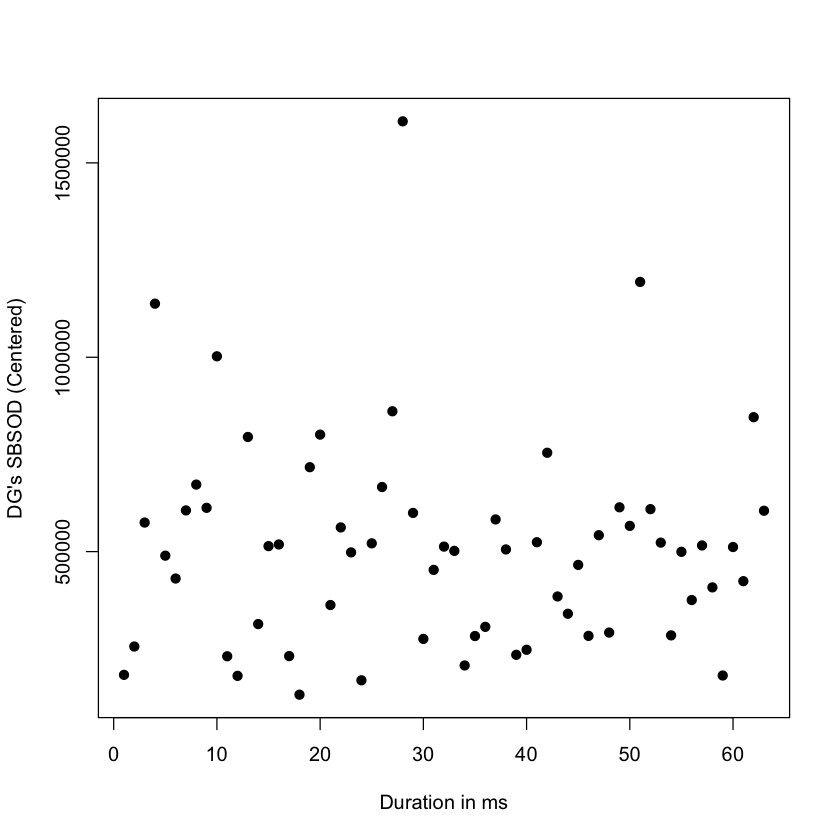

In [289]:
######################
#### Scatterplots ####

# Scatterplots for significant and marginally significant correlations #

# with DG's SBSOD
plot(PartnersPerformance$Duration_ms , PartnersPerformance$DGSBSOD_centered, 
     xlab="Duration in ms", ylab="DG's SBSOD (Centered)", pch=19)

In [290]:
#The following line of code adds the regression line (y~x) as the fit line to the scatterplot 
abline(lm(PartnersPerformance$DGSBSOD_centered~PartnersPerformance$Duration_ms), col="red")  

ERROR: Error in model.frame.default(formula = PartnersPerformance$DGSBSOD_centered ~ : invalid type (NULL) for variable 'PartnersPerformance$DGSBSOD_centered'


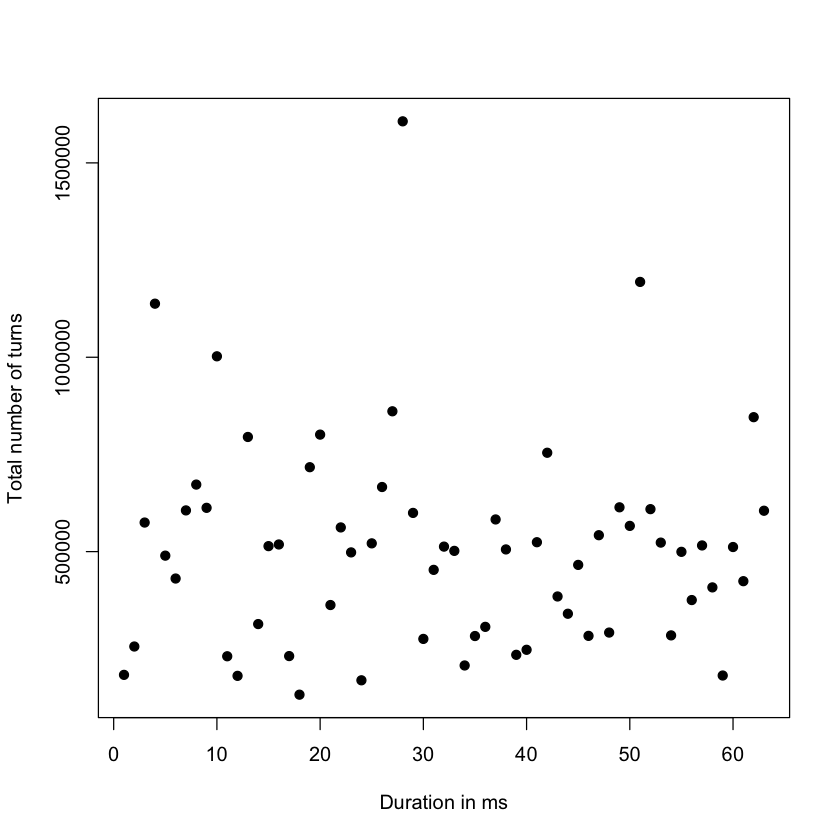

In [291]:
# with Total Turns
plot(PartnersPerformance$Duration_ms , PartnersPerformance$finalTurn, 
     xlab="Duration in ms", ylab="Total number of turns", pch=19)

In [292]:
#The following line of code adds the regression line (y~x) as the fit line to the scatterplot 
abline(lm(PartnersPerformance$finalTurn~PartnersPerformance$Duration_ms), col="red")  

ERROR: Error in model.frame.default(formula = PartnersPerformance$finalTurn ~ : invalid type (NULL) for variable 'PartnersPerformance$finalTurn'


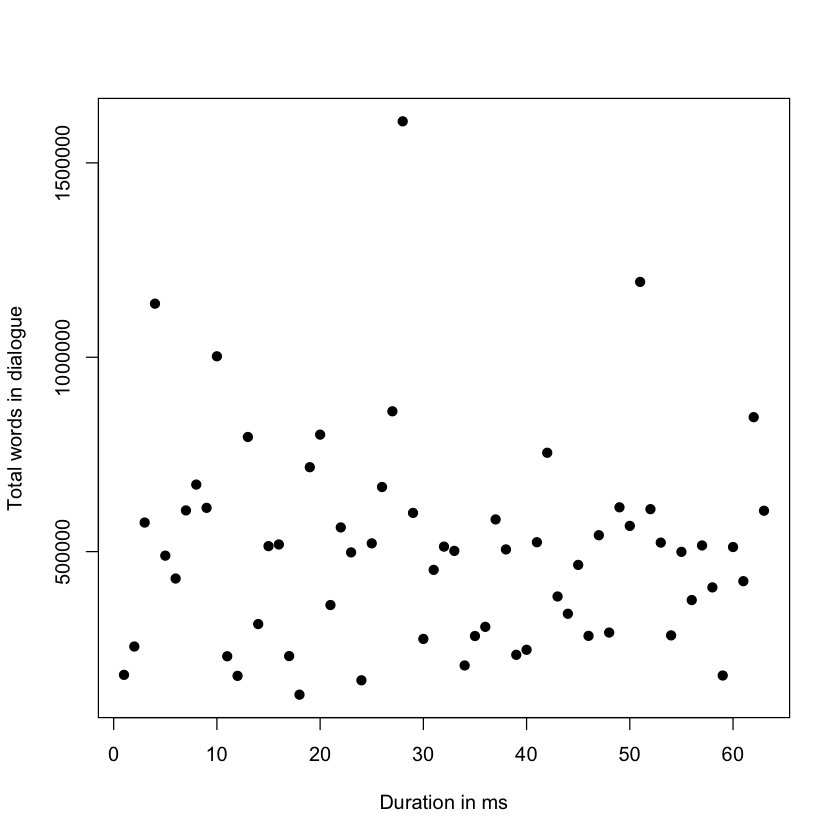

In [293]:
# with Total Words
plot(PartnersPerformance$Duration_ms , PartnersPerformance$TotalWords, 
     xlab="Duration in ms", ylab="Total words in dialogue", pch=19)

In [294]:
#The following line of code adds the regression line (y~x) as the fit line to the scatterplot 
abline(lm(PartnersPerformance$TotalWords~PartnersPerformance$Duration_ms), col="red")  

ERROR: Error in model.frame.default(formula = PartnersPerformance$TotalWords ~ : invalid type (NULL) for variable 'PartnersPerformance$TotalWords'


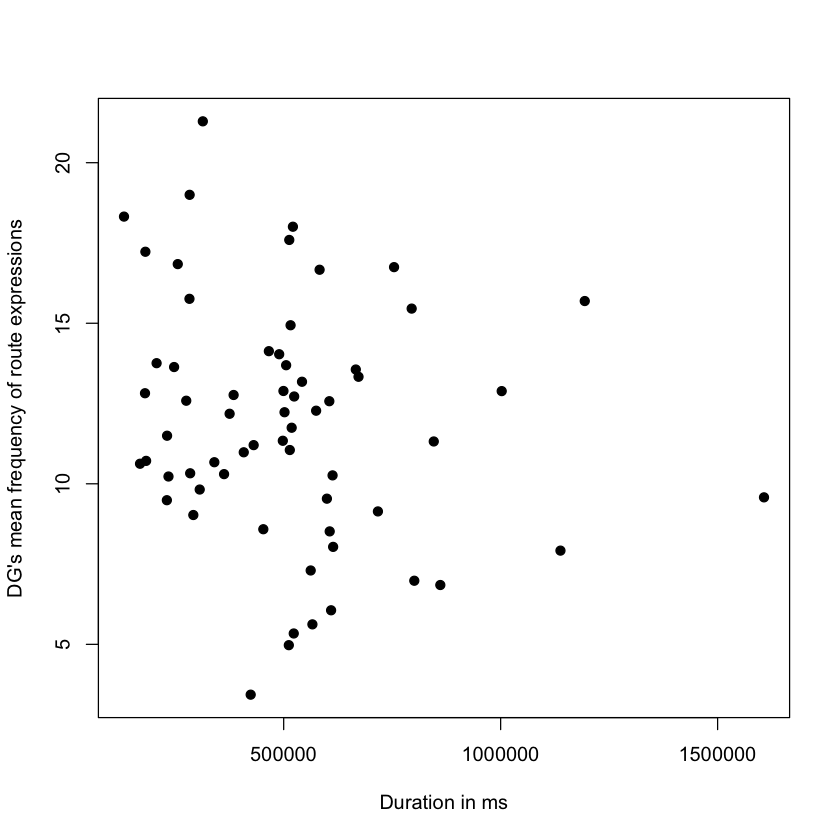

In [295]:
# with DG's Route expression frequency
plot(PartnersPerformance$Duration_ms , PartnersPerformance$SE_Route_freq_DG, 
     xlab="Duration in ms", ylab="DG's mean frequency of route expressions", pch=19)

In [296]:
#The following line of code adds the regression line (y~x) as the fit line to the scatterplot 
abline(lm(PartnersPerformance$SE_Route_freq_DG~PartnersPerformance$Duration_ms), col="red")  

ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


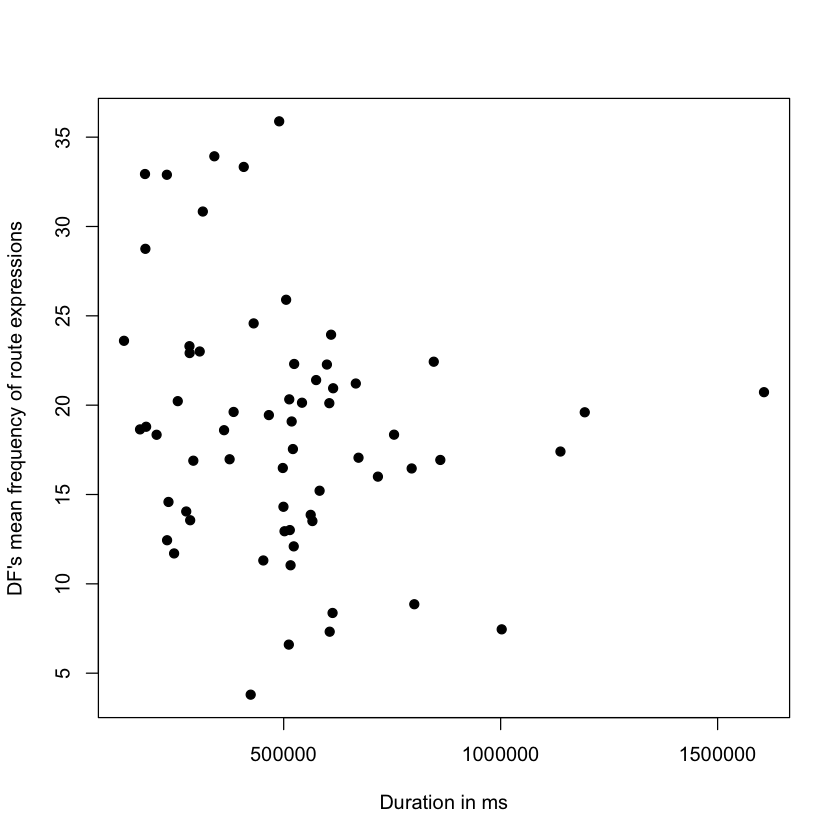

In [297]:
# with DF's Route expression frequency
plot(PartnersPerformance$Duration_ms , PartnersPerformance$SE_Route_freq_DF, 
     xlab="Duration in ms", ylab="DF's mean frequency of route expressions", pch=19)

In [298]:
#The following line of code adds the regression line (y~x) as the fit line to the scatterplot 
abline(lm(PartnersPerformance$SE_Route_freq_DF~PartnersPerformance$Duration_ms), col="red")  

ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


# From file "Affordances_Reliability_Speech.R"

In [299]:
install.packages("irr")


The downloaded binary packages are in
	/var/folders/zw/zvs2233j4xg_kw5_97qkq36r0000gn/T//RtmpGV0ztF/downloaded_packages


In [300]:
library(irr)
library(gdata)

Loading required package: lpSolve



In [301]:
# List the files of coder 2 (KC)
fls_KC = list.files("/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/", pattern='xls') # get list of xls reliability files
rt_KC = "/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/" # root folder location
print(fls_KC)
length(fls_KC)

 [1] "Affordances_Pair1_Session2_Ledras1_Side_CodedTrascript.xlsx"      
 [2] "Affordances_Pair1_Session4_Ledras2_Opposite_CodedTranscript.xlsx" 
 [3] "Affordances_Pair10_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
 [4] "Affordances_Pair10_Session3_Ledras1_Side_CodedTranscript.xlsx"    
 [5] "Affordances_Pair11_Session2_Ledras2_Side_CodedTranscript.xlsx"    
 [6] "Affordances_Pair11_Session3_Ledras1_Opposite_CodedTranscript.xlsx"
 [7] "Affordances_Pair12_Session2_Ledras1_Opposite_CodedTranscript.xlsx"
 [8] "Affordances_Pair12_Session3_Ledras2_Side_CodedTranscript.xlsx"    
 [9] "Affordances_Pair13_Session1_Ledras1_Side_CodedTranscript.xlsx"    
[10] "Affordances_Pair13_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[11] "Affordances_Pair14_Session1_Ledras2_Opposite_CodedTranscript.xlsx"
[12] "Affordances_Pair14_Session4_Ledras1_Side_CodedTranscript.xlsx"    
[13] "Affordances_Pair15_Session1_Ledras1_Side_CodedTranscript.xlsx"    
[14] "Affordances_Pair15_Session4_Ledras2_Opposite_

[1] 64

In [302]:
ReliabilityDataKC = c() #initiate empty variable for masterfile for coder KC's data
DialogueKC = c() #initiate empty variable for individual dialogues for coder KC's data

In [303]:
# Combine the coding in one dataframe: ReliabilityDataKC
for (fl_KC in fls_KC) {
  print(fl_KC)

  fileName = paste(rt_KC,fl_KC,sep='')
  DialogueKC = read.xls(fileName, stringsAsFactors=F, header=T) 
  DialogueKC[15] <- NULL # Get rid of 15th column, if there 
  colnames(DialogueKC) = c("Pair","Session","Route","Affordance","Turn","Speaker", 
                           "SpeechContent",
                           "SpatialExpression_KC",
                           "SE_Route_KC","SE_Allocentric_KC","SE_Neutral_KC","Ambiguous_KC",
                           "Landmark_KC","Demonstrative_KC")  
  
  ReliabilityDataKC = rbind(ReliabilityDataKC, DialogueKC)
  
}

[1] "Affordances_Pair1_Session2_Ledras1_Side_CodedTrascript.xlsx"
[1] "Affordances_Pair1_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair10_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair10_Session3_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair11_Session2_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair11_Session3_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair12_Session2_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair12_Session3_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair13_Session1_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair13_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair14_Session1_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair14_Session4_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair15_Session1_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair15_Session4_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair16

In [304]:
#View(ReliabilityDataKC)
ReliabilityDataKC

Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_KC,SE_Route_KC,SE_Allocentric_KC,SE_Neutral_KC,Ambiguous_KC,Landmark_KC,Demonstrative_KC
<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,Ledras1,Side,1,DG,το λοιπόν / είσαι / στη Λήδρας /,0,0,0,0,0,1,0
1,2,Ledras1,Side,2,DF,ΟΚ /,0,0,0,0,0,0,0
1,2,Ledras1,Side,3,DG,εντάξει ? / τζιαι είναι το παλιό το Flo Café στ’ αριστερά σου /,0,0,0,0,0,1,1
1,2,Ledras1,Side,4,DF,// κάτσε στην αρχή της Λήδρας ή στο τέλος της Λήδρας ?,2,0,0,2,0,2,0
1,2,Ledras1,Side,5,DG,στην αρχή / πού’ταν το Flo Café κάπου στη μέση,2,0,0,2,0,1,0
1,2,Ledras1,Side,6,DF,ΟΚ,0,0,0,0,0,0,0
1,2,Ledras1,Side,7,DG,πού’ταν το Flo Café {εντάξει} {πα*} πάνω στο χάρτη σου ?,1,0,1,0,0,1,0
1,2,Ledras1,Side,8,DF,ναι ?,0,0,0,0,0,0,0
1,2,Ledras1,Side,9,DG,εν τέλεια στο * στο τέλος | αρά μπορείς να πας μόνο πάνω /,2,0,1,1,0,0,0


In [305]:
str(ReliabilityDataKC)

'data.frame':	8428 obs. of  14 variables:
 $ Pair                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Session             : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Route               : chr  "Ledras1" "Ledras1" "Ledras1" "Ledras1" ...
 $ Affordance          : chr  "Side" "Side" "Side" "Side" ...
 $ Turn                : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Speaker             : chr  "DG" "DF" "DG" "DF" ...
 $ SpeechContent       : chr  "το λοιπόν / είσαι / στη Λήδρας / " "ΟΚ / " "εντάξει ? / τζιαι είναι το παλιό το Flo Café στ’ αριστερά σου / " " // κάτσε στην αρχή της Λήδρας ή στο τέλος της Λήδρας ?" ...
 $ SpatialExpression_KC: int  0 0 0 2 2 0 1 0 2 0 ...
 $ SE_Route_KC         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SE_Allocentric_KC   : int  0 0 0 0 0 0 1 0 1 0 ...
 $ SE_Neutral_KC       : int  0 0 0 2 2 0 0 0 1 0 ...
 $ Ambiguous_KC        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Landmark_KC         : int  1 0 1 2 1 0 1 0 0 0 ...
 $ Demonstrative_KC    : int  0 0 1 0 0 0 0 0 0 0 ...


In [306]:
# List the original coding files of coder 1 (AS) for these 10 files used for reliability
fls_AS = list.files("/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/", pattern='xls') # get list of original coding xls files
rt_AS = "/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Cognition/Extra credits/report2_files/osfstorage-archive/Data/Transcripts/" # root folder location

In [307]:
# Get subset of original coding
fls_AS_subset <- c(fls_AS[3:4], fls_AS[21:22], fls_AS[39:40], fls_AS[59:60], fls_AS[63:64])  
print(fls_AS_subset)
length(fls_AS_subset)

 [1] "Affordances_Pair10_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
 [2] "Affordances_Pair10_Session3_Ledras1_Side_CodedTranscript.xlsx"    
 [3] "Affordances_Pair19_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
 [4] "Affordances_Pair19_Session4_Ledras1_Side_CodedTranscript.xlsx"    
 [5] "Affordances_Pair27_Session2_Ledras2_Side_CodedTranscript.xlsx"    
 [6] "Affordances_Pair27_Session3_Ledras1_Opposite_CodedTranscript.xlsx"
 [7] "Affordances_Pair7_Session1_Ledras1_Opposite_CodedTranscript.xlsx" 
 [8] "Affordances_Pair7_Session3_Ledras2_Side_CodedTranscript.xlsx"     
 [9] "Affordances_Pair9_Session2_Ledras1_Side_CodedTranscript.xlsx"     
[10] "Affordances_Pair9_Session3_Ledras2_Opposite_CodedTranscript.xlsx" 


[1] 10

In [308]:
ReliabilityDataAS = c() #initiate empty variable for masterfile for subset of original AS coding
DialogueAS = c() #initiate empty variable for individual dialogues for original coder's (AS) data

In [309]:
for (fl_AS_subset in fls_AS_subset) {
  print(fl_AS_subset)
  
  fileName = paste(rt_AS,fl_AS_subset,sep='')
  DialogueAS = read.xls(fileName, stringsAsFactors=F, header=T) 
  DialogueAS <- DialogueAS[,1:14]
  
  colnames(DialogueAS) = c("Pair","Session","Route","Affordance","Turn","Speaker", 
                           "SpeechContent","SpatialExpression_AS",
                           "SE_Route_AS","SE_Allocentric_AS","SE_Neutral_AS","Ambiguous_AS",
                           "Landmark_AS","Demonstrative_AS")  
  
  ReliabilityDataAS = rbind(ReliabilityDataAS, DialogueAS)
  
}

[1] "Affordances_Pair10_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair10_Session3_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair19_Session2_Ledras2_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair19_Session4_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair27_Session2_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair27_Session3_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair7_Session1_Ledras1_Opposite_CodedTranscript.xlsx"
[1] "Affordances_Pair7_Session3_Ledras2_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair9_Session2_Ledras1_Side_CodedTranscript.xlsx"
[1] "Affordances_Pair9_Session3_Ledras2_Opposite_CodedTranscript.xlsx"


In [310]:
#View(ReliabilityDataAS)
ReliabilityDataAS

Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_AS,SE_Route_AS,SE_Allocentric_AS,SE_Neutral_AS,Ambiguous_AS,Landmark_AS,Demonstrative_AS
<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
10,2,Ledras 2,Opposite,1,DF,%laughs%,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,2,DG,ντάξει εννα πρέπει να λύσουμεν / λοιπόν / να μεν κάμνουμεν όπως πριν / να το πάρουμε που την αρκήν πόθεν *,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,3,DF,ναι,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,4,DG,ξεκινάς και πόθεν τελείωνεις,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,5,DF,μμ,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,6,DG,ξεκινάς που την δεξιά μερκά του χάρτη κάπου στην μέση /,2,0,2,0,0,0,0
10,2,Ledras 2,Opposite,7,DF,ναι,0,0,0,0,0,0,0
10,2,Ledras 2,Opposite,8,DG,τζιαι καταλήγεις στην αριστερή μερκά του χάρτη κάπου στην μέση /,2,0,2,0,0,0,0
10,2,Ledras 2,Opposite,9,DF,μμ,0,0,0,0,0,0,0


In [311]:
str(ReliabilityDataAS)

'data.frame':	1315 obs. of  14 variables:
 $ Pair                : int  10 10 10 10 10 10 10 10 10 10 ...
 $ Session             : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Route               : chr  "Ledras 2" "Ledras 2" "Ledras 2" "Ledras 2" ...
 $ Affordance          : chr  "Opposite" "Opposite" "Opposite" "Opposite" ...
 $ Turn                : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Speaker             : chr  "DF" "DG" "DF" "DG" ...
 $ SpeechContent       : chr  "%laughs%" "ντάξει εννα πρέπει να λύσουμεν / λοιπόν / να μεν κάμνουμεν όπως πριν / να το πάρουμε που την αρκήν πόθεν * " "ναι " "ξεκινάς και πόθεν τελείωνεις" ...
 $ SpatialExpression_AS: int  0 0 0 0 0 2 0 2 0 0 ...
 $ SE_Route_AS         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SE_Allocentric_AS   : int  0 0 0 0 0 2 0 2 0 0 ...
 $ SE_Neutral_AS       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Ambiguous_AS        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Landmark_AS         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Demonstrative_AS    : int  0 0 0 0 0 0 0 0 0 0 ...


In [312]:
# Check that data frames are arranged in the same way
head(ReliabilityDataAS)

,Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_AS,SE_Route_AS,SE_Allocentric_AS,SE_Neutral_AS,Ambiguous_AS,Landmark_AS,Demonstrative_AS
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10,2,Ledras 2,Opposite,1,DF,%laughs%,0,0,0,0,0,0,0
2,10,2,Ledras 2,Opposite,2,DG,ντάξει εννα πρέπει να λύσουμεν / λοιπόν / να μεν κάμνουμεν όπως πριν / να το πάρουμε που την αρκήν πόθεν *,0,0,0,0,0,0,0
3,10,2,Ledras 2,Opposite,3,DF,ναι,0,0,0,0,0,0,0
4,10,2,Ledras 2,Opposite,4,DG,ξεκινάς και πόθεν τελείωνεις,0,0,0,0,0,0,0
5,10,2,Ledras 2,Opposite,5,DF,μμ,0,0,0,0,0,0,0
6,10,2,Ledras 2,Opposite,6,DG,ξεκινάς που την δεξιά μερκά του χάρτη κάπου στην μέση /,2,0,2,0,0,0,0


In [313]:
head(ReliabilityDataKC)

,Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_KC,SE_Route_KC,SE_Allocentric_KC,SE_Neutral_KC,Ambiguous_KC,Landmark_KC,Demonstrative_KC
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,2,Ledras1,Side,1,DG,το λοιπόν / είσαι / στη Λήδρας /,0,0,0,0,0,1,0
2,1,2,Ledras1,Side,2,DF,ΟΚ /,0,0,0,0,0,0,0
3,1,2,Ledras1,Side,3,DG,εντάξει ? / τζιαι είναι το παλιό το Flo Café στ’ αριστερά σου /,0,0,0,0,0,1,1
4,1,2,Ledras1,Side,4,DF,// κάτσε στην αρχή της Λήδρας ή στο τέλος της Λήδρας ?,2,0,0,2,0,2,0
5,1,2,Ledras1,Side,5,DG,στην αρχή / πού’ταν το Flo Café κάπου στη μέση,2,0,0,2,0,1,0
6,1,2,Ledras1,Side,6,DF,ΟΚ,0,0,0,0,0,0,0


In [314]:
tail(ReliabilityDataAS)

,Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_AS,SE_Route_AS,SE_Allocentric_AS,SE_Neutral_AS,Ambiguous_AS,Landmark_AS,Demonstrative_AS
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1310,9,3,Ledras 2,Opposite,258,DF,δεξιά αριστερά μετά υποχρεωτικά αριστερά δεξιά αριστερά / {αριστερά} *,6,6,0,0,0,0,0
1311,9,3,Ledras 2,Opposite,259,DG,εκεί που‘ναι το τέλος του δρόμου θα είναι το υποχρεωτικά αριστερά / μέχρι το τέλος του δρόμου εκεί που θα φτάσεις τέλος του δρόμου υποθετικά θα ‘ταν το * θα ‘ναι υποχρεωτικά αριστερά,5,2,0,3,0,0,2
1312,9,3,Ledras 2,Opposite,260,DF,ναι μετά δεξιά <εε> υποχρεωτικά αριστερά / δεξιά αριστερά δεξιά δεξιά / κι ‘ναι στο * προς τα κάτω εκεί στα δεξιά μου,8,7,1,0,0,0,1
1313,9,3,Ledras 2,Opposite,261,DG,μμχμμ,0,0,0,0,0,0,0
1314,9,3,Ledras 2,Opposite,262,DF,‘ντάξει καλά ασ’το %smiles%,0,0,0,0,0,0,0
1315,9,3,Ledras 2,Opposite,263,DG,%smiles%,0,0,0,0,0,0,0


In [315]:
tail(ReliabilityDataKC)

,Pair,Session,Route,Affordance,Turn,Speaker,SpeechContent,SpatialExpression_KC,SE_Route_KC,SE_Allocentric_KC,SE_Neutral_KC,Ambiguous_KC,Landmark_KC,Demonstrative_KC
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8423,9,3,Ledras 2,Opposite,258,DF,δεξιά αριστερά μετά υποχρεωτικά αριστερά δεξιά αριστερά / {αριστερά} *,6,6,0,0,0,0,0
8424,9,3,Ledras 2,Opposite,259,DG,εκεί που‘ναι το τέλος του δρόμου θα είναι το υποχρεωτικά αριστερά / μέχρι το τέλος του δρόμου εκεί που θα φτάσεις τέλος του δρόμου υποθετικά θα ‘ταν το * θα ‘ναι υποχρεωτικά αριστερά,5,2,0,3,0,0,2
8425,9,3,Ledras 2,Opposite,260,DF,ναι μετά δεξιά <εε> υποχρεωτικά αριστερά / δεξιά αριστερά δεξιά δεξιά / κι ‘ναι στο * προς τα κάτω εκεί στα δεξιά μου,8,7,1,0,0,0,1
8426,9,3,Ledras 2,Opposite,261,DG,μμχμμ,0,0,0,0,0,0,0
8427,9,3,Ledras 2,Opposite,262,DF,‘ντάξει καλά ασ’το %smiles%,0,0,0,0,0,0,0
8428,9,3,Ledras 2,Opposite,263,DG,%smiles%,0,0,0,0,0,0,0


In [316]:
nrow(ReliabilityDataAS)

[1] 1315

In [317]:
nrow(ReliabilityDataKC)

[1] 8428

In [318]:
# Combine the two coders' judgments in the same dataframe
ReliabilityData <-c(ReliabilityDataAS, ReliabilityDataKC[,8:14])
str(ReliabilityData)

List of 21
 $ Pair                : int [1:1315] 10 10 10 10 10 10 10 10 10 10 ...
 $ Session             : int [1:1315] 2 2 2 2 2 2 2 2 2 2 ...
 $ Route               : chr [1:1315] "Ledras 2" "Ledras 2" "Ledras 2" "Ledras 2" ...
 $ Affordance          : chr [1:1315] "Opposite" "Opposite" "Opposite" "Opposite" ...
 $ Turn                : int [1:1315] 1 2 3 4 5 6 7 8 9 10 ...
 $ Speaker             : chr [1:1315] "DF" "DG" "DF" "DG" ...
 $ SpeechContent       : chr [1:1315] "%laughs%" "ντάξει εννα πρέπει να λύσουμεν / λοιπόν / να μεν κάμνουμεν όπως πριν / να το πάρουμε που την αρκήν πόθεν * " "ναι " "ξεκινάς και πόθεν τελείωνεις" ...
 $ SpatialExpression_AS: int [1:1315] 0 0 0 0 0 2 0 2 0 0 ...
 $ SE_Route_AS         : int [1:1315] 0 0 0 0 0 0 0 0 0 0 ...
 $ SE_Allocentric_AS   : int [1:1315] 0 0 0 0 0 2 0 2 0 0 ...
 $ SE_Neutral_AS       : int [1:1315] 0 0 0 0 0 0 0 0 0 0 ...
 $ Ambiguous_AS        : int [1:1315] 0 0 0 0 0 0 0 0 0 0 ...
 $ Landmark_AS         : int [1:1315] 0 0 0 0 0

In [319]:
###################################################
#### Agreement in total expressions identified ####
###################################################

## How many expressions identified in this set by each coder

sum(ReliabilityData$SpatialExpression_AS)

[1] 1448

In [320]:
sum(ReliabilityData$SpatialExpression_KC, na.rm=TRUE)
which(is.na(ReliabilityData$SpatialExpression_KC))

[1] 8987

integer(0)

In [321]:
sum(ReliabilityDataAS$SE_Route_AS)

[1] 1122

In [322]:
sum(ReliabilityDataKC$SE_Route_KC, na.rm=TRUE)
which(is.na(ReliabilityData$SE_Route_KC))

[1] 6673

integer(0)

In [323]:
sum(ReliabilityDataAS$SE_Allocentric_AS)

[1] 160

In [324]:
sum(ReliabilityDataKC$SE_Allocentric_KC, na.rm=TRUE)
which(is.na(ReliabilityData$SE_Allocentric_KC))

[1] 889

integer(0)

In [325]:
sum(ReliabilityDataAS$SE_Neutral_AS)

[1] 162

In [326]:
sum(ReliabilityDataKC$SE_Neutral_KC, na.rm=TRUE)
which(is.na(ReliabilityData$SE_Neutral_KC))

[1] 1210

integer(0)

In [327]:
sum(ReliabilityDataAS$Ambiguous_AS)

[1] 14

In [328]:
sum(ReliabilityDataKC$Ambiguous_KC, na.rm=TRUE)
which(is.na(ReliabilityData$Ambiguous_KC))

[1] 229

integer(0)

In [329]:
sum(ReliabilityDataAS$Landmark_AS)

[1] 262

In [330]:
sum(ReliabilityDataKC$Landmark_KC, na.rm=TRUE)
which(is.na(ReliabilityData$Landmark_KC)) # it's always the same row missing: 143

[1] 1564

integer(0)

In [331]:
##################################################
######## Calculating Krippendorff's alpha ########
##################################################

## Route expressions ##

route <- matrix(c(ReliabilityData$SE_Route_KC, ReliabilityData$SE_Route_AS), ncol = 2)
route <- t(route) #transpose rows and columns

KA_route =kripp.alpha(route, method="ratio")
KA_route

## Route detection: Assessing reliability for detecting a route expression in a turn
#detect_route<- apply(route, 2, function(x) {x[x >= 1] <- 1; x})
#KA_detect_route = kripp.alpha(detect_route, method="nominal")
#KA_detect_route

Warning message in matrix(c(ReliabilityData$SE_Route_KC, ReliabilityData$SE_Route_AS), :
“data length [9743] is not a sub-multiple or multiple of the number of rows [4872]”


 Krippendorff's alpha

 Subjects = 4872 
   Raters = 2 
    alpha = -0.00285 

In [332]:
## Survey expressions ##

survey <- matrix(c(ReliabilityData$SE_Allocentric_KC, ReliabilityData$SE_Allocentric_AS), ncol = 2)
survey <- t(survey) #transpose rows and columns

KA_survey = kripp.alpha(survey, method="ratio")
KA_survey

## Survey detection
#detect_survey<- apply(survey, 2, function(x) {x[x >= 1] <- 1; x})
#KA_detect_survey = kripp.alpha(detect_survey, method="nominal")
#KA_detect_survey

Warning message in matrix(c(ReliabilityData$SE_Allocentric_KC, ReliabilityData$SE_Allocentric_AS), :
“data length [9743] is not a sub-multiple or multiple of the number of rows [4872]”


 Krippendorff's alpha

 Subjects = 4872 
   Raters = 2 
    alpha = 0.0177 

In [333]:
## Neutral expressions ##

neutral <- matrix(c(ReliabilityData$SE_Neutral_KC, ReliabilityData$SE_Neutral_AS), ncol = 2)
neutral <- t(neutral) #transpose rows and columns

KA_neutral = kripp.alpha(neutral, method="ratio")
KA_neutral

#Detect neutral
#detect_neutral<- apply(neutral, 2, function(x) {x[x >= 1] <- 1; x})
#KA_detect_neutral = kripp.alpha(detect_neutral, method="nominal")
#KA_detect_neutral

Warning message in matrix(c(ReliabilityData$SE_Neutral_KC, ReliabilityData$SE_Neutral_AS), :
“data length [9743] is not a sub-multiple or multiple of the number of rows [4872]”


 Krippendorff's alpha

 Subjects = 4872 
   Raters = 2 
    alpha = 0.0285 

In [334]:
## Landmarks ##

landmarks <- matrix(c(ReliabilityData$Landmark_KC, ReliabilityData$Landmark_AS), ncol = 2)
landmarks <- t(landmarks) #transpose rows and columns

KA_landmarks = kripp.alpha(landmarks, method="ratio")
KA_landmarks

#Detect landmarks
#detect_landmarks <- apply(landmarks, 2, function(x) {x[x >= 1] <- 1; x})
#KA_detect_landmarks = kripp.alpha(detect_landmarks, method="nominal")
#KA_detect_landmarks

Warning message in matrix(c(ReliabilityData$Landmark_KC, ReliabilityData$Landmark_AS), :
“data length [9743] is not a sub-multiple or multiple of the number of rows [4872]”


 Krippendorff's alpha

 Subjects = 4872 
   Raters = 2 
    alpha = -0.00182 

In [335]:
## Demonstratives ##

demonstratives <- matrix(c(ReliabilityData$Demonstrative_KC, ReliabilityData$Demonstrative_AS), ncol = 2)
demonstratives <- t(demonstratives) #transpose rows and columns

KA_demonstratives = kripp.alpha(demonstratives, method="ratio")
KA_demonstratives

#Detect demonstratives
#detect_demonstratives <- apply(demonstratives, 2, function(x) {x[x >= 1] <- 1; x})
#KA_detect_demonstratives = kripp.alpha(detect_demonstratives, method="nominal")
#KA_detect_demonstratives

Warning message in matrix(c(ReliabilityData$Demonstrative_KC, ReliabilityData$Demonstrative_AS), :
“data length [9743] is not a sub-multiple or multiple of the number of rows [4872]”


 Krippendorff's alpha

 Subjects = 4872 
   Raters = 2 
    alpha = 0.0116 